In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/home/mondzi259/Apna_Assignment/src/ml_auto/')

In [4]:
from custom_estimator import Estimator, scoring_metric
from encoding import FreqeuncyEncoding,TargetEncoding
from hyperopt_model_selection import HyperOptModelSelection,hp
from custom_fold_generator import KFold,GroupKFold,CustomFolds
from lightgbm import LGBMRegressor

In [5]:
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
DATA_DIR = '/home/mondzi259/Apna_Assignment/data/'

In [8]:
df = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=0)
df.shape

(30000, 19)

In [9]:
df.drop('feebackgiven',axis=1,inplace=True)

In [10]:
data_dic = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=1,header=None)

In [11]:
data_dic

,0,1,2,3
0,lead,A candidate who has interacted with HR on the ...,NaN,NaN
1,shift,night/ day,"0 - day, 1 - night",NaN
2,gender,f/m/all,"0 - male jobs, 1 - female , 2 - all",NaN
3,education,10th to PG,"ordinally placed, 10th being lowest and PG the...",NaN
4,created_on,job created date,Days since a fixed reference data,"For ex: if reference data was 1 Jan 2020,\njob..."
5,employer_type,key-account/ smb/ enterprise/ consultant/ NA,"most jobs are smb, followed by Key accounts, e...",NaN
6,applicant_location,candidate distance from job,"lower the value, lower the distance requirement",NaN
7,city,city,is masked,NaN
8,area,area,is masked,NaN
9,organization,company name,is masked,NaN


In [12]:
df.head()

,shift,gender,education,created_on,dow,employer_type,applicant_location,city,area,organization,deposit,category,english,num_openings,max_salary,min_salary,is_part_time,leads_per_opening
0,0.0,0.0,3.0,413.0,3.0,0.0,0.0,1.0,4119.0,31278.0,0.0,55.0,2.0,22.0,21000.0,NaN,0.0,0.090909
1,0.0,0.0,3.0,529.0,0.0,4.0,0.0,2.0,2017.0,32006.0,0.0,54.0,2.0,2.0,80000.0,NaN,0.0,31.500000
2,0.0,0.0,0.0,457.0,0.0,4.0,0.0,3.0,1500.0,32029.0,0.0,42.0,3.0,1.0,3500.0,NaN,1.0,9.000000
3,0.0,0.0,4.0,450.0,3.0,4.0,0.0,5.0,638.0,9925.0,0.0,60.0,4.0,4.0,11500.0,NaN,0.0,0.000000
4,0.0,0.0,0.0,480.0,0.0,1.0,0.0,2.0,4115.0,8400.0,0.0,16.0,3.0,25.0,25000.0,NaN,0.0,1.400000


### Target vs created_on

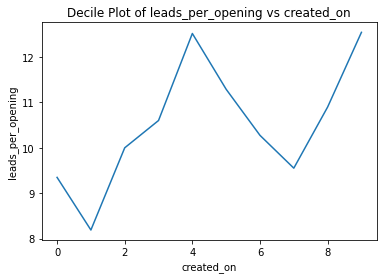

In [13]:
df.groupby(pd.qcut(df['created_on'],10,
                   duplicates='drop',labels=False))['leads_per_opening'].mean().plot()
plt.ylabel('leads_per_opening')
plt.title('Decile Plot of leads_per_opening vs created_on');

### Ideas:

1. CV: Time series, KFold, GKFold
2. log transform targets: business sense and outliers
3. cat OHE, LE, FE, TE
4. cat num agg
5. num num agg
6. missing min salary; app location=0; imputation w/wo
7. bayesian fs
8. API
9. Explainability
10. Local/Global feature importance
11. Outliers/score
12. clustering, svd, cluster distance
13. time based (created on) aggs

### 

In [14]:
num_cols = ['leads_per_opening','max_salary','min_salary','deposit','num_openings','created_on']
cat_cols = [i for i in df.columns.tolist() if i not in num_cols]
cat_ordinal_cols = ['applicant_location','english','education']
cat_non_ord_cols = [i for i in cat_cols if i not in cat_ordinal_cols]

In [15]:
cat_non_ord_cols,cat_ordinal_cols

(['shift',
  'gender',
  'dow',
  'employer_type',
  'city',
  'area',
  'organization',
  'category',
  'is_part_time'],
 ['applicant_location', 'english', 'education'])

In [16]:
df[cat_cols].nunique()

shift                     2
gender                    3
education                 6
dow                       7
employer_type             5
applicant_location        4
city                      7
area                   2740
organization          14886
category                 67
english                   4
is_part_time              2
dtype: int64

In [17]:
class FreqEnc:
    def __init__(self,cat_freq_cols):
        self.cat_freq_cols = cat_freq_cols
    def fit(self,df):
        self.freq_encoding_dict = {
                x: df[x].value_counts(1).to_dict() for x in self.cat_freq_cols
            }
    def transform(self,df):
        for col in self.cat_freq_cols:
            df[col+"_fe"] = df[col].map(self.freq_encoding_dict[col]).fillna(0)
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [18]:
df=df.sort_values('created_on').reset_index(drop=True)

In [19]:
df.shape

(30000, 18)

In [20]:
df['target'] = np.log1p(df.leads_per_opening)

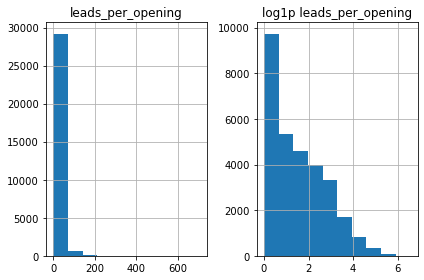

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
df.leads_per_opening.hist(ax=axes[0])
axes[0].set_title('leads_per_opening')
df.target.hist(ax=axes[1])
axes[1].set_title('log1p leads_per_opening')
plt.tight_layout()

In [22]:
df.target.describe()

count    30000.000000
mean         1.507317
std          1.264234
min          0.000000
25%          0.385158
50%          1.299283
75%          2.397895
max          6.559615
Name: target, dtype: float64

In [23]:
folds =[
    (df[(df.created_on<=df.created_on.quantile(0.7))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.7))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.1))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.8))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.2))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.9))&\
      (df.created_on<=df.created_on.quantile(1))].index.tolist())
]

In [24]:
[(df.iloc[i].shape,df.iloc[j].shape) for i,j in folds]

[((21137, 19), (3031, 19)),
 ((21191, 19), (2865, 19)),
 ((21073, 19), (2967, 19))]

In [25]:
target = df.target.values

In [26]:
fe = FreqEnc(cat_freq_cols=cat_non_ord_cols)

df = fe.fit_transform(df)

In [31]:
(df['max_salary']-df.min_salary).describe()

count     4117.000000
mean      6104.805441
std       6419.603169
min      -2000.000000
25%       2000.000000
50%       5000.000000
75%       7500.000000
max      96399.000000
dtype: float64

In [32]:
df.shape

(30000, 28)

In [33]:
df[cat_non_ord_cols].nunique()

shift                2
gender               3
dow                  7
employer_type        5
city                 7
area              2740
organization     14886
category            67
is_part_time         2
dtype: int64

In [34]:
df[cat_ordinal_cols].nunique()

applicant_location    4
english               4
education             6
dtype: int64

### Adding cat-cat interactions

In [35]:
def get_derived_cat(df,a,b):
    df[a+'_'+b]= df[a].astype('str') + '_' + df[b].astype('str')
    return df 

In [36]:
def gen_cat_cat(df):
    df = get_derived_cat(df,'category','organization')
    df = get_derived_cat(df,'category','area')
    df = get_derived_cat(df,'category','city')
    df = get_derived_cat(df,'category','dow')
    df = get_derived_cat(df,'category','employer_type')
    
    df = get_derived_cat(df,'organization','area')
    df = get_derived_cat(df,'organization','city')
    df = get_derived_cat(df,'organization','dow')
    df = get_derived_cat(df,'organization','employer_type')
    
    df = get_derived_cat(df,'area','city')
    df = get_derived_cat(df,'area','dow')
    df = get_derived_cat(df,'area','employer_type')
    
    df = get_derived_cat(df,'city','dow')
    df = get_derived_cat(df,'city','employer_type')
    
    df = get_derived_cat(df,'dow','employer_type')
    
    df['cat_city_dow'] = df['category'].astype('str') + '_' + df['city'].astype('str') + '_' + df['dow'].astype('str')
    
    return df

In [37]:
df = gen_cat_cat(df)

In [38]:
cat_cat_cols = ['category_organization', 'category_area', 'category_city', 'category_dow',
                'category_employer_type', 'organization_area', 'organization_city', 'organization_dow', 
                'organization_employer_type', 'area_city', 'area_dow', 'area_employer_type', 'city_dow',
               'city_employer_type', 'dow_employer_type','cat_city_dow']

In [39]:
fe2 = FreqEnc(cat_freq_cols=['category_city'])

df = fe2.fit_transform(df)

In [40]:
class CatNumAgg:
    def __init__(self,agg_cols, agg_funcs, grpby_cols):
        self.agg_cols=agg_cols
        self.agg_funcs=agg_funcs
        self.grpby_cols=grpby_cols
    def fit(self,df):
        self.encoding_dict={}
        for grp_col in self.grpby_cols:
            agg_df = df.groupby(grp_col)[self.agg_cols].agg(self.agg_funcs).reset_index()
            agg_df.columns = [grp_col] + [
                i + "_" + j + "_grpby" + "_and_" + grp_col
                for i in self.agg_cols
                for j in self.agg_funcs
            ]
            self.encoding_dict[grp_col]=agg_df.to_dict()
    def transform(self,df):
        for k in self.encoding_dict:
            agg_df = pd.DataFrame(self.encoding_dict[k])
            df = df.merge(agg_df, on=k, how="left")
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [41]:
imp_num_cols = ['num_openings','max_salary','min_salary','education','applicant_location']
agg_funcs = ['mean','std','min','max','median']
cat_agg_cols = ['category','organization','area','category_city',
                'category_dow','city',
                'employer_type',]

In [42]:
catnumagg = CatNumAgg(agg_cols= imp_num_cols,agg_funcs=agg_funcs, grpby_cols=cat_agg_cols)

In [43]:
df = catnumagg.fit_transform(df)

In [44]:
df.shape

(30000, 220)

In [45]:
uniq_cols = df.columns[df.nunique(dropna=False)==1]
len(uniq_cols)

17

In [46]:
df.drop(uniq_cols,axis=1,inplace=True)

In [47]:
remove_cols = cat_non_ord_cols + ['target','leads_per_opening'] + cat_cat_cols
use_cols = [i for i in df.columns if i not in remove_cols] 

In [ ]:
len(use_cols)

In [48]:
params = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'min_child_samples': 120,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 16,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 10}

In [49]:
est = Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True)

In [50]:
est.get_repeated_out_of_folds(df[use_cols].values,target)

[100]	valid_0's rmse: 0.894347	valid_0's l2: 0.799857	valid_1's rmse: 0.805084	valid_1's l2: 0.648159
[200]	valid_0's rmse: 0.890303	valid_0's l2: 0.79264	valid_1's rmse: 0.754139	valid_1's l2: 0.568726
[100]	valid_0's rmse: 0.834886	valid_0's l2: 0.697034	valid_1's rmse: 0.806274	valid_1's l2: 0.650078
[200]	valid_0's rmse: 0.829819	valid_0's l2: 0.688599	valid_1's rmse: 0.755737	valid_1's l2: 0.571139
[300]	valid_0's rmse: 0.828679	valid_0's l2: 0.686709	valid_1's rmse: 0.719705	valid_1's l2: 0.517975
[400]	valid_0's rmse: 0.830134	valid_0's l2: 0.689122	valid_1's rmse: 0.68802	valid_1's l2: 0.473371
[100]	valid_0's rmse: 0.873277	valid_0's l2: 0.762612	valid_1's rmse: 0.8024	valid_1's l2: 0.643846
[200]	valid_0's rmse: 0.869807	valid_0's l2: 0.756565	valid_1's rmse: 0.751098	valid_1's l2: 0.564149


{'cv_scores': [0.8884260455116506, 0.8277062413414091, 0.8684975120286321],
 'avg_cv_score': 0.8615432662938973,
 'std_scores': 0.02527178670536806,
 'overall_cv_score': 1.71385676246552,
 'eval_score': 0.8615432662938973}

In [51]:
lgbm_space = {
#    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.025),
    'n_estimators': 10000,
#     'early_stopping_rounds': 100,
    'num_leaves':  hp.quniform('num_leaves', 16, 48, 16),
#     'min_child_weight': hp.quniform('min_child_weight', 1, 40, 5),
    'min_child_samples': hp.quniform('min_child_samples', 1, 140, 10),
    'subsample': hp.quniform('subsample', 0.6, 1, 0.2),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.2),
    'subsample_freq': hp.choice('subsample_freq',[5,10]),
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'n_jobs': -1
}

In [52]:
hyp = HyperOptModelSelection(Estimator(model=LGBMRegressor(),
                                       early_stopping_rounds=100,
                                       validation_scheme=folds,
                                       shuffle=True),
                             space= lgbm_space,
                             max_evals=220,is_maximize=False,random_seed=100,
                             params_mapping = {'n_estimators':int, 'num_leaves':int, 
                                               'max_depth':int,'min_child_samples':int},          
                             log_file_path="hyperopt_log.txt")

In [53]:
hyp.fit(df[use_cols].values,target)

Starting HyperOpt 220 Evals with Dataset of Shape ((30000, 176),(30000,))


  0%|                                                                   | 0/220 [00:00<?, ?trial/s, best loss=?]


Iteration: 1, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.90594	valid_0's l2: 0.820728	valid_1's rmse: 0.727203	valid_1's l2: 0.528824            
[100]	valid_0's rmse: 0.839674	valid_0's l2: 0.705052	valid_1's rmse: 0.729721	valid_1's l2: 0.532492           
[200]	valid_0's rmse: 0.83827	valid_0's l2: 0.702697	valid_1's rmse: 0.641359	valid_1's l2: 0.411341            
[100]	valid_0's rmse: 0.881938	valid_0's l2: 0.777815	valid_1's rmse: 0.724309	valid_1's l2: 0.524624           
  0%|                                                                   | 0/220 [00:04<?, ?trial/s, best loss=?]

Score - 0.8727624976409637, Std - 0.028069047632516254, Eval Score - 0.8727624976409637
Score across folds - [0.9030364996175966, 0.835389922548662, 0.8798610707566324].


  0%|▏                                        | 1/220 [00:05<19:20,  5.30s/trial, best loss: 0.8727624976409637]


Iteration: 2, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900731	valid_0's l2: 0.811316	valid_1's rmse: 0.746872	valid_1's l2: 0.557818           
[100]	valid_0's rmse: 0.840385	valid_0's l2: 0.706247	valid_1's rmse: 0.746426	valid_1's l2: 0.557151           
[200]	valid_0's rmse: 0.837594	valid_0's l2: 0.701563	valid_1's rmse: 0.671283	valid_1's l2: 0.450621           
[100]	valid_0's rmse: 0.873004	valid_0's l2: 0.762137	valid_1's rmse: 0.742673	valid_1's l2: 0.551563           
[200]	valid_0's rmse: 0.871633	valid_0's l2: 0.759744	valid_1's rmse: 0.666697	valid_1's l2: 0.444485           
  0%|▏                                        | 1/220 [00:10<19:20,  5.30s/trial, best loss: 0.8727624976409637]

Score - 0.8681744568065528, Std - 0.025655327137587274, Eval Score - 0.8681744568065528
Score across folds - [0.898840463404813, 0.8360488734408716, 0.8696340335739737].


  1%|▎                                        | 2/220 [00:10<18:57,  5.22s/trial, best loss: 0.8681744568065528]


Iteration: 3, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897488	valid_0's l2: 0.805484	valid_1's rmse: 0.805637	valid_1's l2: 0.649051           
[200]	valid_0's rmse: 0.893895	valid_0's l2: 0.799049	valid_1's rmse: 0.752447	valid_1's l2: 0.566177           
[300]	valid_0's rmse: 0.895048	valid_0's l2: 0.80111	valid_1's rmse: 0.714578	valid_1's l2: 0.510622            
[100]	valid_0's rmse: 0.841791	valid_0's l2: 0.708612	valid_1's rmse: 0.808737	valid_1's l2: 0.654055           
[200]	valid_0's rmse: 0.839407	valid_0's l2: 0.704604	valid_1's rmse: 0.757235	valid_1's l2: 0.573405           
[300]	valid_0's rmse: 0.836511	valid_0's l2: 0.699751	valid_1's rmse: 0.717678	valid_1's l2: 0.515062           
[400]	valid_0's rmse: 0.837114	valid_0's l2: 0.70076	valid_1's rmse: 0.685224	valid_1's l2: 0.469532            
[100]	valid_0's rmse: 0.873903	valid_0's l2: 0.763707	valid_1's rmse: 0.803734	valid_1's l2: 0.645988           
[200]	valid_0's rmse: 0.872151	valid_0's l2: 0.760647	valid_1's rmse: 0.751238	valid_1's l2: 0.5

Score - 0.8658814226827202, Std - 0.02364696856391921, Eval Score - 0.8658814226827202
Score across folds - [0.8924679855812498, 0.8350201394026731, 0.8701561430642375].


  1%|▌                                        | 3/220 [00:15<18:18,  5.06s/trial, best loss: 0.8658814226827202]


Iteration: 4, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898094	valid_0's l2: 0.806572	valid_1's rmse: 0.802634	valid_1's l2: 0.644222           
[200]	valid_0's rmse: 0.895091	valid_0's l2: 0.801188	valid_1's rmse: 0.749397	valid_1's l2: 0.561596           
[100]	valid_0's rmse: 0.840257	valid_0's l2: 0.706032	valid_1's rmse: 0.805903	valid_1's l2: 0.649479           
[200]	valid_0's rmse: 0.83846	valid_0's l2: 0.703015	valid_1's rmse: 0.753061	valid_1's l2: 0.567101            
[100]	valid_0's rmse: 0.871751	valid_0's l2: 0.75995	valid_1's rmse: 0.800477	valid_1's l2: 0.640764            
[200]	valid_0's rmse: 0.86675	valid_0's l2: 0.751256	valid_1's rmse: 0.747221	valid_1's l2: 0.558339            
  1%|▌                                        | 3/220 [00:19<18:18,  5.06s/trial, best loss: 0.8658814226827202]

Score - 0.8646021929271984, Std - 0.023669832753320623, Eval Score - 0.8646021929271984
Score across folds - [0.8930100913080247, 0.8350641328710148, 0.8657323546025559].


  2%|▋                                        | 4/220 [00:20<17:39,  4.90s/trial, best loss: 0.8646021929271984]


Iteration: 5, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900955	valid_0's l2: 0.811719	valid_1's rmse: 0.766912	valid_1's l2: 0.588153           
[200]	valid_0's rmse: 0.901181	valid_0's l2: 0.812127	valid_1's rmse: 0.695159	valid_1's l2: 0.483246           
[100]	valid_0's rmse: 0.838242	valid_0's l2: 0.70265	valid_1's rmse: 0.769231	valid_1's l2: 0.591716            
[200]	valid_0's rmse: 0.832841	valid_0's l2: 0.693624	valid_1's rmse: 0.698909	valid_1's l2: 0.488473           
[100]	valid_0's rmse: 0.875357	valid_0's l2: 0.766249	valid_1's rmse: 0.76291	valid_1's l2: 0.582032            
[200]	valid_0's rmse: 0.881978	valid_0's l2: 0.777885	valid_1's rmse: 0.692817	valid_1's l2: 0.479996           
  2%|▋                                        | 4/220 [00:23<17:39,  4.90s/trial, best loss: 0.8646021929271984]

Score - 0.8681572297791412, Std - 0.0284555017879256, Eval Score - 0.8681572297791412
Score across folds - [0.8993366922402722, 0.8305344730305007, 0.8746005240666508].


  2%|▉                                        | 5/220 [00:23<16:18,  4.55s/trial, best loss: 0.8646021929271984]


Iteration: 6, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 30, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.90323	valid_0's l2: 0.815824	valid_1's rmse: 0.802927	valid_1's l2: 0.644692            
[200]	valid_0's rmse: 0.899893	valid_0's l2: 0.809808	valid_1's rmse: 0.747614	valid_1's l2: 0.558926           
[100]	valid_0's rmse: 0.838362	valid_0's l2: 0.702851	valid_1's rmse: 0.803667	valid_1's l2: 0.64588            
[200]	valid_0's rmse: 0.835866	valid_0's l2: 0.698672	valid_1's rmse: 0.749654	valid_1's l2: 0.561981           
[100]	valid_0's rmse: 0.870888	valid_0's l2: 0.758447	valid_1's rmse: 0.801267	valid_1's l2: 0.642029           
[200]	valid_0's rmse: 0.867855	valid_0's l2: 0.753172	valid_1's rmse: 0.74629	valid_1's l2: 0.556949            
  2%|▉                                        | 5/220 [00:27<16:18,  4.55s/trial, best loss: 0.8646021929271984]

Score - 0.8664410904305587, Std - 0.026531002624164298, Eval Score - 0.8664410904305587
Score across folds - [0.8989226119155589, 0.8339352068210243, 0.8664654525550934].


  3%|█                                        | 6/220 [00:27<15:21,  4.31s/trial, best loss: 0.8646021929271984]


Iteration: 7, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900283	valid_0's l2: 0.81051	valid_1's rmse: 0.7386	valid_1's l2: 0.54553               
[100]	valid_0's rmse: 0.837419	valid_0's l2: 0.701271	valid_1's rmse: 0.740383	valid_1's l2: 0.548167           
[200]	valid_0's rmse: 0.8397	valid_0's l2: 0.705096	valid_1's rmse: 0.661632	valid_1's l2: 0.437757             
[100]	valid_0's rmse: 0.870736	valid_0's l2: 0.758181	valid_1's rmse: 0.737167	valid_1's l2: 0.543415           
[200]	valid_0's rmse: 0.874661	valid_0's l2: 0.765031	valid_1's rmse: 0.656142	valid_1's l2: 0.430523           
  3%|█                                        | 6/220 [00:33<15:21,  4.31s/trial, best loss: 0.8646021929271984]

Score - 0.8676901596086753, Std - 0.02467767191799278, Eval Score - 0.8676901596086753
Score across folds - [0.8968830410960619, 0.8365313220038485, 0.8696561157261159].


  3%|█▎                                       | 7/220 [00:33<16:59,  4.78s/trial, best loss: 0.8646021929271984]


Iteration: 8, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.901069	valid_0's l2: 0.811926	valid_1's rmse: 0.752493	valid_1's l2: 0.566246           
[200]	valid_0's rmse: 0.905021	valid_0's l2: 0.819063	valid_1's rmse: 0.674901	valid_1's l2: 0.455491           
[100]	valid_0's rmse: 0.832422	valid_0's l2: 0.692926	valid_1's rmse: 0.75116	valid_1's l2: 0.564241            
[200]	valid_0's rmse: 0.832435	valid_0's l2: 0.692948	valid_1's rmse: 0.675703	valid_1's l2: 0.456575           
[100]	valid_0's rmse: 0.873348	valid_0's l2: 0.762736	valid_1's rmse: 0.747309	valid_1's l2: 0.55847            
[200]	valid_0's rmse: 0.876505	valid_0's l2: 0.768262	valid_1's rmse: 0.671273	valid_1's l2: 0.450607           
  3%|█▎                                       | 7/220 [00:37<16:59,  4.78s/trial, best loss: 0.8646021929271984]

Score - 0.8679329626274471, Std - 0.028359463899680814, Eval Score - 0.8679329626274471
Score across folds - [0.9001538522899599, 0.8311404122207644, 0.8725046233716172].


  4%|█▍                                       | 8/220 [00:37<15:49,  4.48s/trial, best loss: 0.8646021929271984]


Iteration: 9, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.899576	valid_0's l2: 0.809237	valid_1's rmse: 0.743382	valid_1's l2: 0.552616           
[200]	valid_0's rmse: 0.898119	valid_0's l2: 0.806619	valid_1's rmse: 0.663957	valid_1's l2: 0.440839           
[100]	valid_0's rmse: 0.834971	valid_0's l2: 0.697177	valid_1's rmse: 0.746146	valid_1's l2: 0.556734           
[100]	valid_0's rmse: 0.868848	valid_0's l2: 0.754897	valid_1's rmse: 0.740378	valid_1's l2: 0.54816            
[200]	valid_0's rmse: 0.870019	valid_0's l2: 0.756932	valid_1's rmse: 0.661604	valid_1's l2: 0.43772            
  4%|█▍                                       | 8/220 [00:41<15:49,  4.48s/trial, best loss: 0.8646021929271984]

Score - 0.8655895491852587, Std - 0.025391886104365647, Eval Score - 0.8655895491852587
Score across folds - [0.89607296569751, 0.8339102982839848, 0.8667853835742813].


  4%|█▋                                       | 9/220 [00:42<15:56,  4.54s/trial, best loss: 0.8646021929271984]


Iteration: 10, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.901679	valid_0's l2: 0.813024	valid_1's rmse: 0.670455	valid_1's l2: 0.44951            
[100]	valid_0's rmse: 0.835055	valid_0's l2: 0.697318	valid_1's rmse: 0.673529	valid_1's l2: 0.453642           
[200]	valid_0's rmse: 0.834044	valid_0's l2: 0.695629	valid_1's rmse: 0.572865	valid_1's l2: 0.328174           
[100]	valid_0's rmse: 0.87625	valid_0's l2: 0.767814	valid_1's rmse: 0.670154	valid_1's l2: 0.449107            
  4%|█▋                                       | 9/220 [00:48<15:56,  4.54s/trial, best loss: 0.8646021929271984]

Score - 0.8698410053152276, Std - 0.027577297381010706, Eval Score - 0.8698410053152276
Score across folds - [0.9005136436646768, 0.8336443664216211, 0.875365005859385].


  5%|█▊                                      | 10/220 [00:48<18:18,  5.23s/trial, best loss: 0.8646021929271984]


Iteration: 11, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898206	valid_0's l2: 0.806773	valid_1's rmse: 0.750964	valid_1's l2: 0.563946           
[200]	valid_0's rmse: 0.898448	valid_0's l2: 0.807209	valid_1's rmse: 0.676105	valid_1's l2: 0.457118           
[100]	valid_0's rmse: 0.83685	valid_0's l2: 0.700317	valid_1's rmse: 0.750141	valid_1's l2: 0.562712            
[200]	valid_0's rmse: 0.835092	valid_0's l2: 0.697379	valid_1's rmse: 0.677026	valid_1's l2: 0.458365           
[100]	valid_0's rmse: 0.875763	valid_0's l2: 0.76696	valid_1's rmse: 0.748218	valid_1's l2: 0.55983             
[200]	valid_0's rmse: 0.873996	valid_0's l2: 0.76387	valid_1's rmse: 0.672446	valid_1's l2: 0.452183            
  5%|█▊                                      | 10/220 [00:53<18:18,  5.23s/trial, best loss: 0.8646021929271984]

Score - 0.8673371141198141, Std - 0.02609868901740006, Eval Score - 0.8673371141198141
Score across folds - [0.8968013202368258, 0.8333538352255021, 0.8718561868971142].


  5%|██                                      | 11/220 [00:53<18:05,  5.20s/trial, best loss: 0.8646021929271984]


Iteration: 12, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.901069	valid_0's l2: 0.811926	valid_1's rmse: 0.752493	valid_1's l2: 0.566246           
[200]	valid_0's rmse: 0.905021	valid_0's l2: 0.819063	valid_1's rmse: 0.674901	valid_1's l2: 0.455491           
[100]	valid_0's rmse: 0.832422	valid_0's l2: 0.692926	valid_1's rmse: 0.75116	valid_1's l2: 0.564241            
[200]	valid_0's rmse: 0.832435	valid_0's l2: 0.692948	valid_1's rmse: 0.675703	valid_1's l2: 0.456575           
[100]	valid_0's rmse: 0.873348	valid_0's l2: 0.762736	valid_1's rmse: 0.747309	valid_1's l2: 0.55847            
[200]	valid_0's rmse: 0.876505	valid_0's l2: 0.768262	valid_1's rmse: 0.671273	valid_1's l2: 0.450607           
  5%|██                                      | 11/220 [00:57<18:05,  5.20s/trial, best loss: 0.8646021929271984]

Score - 0.8679329626274471, Std - 0.028359463899680814, Eval Score - 0.8679329626274471
Score across folds - [0.9001538522899599, 0.8311404122207644, 0.8725046233716172].


  5%|██▏                                     | 12/220 [00:57<16:35,  4.79s/trial, best loss: 0.8646021929271984]


Iteration: 13, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 30, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.89915	valid_0's l2: 0.808471	valid_1's rmse: 0.803088	valid_1's l2: 0.644951            
[200]	valid_0's rmse: 0.898428	valid_0's l2: 0.807172	valid_1's rmse: 0.748385	valid_1's l2: 0.56008            
[100]	valid_0's rmse: 0.838082	valid_0's l2: 0.702382	valid_1's rmse: 0.804751	valid_1's l2: 0.647625           
[200]	valid_0's rmse: 0.834265	valid_0's l2: 0.695998	valid_1's rmse: 0.74925	valid_1's l2: 0.561376            
[300]	valid_0's rmse: 0.831514	valid_0's l2: 0.691415	valid_1's rmse: 0.706958	valid_1's l2: 0.49979            
[100]	valid_0's rmse: 0.874243	valid_0's l2: 0.764301	valid_1's rmse: 0.798369	valid_1's l2: 0.637393           
[200]	valid_0's rmse: 0.870428	valid_0's l2: 0.757645	valid_1's rmse: 0.743485	valid_1's l2: 0.55277            
[300]	valid_0's rmse: 0.872031	valid_0's l2: 0.760438	valid_1's rmse: 0.702229	valid_1's l2: 0.493125           
  5%|██▏                                     | 12/220 [01:01<16:35,  4.79s/trial, best loss: 0.8

Score - 0.8655554215508191, Std - 0.027048543776264204, Eval Score - 0.8655554215508191
Score across folds - [0.8967554550598431, 0.8307889233142626, 0.8691218862783516].


  6%|██▎                                     | 13/220 [01:02<15:56,  4.62s/trial, best loss: 0.8646021929271984]


Iteration: 14, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899608	valid_0's l2: 0.809295	valid_1's rmse: 0.738727	valid_1's l2: 0.545717           
[200]	valid_0's rmse: 0.89832	valid_0's l2: 0.806978	valid_1's rmse: 0.659011	valid_1's l2: 0.434295            
[100]	valid_0's rmse: 0.83158	valid_0's l2: 0.691525	valid_1's rmse: 0.740614	valid_1's l2: 0.548509            
[200]	valid_0's rmse: 0.832322	valid_0's l2: 0.692759	valid_1's rmse: 0.661603	valid_1's l2: 0.437719           
[100]	valid_0's rmse: 0.872407	valid_0's l2: 0.761093	valid_1's rmse: 0.73644	valid_1's l2: 0.542344            
[200]	valid_0's rmse: 0.875076	valid_0's l2: 0.765759	valid_1's rmse: 0.655825	valid_1's l2: 0.430107           
  6%|██▎                                     | 13/220 [01:07<15:56,  4.62s/trial, best loss: 0.8646021929271984]

Score - 0.8665763845227247, Std - 0.026945698450094865, Eval Score - 0.8665763845227247
Score across folds - [0.8967936342545214, 0.8313606872336753, 0.8715748320799772].


  6%|██▌                                     | 14/220 [01:07<16:58,  4.94s/trial, best loss: 0.8646021929271984]


Iteration: 15, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.90307	valid_0's l2: 0.815536	valid_1's rmse: 0.702972	valid_1's l2: 0.49417             
[100]	valid_0's rmse: 0.835664	valid_0's l2: 0.698334	valid_1's rmse: 0.704958	valid_1's l2: 0.496966           
[200]	valid_0's rmse: 0.833997	valid_0's l2: 0.69555	valid_1's rmse: 0.607271	valid_1's l2: 0.368778            
[300]	valid_0's rmse: 0.836092	valid_0's l2: 0.69905	valid_1's rmse: 0.538728	valid_1's l2: 0.290228            
[100]	valid_0's rmse: 0.879013	valid_0's l2: 0.772663	valid_1's rmse: 0.700994	valid_1's l2: 0.491393           
  6%|██▌                                     | 14/220 [01:12<16:58,  4.94s/trial, best loss: 0.8646021929271984]

Score - 0.8704284500077099, Std - 0.029952619642575576, Eval Score - 0.8704284500077099
Score across folds - [0.9027899738130247, 0.8305772853216663, 0.8779180908884389].


  7%|██▋                                     | 15/220 [01:12<16:47,  4.92s/trial, best loss: 0.8646021929271984]


Iteration: 16, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.89946	valid_0's l2: 0.809029	valid_1's rmse: 0.805107	valid_1's l2: 0.648197            
[200]	valid_0's rmse: 0.903169	valid_0's l2: 0.815715	valid_1's rmse: 0.753506	valid_1's l2: 0.567771           
[100]	valid_0's rmse: 0.842651	valid_0's l2: 0.710061	valid_1's rmse: 0.807669	valid_1's l2: 0.652329           
[200]	valid_0's rmse: 0.839246	valid_0's l2: 0.704333	valid_1's rmse: 0.7552	valid_1's l2: 0.570327             
[100]	valid_0's rmse: 0.875442	valid_0's l2: 0.766399	valid_1's rmse: 0.804773	valid_1's l2: 0.64766            
[200]	valid_0's rmse: 0.875703	valid_0's l2: 0.766855	valid_1's rmse: 0.751341	valid_1's l2: 0.564513           
  7%|██▋                                     | 15/220 [01:15<16:47,  4.92s/trial, best loss: 0.8646021929271984]

Score - 0.8698087312055618, Std - 0.025050760466514364, Eval Score - 0.8698087312055618
Score across folds - [0.898790610438311, 0.8376727099223381, 0.8729628732560364].


  7%|██▉                                     | 16/220 [01:15<15:06,  4.44s/trial, best loss: 0.8646021929271984]


Iteration: 17, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.904389	valid_0's l2: 0.817919	valid_1's rmse: 0.724786	valid_1's l2: 0.525315           
[100]	valid_0's rmse: 0.845041	valid_0's l2: 0.714095	valid_1's rmse: 0.724014	valid_1's l2: 0.524197           
[200]	valid_0's rmse: 0.842698	valid_0's l2: 0.710141	valid_1's rmse: 0.634249	valid_1's l2: 0.402271           
[100]	valid_0's rmse: 0.87608	valid_0's l2: 0.767517	valid_1's rmse: 0.722487	valid_1's l2: 0.521987            
[200]	valid_0's rmse: 0.878263	valid_0's l2: 0.771346	valid_1's rmse: 0.631502	valid_1's l2: 0.398794           
  7%|██▉                                     | 16/220 [01:20<15:06,  4.44s/trial, best loss: 0.8646021929271984]

Score - 0.8726005080010203, Std - 0.024434209463988027, Eval Score - 0.8726005080010203
Score across folds - [0.9015861221495822, 0.8418159386673004, 0.8743994631861782].


  8%|███                                     | 17/220 [01:21<15:47,  4.67s/trial, best loss: 0.8646021929271984]


Iteration: 18, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 30, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.907315	valid_0's l2: 0.823221	valid_1's rmse: 0.684433	valid_1's l2: 0.468448           
[100]	valid_0's rmse: 0.831091	valid_0's l2: 0.690712	valid_1's rmse: 0.686239	valid_1's l2: 0.470923           
[200]	valid_0's rmse: 0.831352	valid_0's l2: 0.691147	valid_1's rmse: 0.585815	valid_1's l2: 0.34318            
[100]	valid_0's rmse: 0.874198	valid_0's l2: 0.764223	valid_1's rmse: 0.681309	valid_1's l2: 0.464182           
  8%|███                                     | 17/220 [01:25<15:47,  4.67s/trial, best loss: 0.8646021929271984]

Score - 0.8696296786847512, Std - 0.03152514047709878, Eval Score - 0.8696296786847512
Score across folds - [0.906066271659683, 0.8291620509166472, 0.8736607134779231].


  8%|███▎                                    | 18/220 [01:26<16:37,  4.94s/trial, best loss: 0.8646021929271984]


Iteration: 19, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.902945	valid_0's l2: 0.815309	valid_1's rmse: 0.744216	valid_1's l2: 0.553858           
[100]	valid_0's rmse: 0.838981	valid_0's l2: 0.703889	valid_1's rmse: 0.747868	valid_1's l2: 0.559306           
[200]	valid_0's rmse: 0.838585	valid_0's l2: 0.703226	valid_1's rmse: 0.668264	valid_1's l2: 0.446577           
[100]	valid_0's rmse: 0.877656	valid_0's l2: 0.77028	valid_1's rmse: 0.743632	valid_1's l2: 0.552989            
[200]	valid_0's rmse: 0.882136	valid_0's l2: 0.778163	valid_1's rmse: 0.665022	valid_1's l2: 0.442254           
  8%|███▎                                    | 18/220 [01:30<16:37,  4.94s/trial, best loss: 0.8646021929271984]

Score - 0.870722242837875, Std - 0.02703109259970724, Eval Score - 0.870722242837875
Score across folds - [0.9016808284482407, 0.8358214559229393, 0.8746644441424452].


  9%|███▍                                    | 19/220 [01:31<16:01,  4.78s/trial, best loss: 0.8646021929271984]


Iteration: 20, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896744	valid_0's l2: 0.80415	valid_1's rmse: 0.746835	valid_1's l2: 0.557763            
[200]	valid_0's rmse: 0.899097	valid_0's l2: 0.808375	valid_1's rmse: 0.674115	valid_1's l2: 0.454432           
[100]	valid_0's rmse: 0.834928	valid_0's l2: 0.697105	valid_1's rmse: 0.749586	valid_1's l2: 0.56188            
[200]	valid_0's rmse: 0.832138	valid_0's l2: 0.692453	valid_1's rmse: 0.676708	valid_1's l2: 0.457933           
[100]	valid_0's rmse: 0.87467	valid_0's l2: 0.765048	valid_1's rmse: 0.745459	valid_1's l2: 0.555709            
[200]	valid_0's rmse: 0.873248	valid_0's l2: 0.762562	valid_1's rmse: 0.671504	valid_1's l2: 0.450918           
  9%|███▍                                    | 19/220 [01:35<16:01,  4.78s/trial, best loss: 0.8646021929271984]

Score - 0.8659486226183689, Std - 0.026684509854528207, Eval Score - 0.8659486226183689
Score across folds - [0.8953931403001608, 0.8307847424344972, 0.8716679851204486].


  9%|███▋                                    | 20/220 [01:36<16:13,  4.87s/trial, best loss: 0.8646021929271984]


Iteration: 21, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 10, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.902868	valid_0's l2: 0.81517	valid_1's rmse: 0.799748	valid_1's l2: 0.639597            
[200]	valid_0's rmse: 0.903208	valid_0's l2: 0.815785	valid_1's rmse: 0.74218	valid_1's l2: 0.550831            
[100]	valid_0's rmse: 0.836934	valid_0's l2: 0.700459	valid_1's rmse: 0.803794	valid_1's l2: 0.646084           
[200]	valid_0's rmse: 0.838221	valid_0's l2: 0.702615	valid_1's rmse: 0.746671	valid_1's l2: 0.557518           
[100]	valid_0's rmse: 0.877105	valid_0's l2: 0.769314	valid_1's rmse: 0.799515	valid_1's l2: 0.639225           
[200]	valid_0's rmse: 0.877065	valid_0's l2: 0.769242	valid_1's rmse: 0.740929	valid_1's l2: 0.548976           
  9%|███▋                                    | 20/220 [01:39<16:13,  4.87s/trial, best loss: 0.8646021929271984]

Score - 0.8688821525315982, Std - 0.028336071476734778, Eval Score - 0.8688821525315982
Score across folds - [0.9003143288430155, 0.8316390316182632, 0.8746930971335156].


 10%|███▊                                    | 21/220 [01:40<15:13,  4.59s/trial, best loss: 0.8646021929271984]


Iteration: 22, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900742	valid_0's l2: 0.811336	valid_1's rmse: 0.798125	valid_1's l2: 0.637004           
[200]	valid_0's rmse: 0.899508	valid_0's l2: 0.809114	valid_1's rmse: 0.742676	valid_1's l2: 0.551567           
[300]	valid_0's rmse: 0.900785	valid_0's l2: 0.811413	valid_1's rmse: 0.701137	valid_1's l2: 0.491593           
[100]	valid_0's rmse: 0.835122	valid_0's l2: 0.697429	valid_1's rmse: 0.800802	valid_1's l2: 0.641284           
[200]	valid_0's rmse: 0.83123	valid_0's l2: 0.690944	valid_1's rmse: 0.744998	valid_1's l2: 0.555022            
[300]	valid_0's rmse: 0.830221	valid_0's l2: 0.689266	valid_1's rmse: 0.702322	valid_1's l2: 0.493256           
[100]	valid_0's rmse: 0.874964	valid_0's l2: 0.765563	valid_1's rmse: 0.796016	valid_1's l2: 0.633642           
[200]	valid_0's rmse: 0.871944	valid_0's l2: 0.760286	valid_1's rmse: 0.740634	valid_1's l2: 0.548539           
[300]	valid_0's rmse: 0.872997	valid_0's l2: 0.762123	valid_1's rmse: 0.698403	valid_1's l2: 0.4

Score - 0.8663819095629987, Std - 0.028023895798005346, Eval Score - 0.8663819095629987
Score across folds - [0.8978845385489516, 0.8298052168315305, 0.8714559733085138].


 10%|████                                    | 22/220 [01:45<16:21,  4.95s/trial, best loss: 0.8646021929271984]


Iteration: 23, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900456	valid_0's l2: 0.810821	valid_1's rmse: 0.807693	valid_1's l2: 0.652368           
[200]	valid_0's rmse: 0.898103	valid_0's l2: 0.806589	valid_1's rmse: 0.757714	valid_1's l2: 0.574131           
[100]	valid_0's rmse: 0.841769	valid_0's l2: 0.708575	valid_1's rmse: 0.81056	valid_1's l2: 0.657008            
[200]	valid_0's rmse: 0.842435	valid_0's l2: 0.709697	valid_1's rmse: 0.75994	valid_1's l2: 0.577509            
[100]	valid_0's rmse: 0.877892	valid_0's l2: 0.770694	valid_1's rmse: 0.805168	valid_1's l2: 0.648296           
[200]	valid_0's rmse: 0.870988	valid_0's l2: 0.758621	valid_1's rmse: 0.754487	valid_1's l2: 0.56925            
 10%|████                                    | 22/220 [01:49<16:21,  4.95s/trial, best loss: 0.8646021929271984]

Score - 0.8672226104271799, Std - 0.0245212645763859, Eval Score - 0.8672226104271799
Score across folds - [0.8961395670318368, 0.8361871649661409, 0.8693410992835615].


 10%|████▏                                   | 23/220 [01:50<15:26,  4.70s/trial, best loss: 0.8646021929271984]


Iteration: 24, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.904998	valid_0's l2: 0.819022	valid_1's rmse: 0.796107	valid_1's l2: 0.633787           
[200]	valid_0's rmse: 0.904907	valid_0's l2: 0.818856	valid_1's rmse: 0.73677	valid_1's l2: 0.542829            
[100]	valid_0's rmse: 0.834888	valid_0's l2: 0.697039	valid_1's rmse: 0.797566	valid_1's l2: 0.636111           
[200]	valid_0's rmse: 0.834099	valid_0's l2: 0.695721	valid_1's rmse: 0.737501	valid_1's l2: 0.543908           
[100]	valid_0's rmse: 0.874118	valid_0's l2: 0.764083	valid_1's rmse: 0.794481	valid_1's l2: 0.6312             
[200]	valid_0's rmse: 0.872875	valid_0's l2: 0.761911	valid_1's rmse: 0.733749	valid_1's l2: 0.538387           
[300]	valid_0's rmse: 0.8749	valid_0's l2: 0.765451	valid_1's rmse: 0.688035	valid_1's l2: 0.473393             
 10%|████▏                                   | 23/220 [01:54<15:26,  4.70s/trial, best loss: 0.8646021929271984]

Score - 0.8693029026870294, Std - 0.029129019198141447, Eval Score - 0.8693029026870294
Score across folds - [0.9039154283496449, 0.8326516291395285, 0.8713416505719148].


 11%|████▎                                   | 24/220 [01:55<15:47,  4.83s/trial, best loss: 0.8646021929271984]


Iteration: 25, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895911	valid_0's l2: 0.802657	valid_1's rmse: 0.801192	valid_1's l2: 0.641909           
[200]	valid_0's rmse: 0.89884	valid_0's l2: 0.807913	valid_1's rmse: 0.745711	valid_1's l2: 0.556086            
[100]	valid_0's rmse: 0.843377	valid_0's l2: 0.711284	valid_1's rmse: 0.805365	valid_1's l2: 0.648613           
[200]	valid_0's rmse: 0.841037	valid_0's l2: 0.707343	valid_1's rmse: 0.748797	valid_1's l2: 0.560697           
[100]	valid_0's rmse: 0.872396	valid_0's l2: 0.761075	valid_1's rmse: 0.801266	valid_1's l2: 0.642028           
[200]	valid_0's rmse: 0.871482	valid_0's l2: 0.75948	valid_1's rmse: 0.743589	valid_1's l2: 0.552925            
 11%|████▎                                   | 24/220 [01:58<15:47,  4.83s/trial, best loss: 0.8646021929271984]

Score - 0.8672189728953189, Std - 0.02292554290048968, Eval Score - 0.8672189728953189
Score across folds - [0.8946112821140519, 0.8385022716024167, 0.8685433649694885].


 11%|████▌                                   | 25/220 [01:59<14:51,  4.57s/trial, best loss: 0.8646021929271984]


Iteration: 26, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900877	valid_0's l2: 0.811579	valid_1's rmse: 0.799595	valid_1's l2: 0.639351           
[100]	valid_0's rmse: 0.83788	valid_0's l2: 0.702044	valid_1's rmse: 0.802754	valid_1's l2: 0.644414            
[200]	valid_0's rmse: 0.838167	valid_0's l2: 0.702525	valid_1's rmse: 0.748782	valid_1's l2: 0.560674           
[100]	valid_0's rmse: 0.866894	valid_0's l2: 0.751505	valid_1's rmse: 0.79886	valid_1's l2: 0.638177            
[200]	valid_0's rmse: 0.868023	valid_0's l2: 0.753465	valid_1's rmse: 0.743118	valid_1's l2: 0.552224           
 11%|████▌                                   | 25/220 [02:02<14:51,  4.57s/trial, best loss: 0.8646021929271984]

Score - 0.8676717667995691, Std - 0.026107461779896857, Eval Score - 0.8676717667995691
Score across folds - [0.9008722061078102, 0.8370823562042964, 0.8650607380866009].


 12%|████▋                                   | 26/220 [02:03<14:09,  4.38s/trial, best loss: 0.8646021929271984]


Iteration: 27, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 12%|████▋                                   | 26/220 [02:08<14:09,  4.38s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 12%|████▉                                   | 27/220 [02:08<14:58,  4.66s/trial, best loss: 0.8610839679639536]


Iteration: 28, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896267	valid_0's l2: 0.803295	valid_1's rmse: 0.800182	valid_1's l2: 0.640292           
[200]	valid_0's rmse: 0.894218	valid_0's l2: 0.799626	valid_1's rmse: 0.747652	valid_1's l2: 0.558984           
[100]	valid_0's rmse: 0.833999	valid_0's l2: 0.695555	valid_1's rmse: 0.802555	valid_1's l2: 0.644095           
[200]	valid_0's rmse: 0.83171	valid_0's l2: 0.691741	valid_1's rmse: 0.750875	valid_1's l2: 0.563814            
[300]	valid_0's rmse: 0.83222	valid_0's l2: 0.692591	valid_1's rmse: 0.712241	valid_1's l2: 0.507287            
[100]	valid_0's rmse: 0.86978	valid_0's l2: 0.756517	valid_1's rmse: 0.798631	valid_1's l2: 0.637811            
[200]	valid_0's rmse: 0.867703	valid_0's l2: 0.752908	valid_1's rmse: 0.746597	valid_1's l2: 0.557407           
 12%|████▉                                   | 27/220 [02:13<14:58,  4.66s/trial, best loss: 0.8610839679639536]

Score - 0.8637368386419247, Std - 0.025823662875176644, Eval Score - 0.8637368386419247
Score across folds - [0.8937961147002595, 0.8307455111439802, 0.8666688900815345].


 13%|█████                                   | 28/220 [02:13<15:28,  4.83s/trial, best loss: 0.8610839679639536]


Iteration: 29, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 13%|█████▎                                  | 29/220 [02:18<15:51,  4.98s/trial, best loss: 0.8610839679639536]


Iteration: 30, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 14%|█████▍                                  | 30/220 [02:24<16:06,  5.09s/trial, best loss: 0.8610839679639536]


Iteration: 31, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 14%|█████▍                                  | 30/220 [02:28<16:06,  5.09s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 14%|█████▋                                  | 31/220 [02:29<15:47,  5.01s/trial, best loss: 0.8610839679639536]


Iteration: 32, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894651	valid_0's l2: 0.8004	valid_1's rmse: 0.805127	valid_1's l2: 0.64823              
[200]	valid_0's rmse: 0.893143	valid_0's l2: 0.797705	valid_1's rmse: 0.756022	valid_1's l2: 0.571569           
[300]	valid_0's rmse: 0.892379	valid_0's l2: 0.796341	valid_1's rmse: 0.719285	valid_1's l2: 0.517372           
[100]	valid_0's rmse: 0.836728	valid_0's l2: 0.700114	valid_1's rmse: 0.807144	valid_1's l2: 0.651482           
[200]	valid_0's rmse: 0.831867	valid_0's l2: 0.692002	valid_1's rmse: 0.757468	valid_1's l2: 0.573757           
[300]	valid_0's rmse: 0.831356	valid_0's l2: 0.691154	valid_1's rmse: 0.720345	valid_1's l2: 0.518897           
[400]	valid_0's rmse: 0.829999	valid_0's l2: 0.688898	valid_1's rmse: 0.689929	valid_1's l2: 0.476001           
[100]	valid_0's rmse: 0.871346	valid_0's l2: 0.759245	valid_1's rmse: 0.801621	valid_1's l2: 0.642597           
[200]	valid_0's rmse: 0.868209	valid_0's l2: 0.753786	valid_1's rmse: 0.751361	valid_1's l2: 0.5

Score - 0.8622438099992724, Std - 0.02517402613507654, Eval Score - 0.8622438099992724
Score across folds - [0.8907587050440379, 0.829526325688904, 0.8664463992648753].


 15%|█████▊                                  | 32/220 [02:35<16:52,  5.39s/trial, best loss: 0.8610839679639536]


Iteration: 33, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894651	valid_0's l2: 0.8004	valid_1's rmse: 0.805127	valid_1's l2: 0.64823              
[200]	valid_0's rmse: 0.893143	valid_0's l2: 0.797705	valid_1's rmse: 0.756022	valid_1's l2: 0.571569           
[300]	valid_0's rmse: 0.892379	valid_0's l2: 0.796341	valid_1's rmse: 0.719285	valid_1's l2: 0.517372           
[100]	valid_0's rmse: 0.836728	valid_0's l2: 0.700114	valid_1's rmse: 0.807144	valid_1's l2: 0.651482           
[200]	valid_0's rmse: 0.831867	valid_0's l2: 0.692002	valid_1's rmse: 0.757468	valid_1's l2: 0.573757           
[300]	valid_0's rmse: 0.831356	valid_0's l2: 0.691154	valid_1's rmse: 0.720345	valid_1's l2: 0.518897           
[400]	valid_0's rmse: 0.829999	valid_0's l2: 0.688898	valid_1's rmse: 0.689929	valid_1's l2: 0.476001           
[100]	valid_0's rmse: 0.871346	valid_0's l2: 0.759245	valid_1's rmse: 0.801621	valid_1's l2: 0.642597           
[200]	valid_0's rmse: 0.868209	valid_0's l2: 0.753786	valid_1's rmse: 0.751361	valid_1's l2: 0.5

Score - 0.8622438099992724, Std - 0.02517402613507654, Eval Score - 0.8622438099992724
Score across folds - [0.8907587050440379, 0.829526325688904, 0.8664463992648753].


 15%|██████                                  | 33/220 [02:41<17:33,  5.64s/trial, best loss: 0.8610839679639536]


Iteration: 34, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89643	valid_0's l2: 0.803587	valid_1's rmse: 0.80363	valid_1's l2: 0.645822             
[200]	valid_0's rmse: 0.892393	valid_0's l2: 0.796366	valid_1's rmse: 0.75322	valid_1's l2: 0.56734             
[100]	valid_0's rmse: 0.837874	valid_0's l2: 0.702033	valid_1's rmse: 0.805983	valid_1's l2: 0.649608           
[200]	valid_0's rmse: 0.832569	valid_0's l2: 0.693172	valid_1's rmse: 0.756703	valid_1's l2: 0.572599           
[300]	valid_0's rmse: 0.832346	valid_0's l2: 0.6928	valid_1's rmse: 0.71943	valid_1's l2: 0.51758               
[400]	valid_0's rmse: 0.830605	valid_0's l2: 0.689905	valid_1's rmse: 0.688305	valid_1's l2: 0.473763           
[500]	valid_0's rmse: 0.831708	valid_0's l2: 0.691738	valid_1's rmse: 0.660585	valid_1's l2: 0.436372           
[100]	valid_0's rmse: 0.8708	valid_0's l2: 0.758293	valid_1's rmse: 0.80173	valid_1's l2: 0.642771              
[200]	valid_0's rmse: 0.864443	valid_0's l2: 0.747261	valid_1's rmse: 0.7533	valid_1's l2: 0.567

Score - 0.8616386932694483, Std - 0.024949652757206005, Eval Score - 0.8616386932694483
Score across folds - [0.8913172390583768, 0.8302732078945458, 0.8633256328554225].


 15%|██████▏                                 | 34/220 [02:47<17:57,  5.79s/trial, best loss: 0.8610839679639536]


Iteration: 35, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897849	valid_0's l2: 0.806132	valid_1's rmse: 0.804184	valid_1's l2: 0.646713           
[200]	valid_0's rmse: 0.89636	valid_0's l2: 0.803461	valid_1's rmse: 0.753	valid_1's l2: 0.56701                
[100]	valid_0's rmse: 0.836639	valid_0's l2: 0.699964	valid_1's rmse: 0.805339	valid_1's l2: 0.648571           
[200]	valid_0's rmse: 0.831914	valid_0's l2: 0.692081	valid_1's rmse: 0.755222	valid_1's l2: 0.57036            
[300]	valid_0's rmse: 0.831841	valid_0's l2: 0.69196	valid_1's rmse: 0.718783	valid_1's l2: 0.516649            
[400]	valid_0's rmse: 0.83167	valid_0's l2: 0.691675	valid_1's rmse: 0.687469	valid_1's l2: 0.472613            
[500]	valid_0's rmse: 0.831737	valid_0's l2: 0.691786	valid_1's rmse: 0.659312	valid_1's l2: 0.434692           
[100]	valid_0's rmse: 0.870603	valid_0's l2: 0.757949	valid_1's rmse: 0.800745	valid_1's l2: 0.641192           
[200]	valid_0's rmse: 0.865175	valid_0's l2: 0.748527	valid_1's rmse: 0.749635	valid_1's l2: 0.5

Score - 0.8637304987887656, Std - 0.026304483144328508, Eval Score - 0.8637304987887656
Score across folds - [0.8952034904591317, 0.8308191129474372, 0.8651688929597278].


 16%|██████▎                                 | 35/220 [02:53<17:39,  5.72s/trial, best loss: 0.8610839679639536]


Iteration: 36, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899494	valid_0's l2: 0.809089	valid_1's rmse: 0.802498	valid_1's l2: 0.644003           
[200]	valid_0's rmse: 0.89385	valid_0's l2: 0.798968	valid_1's rmse: 0.7525	valid_1's l2: 0.566256              
[100]	valid_0's rmse: 0.832629	valid_0's l2: 0.693272	valid_1's rmse: 0.803613	valid_1's l2: 0.645794           
[200]	valid_0's rmse: 0.829452	valid_0's l2: 0.687991	valid_1's rmse: 0.753217	valid_1's l2: 0.567336           
[300]	valid_0's rmse: 0.828972	valid_0's l2: 0.687194	valid_1's rmse: 0.715168	valid_1's l2: 0.511466           
[100]	valid_0's rmse: 0.873395	valid_0's l2: 0.762819	valid_1's rmse: 0.80086	valid_1's l2: 0.641376            
[200]	valid_0's rmse: 0.870087	valid_0's l2: 0.757052	valid_1's rmse: 0.75018	valid_1's l2: 0.56277             
[300]	valid_0's rmse: 0.868953	valid_0's l2: 0.75508	valid_1's rmse: 0.713583	valid_1's l2: 0.5092              
 16%|██████▎                                 | 35/220 [02:58<17:39,  5.72s/trial, best loss: 0.8

Score - 0.8631430144122394, Std - 0.027559207566939935, Eval Score - 0.8631430144122394
Score across folds - [0.8936294222347689, 0.8268712802115006, 0.8689283407904485].


 16%|██████▌                                 | 36/220 [02:59<17:53,  5.83s/trial, best loss: 0.8610839679639536]


Iteration: 37, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898838	valid_0's l2: 0.807909	valid_1's rmse: 0.801627	valid_1's l2: 0.642607           
[200]	valid_0's rmse: 0.896072	valid_0's l2: 0.802945	valid_1's rmse: 0.750683	valid_1's l2: 0.563526           
[100]	valid_0's rmse: 0.834587	valid_0's l2: 0.696535	valid_1's rmse: 0.804593	valid_1's l2: 0.64737            
[200]	valid_0's rmse: 0.8279	valid_0's l2: 0.685419	valid_1's rmse: 0.753861	valid_1's l2: 0.568307             
[300]	valid_0's rmse: 0.825475	valid_0's l2: 0.681408	valid_1's rmse: 0.716721	valid_1's l2: 0.513689           
[400]	valid_0's rmse: 0.826909	valid_0's l2: 0.683778	valid_1's rmse: 0.684899	valid_1's l2: 0.469086           
[100]	valid_0's rmse: 0.868586	valid_0's l2: 0.754441	valid_1's rmse: 0.799719	valid_1's l2: 0.639551           
[200]	valid_0's rmse: 0.866739	valid_0's l2: 0.751236	valid_1's rmse: 0.748491	valid_1's l2: 0.560239           
[300]	valid_0's rmse: 0.867996	valid_0's l2: 0.753418	valid_1's rmse: 0.710863	valid_1's l2: 0.5

Score - 0.8620197682157045, Std - 0.028788537668324343, Eval Score - 0.8620197682157045
Score across folds - [0.8956215558401459, 0.8253100885803291, 0.8651276602266383].


 17%|██████▋                                 | 37/220 [03:05<18:13,  5.98s/trial, best loss: 0.8610839679639536]


Iteration: 38, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895345	valid_0's l2: 0.801643	valid_1's rmse: 0.743189	valid_1's l2: 0.55233            
[100]	valid_0's rmse: 0.833426	valid_0's l2: 0.694598	valid_1's rmse: 0.745152	valid_1's l2: 0.555251           
[200]	valid_0's rmse: 0.830406	valid_0's l2: 0.689575	valid_1's rmse: 0.671249	valid_1's l2: 0.450575           
[300]	valid_0's rmse: 0.830394	valid_0's l2: 0.689553	valid_1's rmse: 0.615729	valid_1's l2: 0.379122           
[100]	valid_0's rmse: 0.874028	valid_0's l2: 0.763925	valid_1's rmse: 0.741305	valid_1's l2: 0.549533           
[200]	valid_0's rmse: 0.8751	valid_0's l2: 0.7658	valid_1's rmse: 0.667134	valid_1's l2: 0.445068               
 17%|██████▋                                 | 37/220 [03:11<18:13,  5.98s/trial, best loss: 0.8610839679639536]

Score - 0.8657801682521334, Std - 0.0272516309594681, Eval Score - 0.8657801682521334
Score across folds - [0.8950926943183817, 0.82945459635513, 0.8727932140828885].


 17%|██████▉                                 | 38/220 [03:11<18:03,  5.95s/trial, best loss: 0.8610839679639536]


Iteration: 39, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896348	valid_0's l2: 0.80344	valid_1's rmse: 0.689438	valid_1's l2: 0.475324            
[200]	valid_0's rmse: 0.895654	valid_0's l2: 0.802196	valid_1's rmse: 0.595523	valid_1's l2: 0.354648           
[100]	valid_0's rmse: 0.831945	valid_0's l2: 0.692132	valid_1's rmse: 0.691573	valid_1's l2: 0.478273           
[100]	valid_0's rmse: 0.876796	valid_0's l2: 0.768772	valid_1's rmse: 0.686993	valid_1's l2: 0.47196            
 17%|██████▉                                 | 38/220 [03:17<18:03,  5.95s/trial, best loss: 0.8610839679639536]

Score - 0.8664313460027072, Std - 0.026827012274524126, Eval Score - 0.8664313460027072
Score across folds - [0.8936602190365801, 0.829937350129325, 0.8756964688422165].


 18%|███████                                 | 39/220 [03:17<17:57,  5.95s/trial, best loss: 0.8610839679639536]


Iteration: 40, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897853	valid_0's l2: 0.806139	valid_1's rmse: 0.737558	valid_1's l2: 0.543992           
[200]	valid_0's rmse: 0.899358	valid_0's l2: 0.808845	valid_1's rmse: 0.659779	valid_1's l2: 0.435308           
[100]	valid_0's rmse: 0.830195	valid_0's l2: 0.689224	valid_1's rmse: 0.739074	valid_1's l2: 0.54623            
[200]	valid_0's rmse: 0.827736	valid_0's l2: 0.685146	valid_1's rmse: 0.663243	valid_1's l2: 0.439892           
[300]	valid_0's rmse: 0.830008	valid_0's l2: 0.688913	valid_1's rmse: 0.606045	valid_1's l2: 0.36729            
[100]	valid_0's rmse: 0.873269	valid_0's l2: 0.762599	valid_1's rmse: 0.736443	valid_1's l2: 0.542348           
[200]	valid_0's rmse: 0.874295	valid_0's l2: 0.764391	valid_1's rmse: 0.657458	valid_1's l2: 0.432251           
 18%|███████                                 | 39/220 [03:23<17:57,  5.95s/trial, best loss: 0.8610839679639536]

Score - 0.8656284454517172, Std - 0.028715563147493697, Eval Score - 0.8656284454517172
Score across folds - [0.8966360760996799, 0.8274140493003728, 0.8728352109550989].


 18%|███████▎                                | 40/220 [03:23<18:06,  6.04s/trial, best loss: 0.8610839679639536]


Iteration: 41, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 18%|███████▎                                | 40/220 [03:28<18:06,  6.04s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 19%|███████▍                                | 41/220 [03:28<16:47,  5.63s/trial, best loss: 0.8610839679639536]


Iteration: 42, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896256	valid_0's l2: 0.803275	valid_1's rmse: 0.73599	valid_1's l2: 0.541681            
[200]	valid_0's rmse: 0.895657	valid_0's l2: 0.802201	valid_1's rmse: 0.65949	valid_1's l2: 0.434927            
[100]	valid_0's rmse: 0.829235	valid_0's l2: 0.68763	valid_1's rmse: 0.737252	valid_1's l2: 0.543541            
[200]	valid_0's rmse: 0.828182	valid_0's l2: 0.685886	valid_1's rmse: 0.65984	valid_1's l2: 0.435389            
[100]	valid_0's rmse: 0.871196	valid_0's l2: 0.758982	valid_1's rmse: 0.73474	valid_1's l2: 0.539843            
 19%|███████▍                                | 41/220 [03:33<16:47,  5.63s/trial, best loss: 0.8610839679639536]

Score - 0.8642109634283265, Std - 0.02798871798875213, Eval Score - 0.8642109634283265
Score across folds - [0.8948648678237129, 0.8271974690680448, 0.8705705533932219].


 19%|███████▋                                | 42/220 [03:34<16:57,  5.72s/trial, best loss: 0.8610839679639536]


Iteration: 43, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898127	valid_0's l2: 0.806631	valid_1's rmse: 0.806112	valid_1's l2: 0.649816           
[200]	valid_0's rmse: 0.89403	valid_0's l2: 0.79929	valid_1's rmse: 0.754027	valid_1's l2: 0.568557             
[300]	valid_0's rmse: 0.893028	valid_0's l2: 0.797499	valid_1's rmse: 0.716993	valid_1's l2: 0.514078           
[100]	valid_0's rmse: 0.837598	valid_0's l2: 0.701571	valid_1's rmse: 0.8072	valid_1's l2: 0.651572             
[200]	valid_0's rmse: 0.833972	valid_0's l2: 0.695509	valid_1's rmse: 0.756812	valid_1's l2: 0.572765           
[300]	valid_0's rmse: 0.83289	valid_0's l2: 0.693706	valid_1's rmse: 0.720276	valid_1's l2: 0.518797            
[400]	valid_0's rmse: 0.833508	valid_0's l2: 0.694736	valid_1's rmse: 0.689696	valid_1's l2: 0.47568            
[100]	valid_0's rmse: 0.873336	valid_0's l2: 0.762715	valid_1's rmse: 0.803244	valid_1's l2: 0.6452             
[200]	valid_0's rmse: 0.86725	valid_0's l2: 0.752123	valid_1's rmse: 0.752709	valid_1's l2: 0.56

Score - 0.8636115038368564, Std - 0.024693990962850777, Eval Score - 0.8636115038368564
Score across folds - [0.8921759531559248, 0.8319297400790066, 0.8667288182756374].


 20%|███████▊                                | 43/220 [03:39<16:15,  5.51s/trial, best loss: 0.8610839679639536]


Iteration: 44, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.902108	valid_0's l2: 0.813799	valid_1's rmse: 0.746638	valid_1's l2: 0.557469           
[100]	valid_0's rmse: 0.841309	valid_0's l2: 0.7078	valid_1's rmse: 0.749206	valid_1's l2: 0.56131              
[200]	valid_0's rmse: 0.839217	valid_0's l2: 0.704285	valid_1's rmse: 0.674105	valid_1's l2: 0.454417           
[100]	valid_0's rmse: 0.869828	valid_0's l2: 0.756601	valid_1's rmse: 0.744229	valid_1's l2: 0.553877           
[200]	valid_0's rmse: 0.871729	valid_0's l2: 0.759911	valid_1's rmse: 0.667168	valid_1's l2: 0.445114           
 20%|███████▊                                | 43/220 [03:44<16:15,  5.51s/trial, best loss: 0.8610839679639536]

Score - 0.8689331420520796, Std - 0.02597462634434647, Eval Score - 0.8689331420520796
Score across folds - [0.9008312901396452, 0.8372074101863617, 0.8687607258302317].


 20%|████████                                | 44/220 [03:44<15:56,  5.44s/trial, best loss: 0.8610839679639536]


Iteration: 45, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897708	valid_0's l2: 0.805879	valid_1's rmse: 0.799702	valid_1's l2: 0.639524           
[200]	valid_0's rmse: 0.894142	valid_0's l2: 0.799491	valid_1's rmse: 0.747931	valid_1's l2: 0.5594             
[300]	valid_0's rmse: 0.89479	valid_0's l2: 0.800649	valid_1's rmse: 0.709573	valid_1's l2: 0.503494            
[100]	valid_0's rmse: 0.831374	valid_0's l2: 0.691183	valid_1's rmse: 0.803656	valid_1's l2: 0.645863           
[200]	valid_0's rmse: 0.828601	valid_0's l2: 0.68658	valid_1's rmse: 0.751098	valid_1's l2: 0.564148            
[300]	valid_0's rmse: 0.829027	valid_0's l2: 0.687286	valid_1's rmse: 0.711115	valid_1's l2: 0.505685           
[400]	valid_0's rmse: 0.829748	valid_0's l2: 0.688481	valid_1's rmse: 0.678124	valid_1's l2: 0.459852           
[100]	valid_0's rmse: 0.871402	valid_0's l2: 0.759342	valid_1's rmse: 0.798392	valid_1's l2: 0.63743            
[200]	valid_0's rmse: 0.867821	valid_0's l2: 0.753113	valid_1's rmse: 0.746596	valid_1's l2: 0.5

Score - 0.8630296044922647, Std - 0.02700127318433096, Eval Score - 0.8630296044922647
Score across folds - [0.8938697390339044, 0.8281090832151281, 0.8671099912277618].


 20%|████████▏                               | 45/220 [03:50<16:25,  5.63s/trial, best loss: 0.8610839679639536]


Iteration: 46, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89844	valid_0's l2: 0.807195	valid_1's rmse: 0.710415	valid_1's l2: 0.504689            
[100]	valid_0's rmse: 0.840212	valid_0's l2: 0.705957	valid_1's rmse: 0.711414	valid_1's l2: 0.50611            
[200]	valid_0's rmse: 0.838853	valid_0's l2: 0.703674	valid_1's rmse: 0.618944	valid_1's l2: 0.383091           
[100]	valid_0's rmse: 0.874764	valid_0's l2: 0.765212	valid_1's rmse: 0.711356	valid_1's l2: 0.506027           
[200]	valid_0's rmse: 0.878778	valid_0's l2: 0.77225	valid_1's rmse: 0.618977	valid_1's l2: 0.383133            
 20%|████████▏                               | 45/220 [03:56<16:25,  5.63s/trial, best loss: 0.8610839679639536]

Score - 0.8693097763913604, Std - 0.024908954418976996, Eval Score - 0.8693097763913604
Score across folds - [0.8973643704034594, 0.8368328498095651, 0.8737321089610566].


 21%|████████▎                               | 46/220 [03:56<16:22,  5.65s/trial, best loss: 0.8610839679639536]


Iteration: 47, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.902185	valid_0's l2: 0.813937	valid_1's rmse: 0.74131	valid_1's l2: 0.549541            
[100]	valid_0's rmse: 0.831701	valid_0's l2: 0.691727	valid_1's rmse: 0.74309	valid_1's l2: 0.552183            
[200]	valid_0's rmse: 0.831948	valid_0's l2: 0.692138	valid_1's rmse: 0.665828	valid_1's l2: 0.443326           
[100]	valid_0's rmse: 0.872812	valid_0's l2: 0.7618	valid_1's rmse: 0.738761	valid_1's l2: 0.545768             
[200]	valid_0's rmse: 0.87312	valid_0's l2: 0.762339	valid_1's rmse: 0.658344	valid_1's l2: 0.433417            
 21%|████████▎                               | 46/220 [04:01<16:22,  5.65s/trial, best loss: 0.8610839679639536]

Score - 0.8664216347273364, Std - 0.02909173188598573, Eval Score - 0.8664216347273364
Score across folds - [0.900050174588784, 0.8290809360697398, 0.8701337935234854].


 21%|████████▌                               | 47/220 [04:01<15:52,  5.51s/trial, best loss: 0.8610839679639536]


Iteration: 48, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900777	valid_0's l2: 0.811399	valid_1's rmse: 0.802933	valid_1's l2: 0.644702           
[200]	valid_0's rmse: 0.899488	valid_0's l2: 0.809078	valid_1's rmse: 0.750056	valid_1's l2: 0.562584           
[300]	valid_0's rmse: 0.900545	valid_0's l2: 0.810982	valid_1's rmse: 0.710795	valid_1's l2: 0.50523            
[100]	valid_0's rmse: 0.836267	valid_0's l2: 0.699342	valid_1's rmse: 0.805719	valid_1's l2: 0.649182           
[200]	valid_0's rmse: 0.830674	valid_0's l2: 0.690019	valid_1's rmse: 0.752968	valid_1's l2: 0.566961           
[100]	valid_0's rmse: 0.871944	valid_0's l2: 0.760286	valid_1's rmse: 0.799993	valid_1's l2: 0.639988           
[200]	valid_0's rmse: 0.867627	valid_0's l2: 0.752777	valid_1's rmse: 0.747616	valid_1's l2: 0.55893            
[300]	valid_0's rmse: 0.869369	valid_0's l2: 0.755802	valid_1's rmse: 0.707832	valid_1's l2: 0.501027           
 21%|████████▌                               | 47/220 [04:05<15:52,  5.51s/trial, best loss: 0.8

Score - 0.8652803421704715, Std - 0.028192441699366758, Eval Score - 0.8652803421704715
Score across folds - [0.8990893906423666, 0.8300746749503528, 0.866676960918695].


 22%|████████▋                               | 48/220 [04:06<14:58,  5.22s/trial, best loss: 0.8610839679639536]


Iteration: 49, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 22%|████████▋                               | 48/220 [04:10<14:58,  5.22s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 22%|████████▉                               | 49/220 [04:11<14:45,  5.18s/trial, best loss: 0.8610839679639536]


Iteration: 50, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900126	valid_0's l2: 0.810226	valid_1's rmse: 0.688145	valid_1's l2: 0.473544           
[100]	valid_0's rmse: 0.836094	valid_0's l2: 0.699053	valid_1's rmse: 0.690244	valid_1's l2: 0.476436           
[100]	valid_0's rmse: 0.874767	valid_0's l2: 0.765217	valid_1's rmse: 0.686234	valid_1's l2: 0.470916           
 22%|████████▉                               | 49/220 [04:16<14:45,  5.18s/trial, best loss: 0.8610839679639536]

Score - 0.8691857600773633, Std - 0.026257306935237392, Eval Score - 0.8691857600773633
Score across folds - [0.8988001887118108, 0.8349772967351847, 0.8737797947850945].


 23%|█████████                               | 50/220 [04:17<15:29,  5.47s/trial, best loss: 0.8610839679639536]


Iteration: 51, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895894	valid_0's l2: 0.802625	valid_1's rmse: 0.738907	valid_1's l2: 0.545983           
[200]	valid_0's rmse: 0.899926	valid_0's l2: 0.809866	valid_1's rmse: 0.659421	valid_1's l2: 0.434836           
[100]	valid_0's rmse: 0.834786	valid_0's l2: 0.696867	valid_1's rmse: 0.740241	valid_1's l2: 0.547957           
[200]	valid_0's rmse: 0.832531	valid_0's l2: 0.693108	valid_1's rmse: 0.659997	valid_1's l2: 0.435596           
[300]	valid_0's rmse: 0.833583	valid_0's l2: 0.694861	valid_1's rmse: 0.601946	valid_1's l2: 0.362339           
[100]	valid_0's rmse: 0.873636	valid_0's l2: 0.76324	valid_1's rmse: 0.736199	valid_1's l2: 0.541989            
[200]	valid_0's rmse: 0.874308	valid_0's l2: 0.764414	valid_1's rmse: 0.657181	valid_1's l2: 0.431887           
 23%|█████████                               | 50/220 [04:22<15:29,  5.47s/trial, best loss: 0.8610839679639536]

Score - 0.8660595962451193, Std - 0.026239415738266554, Eval Score - 0.8660595962451193
Score across folds - [0.8947070845296144, 0.8313091179373064, 0.8721625862684368].


 23%|█████████▎                              | 51/220 [04:22<15:00,  5.33s/trial, best loss: 0.8610839679639536]


Iteration: 52, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.898287	valid_0's l2: 0.80692	valid_1's rmse: 0.803237	valid_1's l2: 0.645189            
[200]	valid_0's rmse: 0.894512	valid_0's l2: 0.800151	valid_1's rmse: 0.75063	valid_1's l2: 0.563445            
[300]	valid_0's rmse: 0.896375	valid_0's l2: 0.803488	valid_1's rmse: 0.712117	valid_1's l2: 0.507111           
[100]	valid_0's rmse: 0.840792	valid_0's l2: 0.706932	valid_1's rmse: 0.805271	valid_1's l2: 0.648462           
[200]	valid_0's rmse: 0.837073	valid_0's l2: 0.700691	valid_1's rmse: 0.753222	valid_1's l2: 0.567344           
[300]	valid_0's rmse: 0.835992	valid_0's l2: 0.698883	valid_1's rmse: 0.713141	valid_1's l2: 0.50857            
[400]	valid_0's rmse: 0.833119	valid_0's l2: 0.694088	valid_1's rmse: 0.680277	valid_1's l2: 0.462777           
[100]	valid_0's rmse: 0.869447	valid_0's l2: 0.755938	valid_1's rmse: 0.801147	valid_1's l2: 0.641837           
[200]	valid_0's rmse: 0.869201	valid_0's l2: 0.755511	valid_1's rmse: 0.748037	valid_1's l2: 0.5

Score - 0.8643648901810629, Std - 0.025307037733185832, Eval Score - 0.8643648901810629
Score across folds - [0.8938008352078883, 0.8320170256224158, 0.8672768097128847].


 24%|█████████▍                              | 52/220 [04:27<14:51,  5.31s/trial, best loss: 0.8610839679639536]


Iteration: 53, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898506	valid_0's l2: 0.807313	valid_1's rmse: 0.809307	valid_1's l2: 0.654978           
[200]	valid_0's rmse: 0.896533	valid_0's l2: 0.803772	valid_1's rmse: 0.756517	valid_1's l2: 0.572317           
[300]	valid_0's rmse: 0.898147	valid_0's l2: 0.806667	valid_1's rmse: 0.718993	valid_1's l2: 0.516951           
[100]	valid_0's rmse: 0.835404	valid_0's l2: 0.697899	valid_1's rmse: 0.811062	valid_1's l2: 0.657822           
[200]	valid_0's rmse: 0.832436	valid_0's l2: 0.69295	valid_1's rmse: 0.758393	valid_1's l2: 0.575159            
[100]	valid_0's rmse: 0.874182	valid_0's l2: 0.764194	valid_1's rmse: 0.806315	valid_1's l2: 0.650144           
[200]	valid_0's rmse: 0.868501	valid_0's l2: 0.754293	valid_1's rmse: 0.754734	valid_1's l2: 0.569624           
[300]	valid_0's rmse: 0.869759	valid_0's l2: 0.756482	valid_1's rmse: 0.717238	valid_1's l2: 0.514431           
 24%|█████████▍                              | 52/220 [04:31<14:51,  5.31s/trial, best loss: 0.8

Score - 0.8644598367346067, Std - 0.026731055262864182, Eval Score - 0.8644598367346067
Score across folds - [0.8952939762859087, 0.8301016515800353, 0.8679838823378764].


 24%|█████████▋                              | 53/220 [04:31<13:31,  4.86s/trial, best loss: 0.8610839679639536]


Iteration: 54, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.903164	valid_0's l2: 0.815705	valid_1's rmse: 0.706801	valid_1's l2: 0.499567           
[200]	valid_0's rmse: 0.908556	valid_0's l2: 0.825474	valid_1's rmse: 0.613225	valid_1's l2: 0.376045           
[100]	valid_0's rmse: 0.835781	valid_0's l2: 0.698529	valid_1's rmse: 0.706321	valid_1's l2: 0.49889            
[200]	valid_0's rmse: 0.840401	valid_0's l2: 0.706274	valid_1's rmse: 0.61303	valid_1's l2: 0.375805            
[100]	valid_0's rmse: 0.872748	valid_0's l2: 0.761689	valid_1's rmse: 0.702523	valid_1's l2: 0.493538           
[200]	valid_0's rmse: 0.876825	valid_0's l2: 0.768822	valid_1's rmse: 0.608092	valid_1's l2: 0.369776           
 24%|█████████▋                              | 53/220 [04:38<13:31,  4.86s/trial, best loss: 0.8610839679639536]

Score - 0.8684628596082891, Std - 0.0278508441757643, Eval Score - 0.8684628596082891
Score across folds - [0.9018166672764135, 0.8336435491675394, 0.8699283623809144].


 25%|█████████▊                              | 54/220 [04:39<15:40,  5.66s/trial, best loss: 0.8610839679639536]


Iteration: 55, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.898909	valid_0's l2: 0.808038	valid_1's rmse: 0.737179	valid_1's l2: 0.543433           
[200]	valid_0's rmse: 0.900197	valid_0's l2: 0.810355	valid_1's rmse: 0.657087	valid_1's l2: 0.431763           
[100]	valid_0's rmse: 0.835934	valid_0's l2: 0.698786	valid_1's rmse: 0.739702	valid_1's l2: 0.547159           
[200]	valid_0's rmse: 0.837184	valid_0's l2: 0.700877	valid_1's rmse: 0.660391	valid_1's l2: 0.436116           
[100]	valid_0's rmse: 0.877488	valid_0's l2: 0.769985	valid_1's rmse: 0.734322	valid_1's l2: 0.539229           
[200]	valid_0's rmse: 0.879852	valid_0's l2: 0.774139	valid_1's rmse: 0.654118	valid_1's l2: 0.42787            
 25%|█████████▊                              | 54/220 [04:43<15:40,  5.66s/trial, best loss: 0.8610839679639536]

Score - 0.869718577345902, Std - 0.025704742354715326, Eval Score - 0.869718577345902
Score across folds - [0.8971223437563121, 0.8353315337793121, 0.8767018545020816].


 25%|██████████                              | 55/220 [04:43<14:39,  5.33s/trial, best loss: 0.8610839679639536]


Iteration: 56, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899537	valid_0's l2: 0.809167	valid_1's rmse: 0.808891	valid_1's l2: 0.654304           
[200]	valid_0's rmse: 0.895715	valid_0's l2: 0.802306	valid_1's rmse: 0.760821	valid_1's l2: 0.578848           
[100]	valid_0's rmse: 0.839862	valid_0's l2: 0.705368	valid_1's rmse: 0.809923	valid_1's l2: 0.655975           
[200]	valid_0's rmse: 0.838134	valid_0's l2: 0.702469	valid_1's rmse: 0.762323	valid_1's l2: 0.581136           
[100]	valid_0's rmse: 0.874992	valid_0's l2: 0.765611	valid_1's rmse: 0.805284	valid_1's l2: 0.648482           
[200]	valid_0's rmse: 0.871078	valid_0's l2: 0.758777	valid_1's rmse: 0.756662	valid_1's l2: 0.572538           
 25%|██████████                              | 55/220 [04:47<14:39,  5.33s/trial, best loss: 0.8610839679639536]

Score - 0.8652125800623948, Std - 0.024252127332575, Eval Score - 0.8652125800623948
Score across folds - [0.8929795523472985, 0.8338936427405158, 0.8687645450993704].


 25%|██████████▏                             | 56/220 [04:47<13:41,  5.01s/trial, best loss: 0.8610839679639536]


Iteration: 57, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897798	valid_0's l2: 0.806041	valid_1's rmse: 0.809504	valid_1's l2: 0.655298           
[200]	valid_0's rmse: 0.893875	valid_0's l2: 0.799013	valid_1's rmse: 0.758102	valid_1's l2: 0.574718           
[300]	valid_0's rmse: 0.893086	valid_0's l2: 0.797603	valid_1's rmse: 0.721173	valid_1's l2: 0.520091           
[100]	valid_0's rmse: 0.836865	valid_0's l2: 0.700343	valid_1's rmse: 0.811621	valid_1's l2: 0.658728           
[200]	valid_0's rmse: 0.828989	valid_0's l2: 0.687224	valid_1's rmse: 0.761019	valid_1's l2: 0.579149           
[300]	valid_0's rmse: 0.827952	valid_0's l2: 0.685505	valid_1's rmse: 0.724149	valid_1's l2: 0.524391           
[400]	valid_0's rmse: 0.829086	valid_0's l2: 0.687384	valid_1's rmse: 0.692686	valid_1's l2: 0.479814           
[100]	valid_0's rmse: 0.875541	valid_0's l2: 0.766572	valid_1's rmse: 0.806209	valid_1's l2: 0.649974           
[200]	valid_0's rmse: 0.871337	valid_0's l2: 0.759228	valid_1's rmse: 0.754192	valid_1's l2: 0.5

Score - 0.862380084877944, Std - 0.026566135495669704, Eval Score - 0.862380084877944
Score across folds - [0.8920347467463519, 0.8275755142729492, 0.8675299936145308].


 26%|██████████▎                             | 57/220 [04:52<13:14,  4.88s/trial, best loss: 0.8610839679639536]


Iteration: 58, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.898454	valid_0's l2: 0.80722	valid_1's rmse: 0.742152	valid_1's l2: 0.550789            
[100]	valid_0's rmse: 0.834448	valid_0's l2: 0.696303	valid_1's rmse: 0.742517	valid_1's l2: 0.551332           
[200]	valid_0's rmse: 0.8376	valid_0's l2: 0.701573	valid_1's rmse: 0.665582	valid_1's l2: 0.443                
[100]	valid_0's rmse: 0.871285	valid_0's l2: 0.759138	valid_1's rmse: 0.738418	valid_1's l2: 0.545262           
[200]	valid_0's rmse: 0.868931	valid_0's l2: 0.755041	valid_1's rmse: 0.659848	valid_1's l2: 0.4354             
 26%|██████████▎                             | 57/220 [04:57<13:14,  4.88s/trial, best loss: 0.8610839679639536]

Score - 0.8655723745634535, Std - 0.02636000453746923, Eval Score - 0.8655723745634535
Score across folds - [0.8972324519507938, 0.8326981467223403, 0.8667865250172264].


 26%|██████████▌                             | 58/220 [04:58<14:00,  5.19s/trial, best loss: 0.8610839679639536]


Iteration: 59, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898773	valid_0's l2: 0.807793	valid_1's rmse: 0.757153	valid_1's l2: 0.573281           
[200]	valid_0's rmse: 0.90336	valid_0's l2: 0.81606	valid_1's rmse: 0.684035	valid_1's l2: 0.467904             
[100]	valid_0's rmse: 0.841552	valid_0's l2: 0.70821	valid_1's rmse: 0.75895	valid_1's l2: 0.576005             
[200]	valid_0's rmse: 0.838737	valid_0's l2: 0.70348	valid_1's rmse: 0.687632	valid_1's l2: 0.472838            
[100]	valid_0's rmse: 0.878013	valid_0's l2: 0.770908	valid_1's rmse: 0.757151	valid_1's l2: 0.573278           
[200]	valid_0's rmse: 0.881527	valid_0's l2: 0.777089	valid_1's rmse: 0.683957	valid_1's l2: 0.467797           
 26%|██████████▌                             | 58/220 [05:03<14:00,  5.19s/trial, best loss: 0.8610839679639536]

Score - 0.8701422119327052, Std - 0.02650886849514855, Eval Score - 0.8701422119327052
Score across folds - [0.8986153001294053, 0.8347859471982572, 0.8770253884704531].


 27%|██████████▋                             | 59/220 [05:03<13:46,  5.14s/trial, best loss: 0.8610839679639536]


Iteration: 60, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 27%|██████████▋                             | 59/220 [05:08<13:46,  5.14s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 27%|██████████▉                             | 60/220 [05:08<13:49,  5.19s/trial, best loss: 0.8610839679639536]


Iteration: 61, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897346	valid_0's l2: 0.80523	valid_1's rmse: 0.802144	valid_1's l2: 0.643434            
[200]	valid_0's rmse: 0.893058	valid_0's l2: 0.797552	valid_1's rmse: 0.747612	valid_1's l2: 0.558924           
[100]	valid_0's rmse: 0.835131	valid_0's l2: 0.697444	valid_1's rmse: 0.803851	valid_1's l2: 0.646177           
[200]	valid_0's rmse: 0.838544	valid_0's l2: 0.703156	valid_1's rmse: 0.749851	valid_1's l2: 0.562276           
[100]	valid_0's rmse: 0.874337	valid_0's l2: 0.764466	valid_1's rmse: 0.798542	valid_1's l2: 0.63767            
[200]	valid_0's rmse: 0.870207	valid_0's l2: 0.75726	valid_1's rmse: 0.744787	valid_1's l2: 0.554707            
[300]	valid_0's rmse: 0.874073	valid_0's l2: 0.764004	valid_1's rmse: 0.704642	valid_1's l2: 0.49652            
 27%|██████████▉                             | 60/220 [05:13<13:49,  5.19s/trial, best loss: 0.8610839679639536]

Score - 0.8653671101635857, Std - 0.024589759119571238, Eval Score - 0.8653671101635857
Score across folds - [0.8929940968488942, 0.8332630021413985, 0.8698442315004641].


 28%|███████████                             | 61/220 [05:13<13:20,  5.03s/trial, best loss: 0.8610839679639536]


Iteration: 62, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895653	valid_0's l2: 0.802195	valid_1's rmse: 0.800885	valid_1's l2: 0.641417           
[200]	valid_0's rmse: 0.893422	valid_0's l2: 0.798202	valid_1's rmse: 0.746578	valid_1's l2: 0.557379           
[300]	valid_0's rmse: 0.8937	valid_0's l2: 0.798699	valid_1's rmse: 0.707823	valid_1's l2: 0.501013             
[100]	valid_0's rmse: 0.832351	valid_0's l2: 0.692809	valid_1's rmse: 0.802383	valid_1's l2: 0.643819           
[200]	valid_0's rmse: 0.829683	valid_0's l2: 0.688374	valid_1's rmse: 0.750186	valid_1's l2: 0.56278            
[300]	valid_0's rmse: 0.830193	valid_0's l2: 0.68922	valid_1's rmse: 0.711139	valid_1's l2: 0.505719            
[100]	valid_0's rmse: 0.869003	valid_0's l2: 0.755167	valid_1's rmse: 0.797982	valid_1's l2: 0.636776           
[200]	valid_0's rmse: 0.868952	valid_0's l2: 0.755078	valid_1's rmse: 0.746288	valid_1's l2: 0.556946           
 28%|███████████                             | 61/220 [05:18<13:20,  5.03s/trial, best loss: 0.8

Score - 0.8626724748669438, Std - 0.026331635892870412, Eval Score - 0.8626724748669438
Score across folds - [0.8920957937171593, 0.828193827707966, 0.8677278031757057].


 28%|███████████▎                            | 62/220 [05:18<13:38,  5.18s/trial, best loss: 0.8610839679639536]


Iteration: 63, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894615	valid_0's l2: 0.800337	valid_1's rmse: 0.735084	valid_1's l2: 0.540349           
[200]	valid_0's rmse: 0.895985	valid_0's l2: 0.802789	valid_1's rmse: 0.655611	valid_1's l2: 0.429826           
[100]	valid_0's rmse: 0.836289	valid_0's l2: 0.699379	valid_1's rmse: 0.737146	valid_1's l2: 0.543384           
[200]	valid_0's rmse: 0.833752	valid_0's l2: 0.695142	valid_1's rmse: 0.657425	valid_1's l2: 0.432207           
[100]	valid_0's rmse: 0.871462	valid_0's l2: 0.759446	valid_1's rmse: 0.7329	valid_1's l2: 0.537142             
[200]	valid_0's rmse: 0.868529	valid_0's l2: 0.754343	valid_1's rmse: 0.653392	valid_1's l2: 0.426921           
[300]	valid_0's rmse: 0.871836	valid_0's l2: 0.760099	valid_1's rmse: 0.592715	valid_1's l2: 0.351311           
 28%|███████████▎                            | 62/220 [05:24<13:38,  5.18s/trial, best loss: 0.8610839679639536]

Score - 0.8650436653215454, Std - 0.024991952000701898, Eval Score - 0.8650436653215454
Score across folds - [0.8939270208136266, 0.8329608331675125, 0.8682431419834972].


 29%|███████████▍                            | 63/220 [05:24<13:58,  5.34s/trial, best loss: 0.8610839679639536]


Iteration: 64, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897488	valid_0's l2: 0.805484	valid_1's rmse: 0.805637	valid_1's l2: 0.649051           
[200]	valid_0's rmse: 0.893895	valid_0's l2: 0.799049	valid_1's rmse: 0.752447	valid_1's l2: 0.566177           
[300]	valid_0's rmse: 0.895048	valid_0's l2: 0.80111	valid_1's rmse: 0.714578	valid_1's l2: 0.510622            
[100]	valid_0's rmse: 0.841791	valid_0's l2: 0.708612	valid_1's rmse: 0.808737	valid_1's l2: 0.654055           
[200]	valid_0's rmse: 0.839407	valid_0's l2: 0.704604	valid_1's rmse: 0.757235	valid_1's l2: 0.573405           
[300]	valid_0's rmse: 0.836511	valid_0's l2: 0.699751	valid_1's rmse: 0.717678	valid_1's l2: 0.515062           
[400]	valid_0's rmse: 0.837114	valid_0's l2: 0.70076	valid_1's rmse: 0.685224	valid_1's l2: 0.469532            
[100]	valid_0's rmse: 0.873903	valid_0's l2: 0.763707	valid_1's rmse: 0.803734	valid_1's l2: 0.645988           
[200]	valid_0's rmse: 0.872151	valid_0's l2: 0.760647	valid_1's rmse: 0.751238	valid_1's l2: 0.5

Score - 0.8658814226827202, Std - 0.02364696856391921, Eval Score - 0.8658814226827202
Score across folds - [0.8924679855812498, 0.8350201394026731, 0.8701561430642375].


 29%|███████████▋                            | 64/220 [05:29<13:35,  5.23s/trial, best loss: 0.8610839679639536]


Iteration: 65, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89804	valid_0's l2: 0.806476	valid_1's rmse: 0.799475	valid_1's l2: 0.639161            
[200]	valid_0's rmse: 0.89487	valid_0's l2: 0.800792	valid_1's rmse: 0.745998	valid_1's l2: 0.556514            
[300]	valid_0's rmse: 0.894504	valid_0's l2: 0.800137	valid_1's rmse: 0.706632	valid_1's l2: 0.499329           
[100]	valid_0's rmse: 0.832508	valid_0's l2: 0.693069	valid_1's rmse: 0.801362	valid_1's l2: 0.642181           
[200]	valid_0's rmse: 0.829224	valid_0's l2: 0.687613	valid_1's rmse: 0.748314	valid_1's l2: 0.559974           
[300]	valid_0's rmse: 0.829362	valid_0's l2: 0.687842	valid_1's rmse: 0.707482	valid_1's l2: 0.500531           
[100]	valid_0's rmse: 0.871797	valid_0's l2: 0.76003	valid_1's rmse: 0.797065	valid_1's l2: 0.635313            
[200]	valid_0's rmse: 0.870672	valid_0's l2: 0.75807	valid_1's rmse: 0.743595	valid_1's l2: 0.552933            
[300]	valid_0's rmse: 0.868026	valid_0's l2: 0.753469	valid_1's rmse: 0.703511	valid_1's l2: 0.4

Score - 0.8633654851745364, Std - 0.026643856852837416, Eval Score - 0.8633654851745364
Score across folds - [0.893416691394664, 0.82865393744583, 0.8680258266831151].


 30%|███████████▊                            | 65/220 [05:35<14:17,  5.53s/trial, best loss: 0.8610839679639536]


Iteration: 66, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898004	valid_0's l2: 0.806411	valid_1's rmse: 0.799697	valid_1's l2: 0.639516           
[200]	valid_0's rmse: 0.895256	valid_0's l2: 0.801483	valid_1's rmse: 0.745656	valid_1's l2: 0.556003           
[100]	valid_0's rmse: 0.834322	valid_0's l2: 0.696093	valid_1's rmse: 0.80216	valid_1's l2: 0.64346             
[200]	valid_0's rmse: 0.831524	valid_0's l2: 0.691432	valid_1's rmse: 0.748351	valid_1's l2: 0.56003            
[300]	valid_0's rmse: 0.830307	valid_0's l2: 0.68941	valid_1's rmse: 0.707535	valid_1's l2: 0.500606            
[100]	valid_0's rmse: 0.872999	valid_0's l2: 0.762128	valid_1's rmse: 0.7988	valid_1's l2: 0.638081             
[200]	valid_0's rmse: 0.87169	valid_0's l2: 0.759844	valid_1's rmse: 0.744543	valid_1's l2: 0.554344            
 30%|███████████▊                            | 65/220 [05:40<14:17,  5.53s/trial, best loss: 0.8610839679639536]

Score - 0.8651121346674774, Std - 0.02659898111391119, Eval Score - 0.8651121346674774
Score across folds - [0.8941471980291212, 0.8298827098781948, 0.8713064960951162].


 30%|████████████                            | 66/220 [05:40<13:39,  5.32s/trial, best loss: 0.8610839679639536]


Iteration: 67, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89643	valid_0's l2: 0.803587	valid_1's rmse: 0.80363	valid_1's l2: 0.645822             
[200]	valid_0's rmse: 0.892393	valid_0's l2: 0.796366	valid_1's rmse: 0.75322	valid_1's l2: 0.56734             
[100]	valid_0's rmse: 0.837874	valid_0's l2: 0.702033	valid_1's rmse: 0.805983	valid_1's l2: 0.649608           
[200]	valid_0's rmse: 0.832569	valid_0's l2: 0.693172	valid_1's rmse: 0.756703	valid_1's l2: 0.572599           
[300]	valid_0's rmse: 0.832346	valid_0's l2: 0.6928	valid_1's rmse: 0.71943	valid_1's l2: 0.51758               
[400]	valid_0's rmse: 0.830605	valid_0's l2: 0.689905	valid_1's rmse: 0.688305	valid_1's l2: 0.473763           
[500]	valid_0's rmse: 0.831708	valid_0's l2: 0.691738	valid_1's rmse: 0.660585	valid_1's l2: 0.436372           
[100]	valid_0's rmse: 0.8708	valid_0's l2: 0.758293	valid_1's rmse: 0.80173	valid_1's l2: 0.642771              
[200]	valid_0's rmse: 0.864443	valid_0's l2: 0.747261	valid_1's rmse: 0.7533	valid_1's l2: 0.567

Score - 0.8616386932694483, Std - 0.024949652757206005, Eval Score - 0.8616386932694483
Score across folds - [0.8913172390583768, 0.8302732078945458, 0.8633256328554225].


 30%|████████████▏                           | 67/220 [05:46<14:07,  5.54s/trial, best loss: 0.8610839679639536]


Iteration: 68, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 31%|████████████▎                           | 68/220 [05:51<13:52,  5.48s/trial, best loss: 0.8610839679639536]


Iteration: 69, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 31%|████████████▎                           | 68/220 [05:56<13:52,  5.48s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 31%|████████████▌                           | 69/220 [05:56<13:16,  5.27s/trial, best loss: 0.8610839679639536]


Iteration: 70, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 31%|████████████▌                           | 69/220 [06:01<13:16,  5.27s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 32%|████████████▋                           | 70/220 [06:02<13:13,  5.29s/trial, best loss: 0.8610839679639536]


Iteration: 71, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 32%|████████████▋                           | 70/220 [06:07<13:13,  5.29s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 32%|████████████▉                           | 71/220 [06:07<13:09,  5.30s/trial, best loss: 0.8610839679639536]


Iteration: 72, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 32%|████████████▉                           | 71/220 [06:12<13:09,  5.30s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 33%|█████████████                           | 72/220 [06:12<13:04,  5.30s/trial, best loss: 0.8610839679639536]


Iteration: 73, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 33%|█████████████                           | 72/220 [06:17<13:04,  5.30s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 33%|█████████████▎                          | 73/220 [06:17<12:31,  5.11s/trial, best loss: 0.8610839679639536]


Iteration: 74, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89804	valid_0's l2: 0.806476	valid_1's rmse: 0.799475	valid_1's l2: 0.639161            
[200]	valid_0's rmse: 0.89487	valid_0's l2: 0.800792	valid_1's rmse: 0.745998	valid_1's l2: 0.556514            
[300]	valid_0's rmse: 0.894504	valid_0's l2: 0.800137	valid_1's rmse: 0.706632	valid_1's l2: 0.499329           
[100]	valid_0's rmse: 0.832508	valid_0's l2: 0.693069	valid_1's rmse: 0.801362	valid_1's l2: 0.642181           
[200]	valid_0's rmse: 0.829224	valid_0's l2: 0.687613	valid_1's rmse: 0.748314	valid_1's l2: 0.559974           
[300]	valid_0's rmse: 0.829362	valid_0's l2: 0.687842	valid_1's rmse: 0.707482	valid_1's l2: 0.500531           
[100]	valid_0's rmse: 0.871797	valid_0's l2: 0.76003	valid_1's rmse: 0.797065	valid_1's l2: 0.635313            
[200]	valid_0's rmse: 0.870672	valid_0's l2: 0.75807	valid_1's rmse: 0.743595	valid_1's l2: 0.552933            
[300]	valid_0's rmse: 0.868026	valid_0's l2: 0.753469	valid_1's rmse: 0.703511	valid_1's l2: 0.4

Score - 0.8633654851745364, Std - 0.026643856852837416, Eval Score - 0.8633654851745364
Score across folds - [0.893416691394664, 0.82865393744583, 0.8680258266831151].


 34%|█████████████▍                          | 74/220 [06:23<13:13,  5.44s/trial, best loss: 0.8610839679639536]


Iteration: 75, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 34%|█████████████▋                          | 75/220 [06:28<13:05,  5.42s/trial, best loss: 0.8610839679639536]


Iteration: 76, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 34%|█████████████▋                          | 75/220 [06:33<13:05,  5.42s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 35%|█████████████▊                          | 76/220 [06:33<12:29,  5.21s/trial, best loss: 0.8610839679639536]


Iteration: 77, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900943	valid_0's l2: 0.811698	valid_1's rmse: 0.805397	valid_1's l2: 0.648664           
[200]	valid_0's rmse: 0.899744	valid_0's l2: 0.809539	valid_1's rmse: 0.754051	valid_1's l2: 0.568593           
[300]	valid_0's rmse: 0.900815	valid_0's l2: 0.811467	valid_1's rmse: 0.716482	valid_1's l2: 0.513347           
[100]	valid_0's rmse: 0.838102	valid_0's l2: 0.702415	valid_1's rmse: 0.807642	valid_1's l2: 0.652285           
[200]	valid_0's rmse: 0.831417	valid_0's l2: 0.691254	valid_1's rmse: 0.755261	valid_1's l2: 0.570419           
[300]	valid_0's rmse: 0.83194	valid_0's l2: 0.692125	valid_1's rmse: 0.718246	valid_1's l2: 0.515877            
[100]	valid_0's rmse: 0.873597	valid_0's l2: 0.763171	valid_1's rmse: 0.804385	valid_1's l2: 0.647035           
[200]	valid_0's rmse: 0.869944	valid_0's l2: 0.756802	valid_1's rmse: 0.753641	valid_1's l2: 0.567975           
[300]	valid_0's rmse: 0.86962	valid_0's l2: 0.756238	valid_1's rmse: 0.716092	valid_1's l2: 0.51

Score - 0.8662247307188169, Std - 0.027709588799772287, Eval Score - 0.8662247307188169
Score across folds - [0.8983813577694004, 0.83075065812805, 0.8695421762590001].


 35%|██████████████                          | 77/220 [06:38<12:12,  5.12s/trial, best loss: 0.8610839679639536]


Iteration: 78, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89804	valid_0's l2: 0.806476	valid_1's rmse: 0.799475	valid_1's l2: 0.639161            
[200]	valid_0's rmse: 0.89487	valid_0's l2: 0.800792	valid_1's rmse: 0.745998	valid_1's l2: 0.556514            
[300]	valid_0's rmse: 0.894504	valid_0's l2: 0.800137	valid_1's rmse: 0.706632	valid_1's l2: 0.499329           
[100]	valid_0's rmse: 0.832508	valid_0's l2: 0.693069	valid_1's rmse: 0.801362	valid_1's l2: 0.642181           
[200]	valid_0's rmse: 0.829224	valid_0's l2: 0.687613	valid_1's rmse: 0.748314	valid_1's l2: 0.559974           
[300]	valid_0's rmse: 0.829362	valid_0's l2: 0.687842	valid_1's rmse: 0.707482	valid_1's l2: 0.500531           
[100]	valid_0's rmse: 0.871797	valid_0's l2: 0.76003	valid_1's rmse: 0.797065	valid_1's l2: 0.635313            
[200]	valid_0's rmse: 0.870672	valid_0's l2: 0.75807	valid_1's rmse: 0.743595	valid_1's l2: 0.552933            
[300]	valid_0's rmse: 0.868026	valid_0's l2: 0.753469	valid_1's rmse: 0.703511	valid_1's l2: 0.4

Score - 0.8633654851745364, Std - 0.026643856852837416, Eval Score - 0.8633654851745364
Score across folds - [0.893416691394664, 0.82865393744583, 0.8680258266831151].


 35%|██████████████▏                         | 78/220 [06:44<12:55,  5.46s/trial, best loss: 0.8610839679639536]


Iteration: 79, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 35%|██████████████▏                         | 78/220 [06:49<12:55,  5.46s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 36%|██████████████▎                         | 79/220 [06:50<12:45,  5.43s/trial, best loss: 0.8610839679639536]


Iteration: 80, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898615	valid_0's l2: 0.807509	valid_1's rmse: 0.799	valid_1's l2: 0.638401              
[200]	valid_0's rmse: 0.898341	valid_0's l2: 0.807016	valid_1's rmse: 0.744956	valid_1's l2: 0.55496            
[100]	valid_0's rmse: 0.835789	valid_0's l2: 0.698543	valid_1's rmse: 0.801045	valid_1's l2: 0.641674           
[200]	valid_0's rmse: 0.832808	valid_0's l2: 0.693568	valid_1's rmse: 0.747528	valid_1's l2: 0.558798           
[300]	valid_0's rmse: 0.830155	valid_0's l2: 0.689157	valid_1's rmse: 0.705725	valid_1's l2: 0.498047           
[400]	valid_0's rmse: 0.832174	valid_0's l2: 0.692513	valid_1's rmse: 0.672395	valid_1's l2: 0.452116           
[100]	valid_0's rmse: 0.870674	valid_0's l2: 0.758074	valid_1's rmse: 0.797631	valid_1's l2: 0.636215           
[200]	valid_0's rmse: 0.867686	valid_0's l2: 0.752879	valid_1's rmse: 0.743088	valid_1's l2: 0.552179           
 36%|██████████████▎                         | 79/220 [06:55<12:45,  5.43s/trial, best loss: 0.8

Score - 0.8641881871974367, Std - 0.026814732127840062, Eval Score - 0.8641881871974367
Score across folds - [0.8955796384032981, 0.8300675495994857, 0.8669173735895265].


 36%|██████████████▌                         | 80/220 [06:55<12:46,  5.48s/trial, best loss: 0.8610839679639536]


Iteration: 81, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897849	valid_0's l2: 0.806132	valid_1's rmse: 0.804184	valid_1's l2: 0.646713           
[200]	valid_0's rmse: 0.89636	valid_0's l2: 0.803461	valid_1's rmse: 0.753	valid_1's l2: 0.56701                
[100]	valid_0's rmse: 0.836639	valid_0's l2: 0.699964	valid_1's rmse: 0.805339	valid_1's l2: 0.648571           
[200]	valid_0's rmse: 0.831914	valid_0's l2: 0.692081	valid_1's rmse: 0.755222	valid_1's l2: 0.57036            
[300]	valid_0's rmse: 0.831841	valid_0's l2: 0.69196	valid_1's rmse: 0.718783	valid_1's l2: 0.516649            
[400]	valid_0's rmse: 0.83167	valid_0's l2: 0.691675	valid_1's rmse: 0.687469	valid_1's l2: 0.472613            
[500]	valid_0's rmse: 0.831737	valid_0's l2: 0.691786	valid_1's rmse: 0.659312	valid_1's l2: 0.434692           
[100]	valid_0's rmse: 0.870603	valid_0's l2: 0.757949	valid_1's rmse: 0.800745	valid_1's l2: 0.641192           
[200]	valid_0's rmse: 0.865175	valid_0's l2: 0.748527	valid_1's rmse: 0.749635	valid_1's l2: 0.5

Score - 0.8637304987887656, Std - 0.026304483144328508, Eval Score - 0.8637304987887656
Score across folds - [0.8952034904591317, 0.8308191129474372, 0.8651688929597278].


 37%|██████████████▋                         | 81/220 [07:01<12:46,  5.52s/trial, best loss: 0.8610839679639536]


Iteration: 82, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899898	valid_0's l2: 0.809817	valid_1's rmse: 0.742773	valid_1's l2: 0.551711           
[200]	valid_0's rmse: 0.904144	valid_0's l2: 0.817476	valid_1's rmse: 0.662173	valid_1's l2: 0.438473           
[100]	valid_0's rmse: 0.841885	valid_0's l2: 0.708771	valid_1's rmse: 0.744826	valid_1's l2: 0.554766           
[200]	valid_0's rmse: 0.840805	valid_0's l2: 0.706953	valid_1's rmse: 0.664992	valid_1's l2: 0.442214           
[100]	valid_0's rmse: 0.878664	valid_0's l2: 0.772051	valid_1's rmse: 0.741621	valid_1's l2: 0.550002           
 37%|██████████████▋                         | 81/220 [07:05<12:46,  5.52s/trial, best loss: 0.8610839679639536]

Score - 0.8698692309286896, Std - 0.02627720402685471, Eval Score - 0.8698692309286896
Score across folds - [0.8991376928884101, 0.8354043411577624, 0.8750656587398964].


 37%|██████████████▉                         | 82/220 [07:06<12:06,  5.27s/trial, best loss: 0.8610839679639536]


Iteration: 83, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897545	valid_0's l2: 0.805586	valid_1's rmse: 0.801663	valid_1's l2: 0.642663           
[200]	valid_0's rmse: 0.897579	valid_0's l2: 0.805649	valid_1's rmse: 0.749744	valid_1's l2: 0.562116           
[100]	valid_0's rmse: 0.831291	valid_0's l2: 0.691045	valid_1's rmse: 0.803831	valid_1's l2: 0.646144           
[200]	valid_0's rmse: 0.828624	valid_0's l2: 0.686617	valid_1's rmse: 0.752003	valid_1's l2: 0.565508           
[100]	valid_0's rmse: 0.871639	valid_0's l2: 0.759754	valid_1's rmse: 0.798604	valid_1's l2: 0.637769           
[200]	valid_0's rmse: 0.86662	valid_0's l2: 0.75103	valid_1's rmse: 0.747241	valid_1's l2: 0.558369             
[300]	valid_0's rmse: 0.867344	valid_0's l2: 0.752285	valid_1's rmse: 0.70775	valid_1's l2: 0.500911            
 37%|██████████████▉                         | 82/220 [07:11<12:06,  5.27s/trial, best loss: 0.8610839679639536]

Score - 0.8626043271930582, Std - 0.02827454345049601, Eval Score - 0.8626043271930582
Score across folds - [0.8956858830096746, 0.8266114874514879, 0.8655156111180126].


 38%|███████████████                         | 83/220 [07:11<12:03,  5.28s/trial, best loss: 0.8610839679639536]


Iteration: 84, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900713	valid_0's l2: 0.811284	valid_1's rmse: 0.694069	valid_1's l2: 0.481732           
[200]	valid_0's rmse: 0.905355	valid_0's l2: 0.819667	valid_1's rmse: 0.599979	valid_1's l2: 0.359975           
[100]	valid_0's rmse: 0.833564	valid_0's l2: 0.694829	valid_1's rmse: 0.695895	valid_1's l2: 0.48427            
[200]	valid_0's rmse: 0.834377	valid_0's l2: 0.696185	valid_1's rmse: 0.601532	valid_1's l2: 0.361841           
[100]	valid_0's rmse: 0.874472	valid_0's l2: 0.764702	valid_1's rmse: 0.692103	valid_1's l2: 0.479006           
 38%|███████████████                         | 83/220 [07:16<12:03,  5.28s/trial, best loss: 0.8610839679639536]

Score - 0.8685575291868392, Std - 0.027658115039006007, Eval Score - 0.8685575291868392
Score across folds - [0.8998650328493943, 0.8325976907783637, 0.8732098639327591].


 38%|███████████████▎                        | 84/220 [07:16<12:08,  5.36s/trial, best loss: 0.8610839679639536]


Iteration: 85, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900019	valid_0's l2: 0.810033	valid_1's rmse: 0.80096	valid_1's l2: 0.641536            
[200]	valid_0's rmse: 0.900468	valid_0's l2: 0.810842	valid_1's rmse: 0.743569	valid_1's l2: 0.552895           
[100]	valid_0's rmse: 0.839448	valid_0's l2: 0.704673	valid_1's rmse: 0.802204	valid_1's l2: 0.643531           
[200]	valid_0's rmse: 0.835673	valid_0's l2: 0.69835	valid_1's rmse: 0.745179	valid_1's l2: 0.555292            
[100]	valid_0's rmse: 0.872539	valid_0's l2: 0.761325	valid_1's rmse: 0.797417	valid_1's l2: 0.635874           
[200]	valid_0's rmse: 0.872633	valid_0's l2: 0.761489	valid_1's rmse: 0.739009	valid_1's l2: 0.546135           
 38%|███████████████▎                        | 84/220 [07:20<12:08,  5.36s/trial, best loss: 0.8610839679639536]

Score - 0.8680126569537698, Std - 0.026243419132109237, Eval Score - 0.8680126569537698
Score across folds - [0.8982113954100568, 0.8342289970419553, 0.8715975784092975].


 39%|███████████████▍                        | 85/220 [07:21<11:12,  4.98s/trial, best loss: 0.8610839679639536]


Iteration: 86, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 39%|███████████████▍                        | 85/220 [07:26<11:12,  4.98s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 39%|███████████████▋                        | 86/220 [07:26<11:22,  5.09s/trial, best loss: 0.8610839679639536]


Iteration: 87, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.899799	valid_0's l2: 0.809638	valid_1's rmse: 0.802918	valid_1's l2: 0.644677           
[200]	valid_0's rmse: 0.899044	valid_0's l2: 0.808281	valid_1's rmse: 0.749742	valid_1's l2: 0.562113           
[100]	valid_0's rmse: 0.838168	valid_0's l2: 0.702526	valid_1's rmse: 0.80506	valid_1's l2: 0.648121            
[200]	valid_0's rmse: 0.835896	valid_0's l2: 0.698721	valid_1's rmse: 0.750677	valid_1's l2: 0.563516           
[100]	valid_0's rmse: 0.874043	valid_0's l2: 0.763952	valid_1's rmse: 0.80069	valid_1's l2: 0.641105            
[200]	valid_0's rmse: 0.87016	valid_0's l2: 0.757179	valid_1's rmse: 0.746269	valid_1's l2: 0.556918            
[300]	valid_0's rmse: 0.872448	valid_0's l2: 0.761165	valid_1's rmse: 0.705513	valid_1's l2: 0.497749           
 39%|███████████████▋                        | 86/220 [07:30<11:22,  5.09s/trial, best loss: 0.8610839679639536]

Score - 0.8679719846699858, Std - 0.025582313229340056, Eval Score - 0.8679719846699858
Score across folds - [0.8981756975261583, 0.8356224060003249, 0.8701178504834745].


 40%|███████████████▊                        | 87/220 [07:30<10:34,  4.77s/trial, best loss: 0.8610839679639536]


Iteration: 88, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898615	valid_0's l2: 0.807509	valid_1's rmse: 0.799	valid_1's l2: 0.638401              
[200]	valid_0's rmse: 0.898341	valid_0's l2: 0.807016	valid_1's rmse: 0.744956	valid_1's l2: 0.55496            
[100]	valid_0's rmse: 0.835789	valid_0's l2: 0.698543	valid_1's rmse: 0.801045	valid_1's l2: 0.641674           
[200]	valid_0's rmse: 0.832808	valid_0's l2: 0.693568	valid_1's rmse: 0.747528	valid_1's l2: 0.558798           
[300]	valid_0's rmse: 0.830155	valid_0's l2: 0.689157	valid_1's rmse: 0.705725	valid_1's l2: 0.498047           
[400]	valid_0's rmse: 0.832174	valid_0's l2: 0.692513	valid_1's rmse: 0.672395	valid_1's l2: 0.452116           
[100]	valid_0's rmse: 0.870674	valid_0's l2: 0.758074	valid_1's rmse: 0.797631	valid_1's l2: 0.636215           
[200]	valid_0's rmse: 0.867686	valid_0's l2: 0.752879	valid_1's rmse: 0.743088	valid_1's l2: 0.552179           
 40%|███████████████▊                        | 87/220 [07:35<10:34,  4.77s/trial, best loss: 0.8

Score - 0.8641881871974367, Std - 0.026814732127840062, Eval Score - 0.8641881871974367
Score across folds - [0.8955796384032981, 0.8300675495994857, 0.8669173735895265].


 40%|████████████████                        | 88/220 [07:35<11:02,  5.02s/trial, best loss: 0.8610839679639536]


Iteration: 89, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899327	valid_0's l2: 0.80879	valid_1's rmse: 0.744056	valid_1's l2: 0.553619            
[100]	valid_0's rmse: 0.838647	valid_0's l2: 0.703328	valid_1's rmse: 0.747276	valid_1's l2: 0.558421           
[200]	valid_0's rmse: 0.83894	valid_0's l2: 0.703821	valid_1's rmse: 0.672014	valid_1's l2: 0.451603            
[100]	valid_0's rmse: 0.874458	valid_0's l2: 0.764677	valid_1's rmse: 0.743195	valid_1's l2: 0.552339           
[200]	valid_0's rmse: 0.875769	valid_0's l2: 0.766971	valid_1's rmse: 0.664045	valid_1's l2: 0.440955           
 40%|████████████████                        | 88/220 [07:41<11:02,  5.02s/trial, best loss: 0.8610839679639536]

Score - 0.869230859398535, Std - 0.024849236397061797, Eval Score - 0.869230859398535
Score across folds - [0.8976140473743024, 0.8370942715537345, 0.872984259267568].


 40%|████████████████▏                       | 89/220 [07:41<11:22,  5.21s/trial, best loss: 0.8610839679639536]


Iteration: 90, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 10, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.901442	valid_0's l2: 0.812598	valid_1's rmse: 0.797252	valid_1's l2: 0.635611           
[200]	valid_0's rmse: 0.903459	valid_0's l2: 0.816237	valid_1's rmse: 0.737667	valid_1's l2: 0.544153           
[100]	valid_0's rmse: 0.838	valid_0's l2: 0.702244	valid_1's rmse: 0.798862	valid_1's l2: 0.638181              
[200]	valid_0's rmse: 0.834618	valid_0's l2: 0.696587	valid_1's rmse: 0.740419	valid_1's l2: 0.548221           
[100]	valid_0's rmse: 0.870732	valid_0's l2: 0.758175	valid_1's rmse: 0.795365	valid_1's l2: 0.632606           
[200]	valid_0's rmse: 0.870401	valid_0's l2: 0.757599	valid_1's rmse: 0.735611	valid_1's l2: 0.541123           
 40%|████████████████▏                       | 89/220 [07:46<11:22,  5.21s/trial, best loss: 0.8610839679639536]

Score - 0.8677016181428857, Std - 0.02772552017652989, Eval Score - 0.8677016181428857
Score across folds - [0.9007001909241605, 0.832861738812326, 0.869542924692171].


 41%|████████████████▎                       | 90/220 [07:46<11:03,  5.10s/trial, best loss: 0.8610839679639536]


Iteration: 91, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896357	valid_0's l2: 0.803455	valid_1's rmse: 0.698013	valid_1's l2: 0.487223           
[200]	valid_0's rmse: 0.899903	valid_0's l2: 0.809826	valid_1's rmse: 0.604591	valid_1's l2: 0.36553            
[100]	valid_0's rmse: 0.829344	valid_0's l2: 0.687812	valid_1's rmse: 0.698375	valid_1's l2: 0.487727           
[200]	valid_0's rmse: 0.827913	valid_0's l2: 0.68544	valid_1's rmse: 0.606409	valid_1's l2: 0.367732            
[100]	valid_0's rmse: 0.870342	valid_0's l2: 0.757496	valid_1's rmse: 0.694782	valid_1's l2: 0.482722           
[200]	valid_0's rmse: 0.875171	valid_0's l2: 0.765924	valid_1's rmse: 0.601104	valid_1's l2: 0.361327           
 41%|████████████████▎                       | 90/220 [07:53<11:03,  5.10s/trial, best loss: 0.8610839679639536]

Score - 0.8636488022920296, Std - 0.02817843135697995, Eval Score - 0.8636488022920296
Score across folds - [0.8948415685408592, 0.826574651804142, 0.8695301865310874].


 41%|████████████████▌                       | 91/220 [07:53<12:07,  5.64s/trial, best loss: 0.8610839679639536]


Iteration: 92, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.901048	valid_0's l2: 0.811888	valid_1's rmse: 0.809964	valid_1's l2: 0.656042           
[200]	valid_0's rmse: 0.89781	valid_0's l2: 0.806062	valid_1's rmse: 0.761727	valid_1's l2: 0.580228            
[100]	valid_0's rmse: 0.83976	valid_0's l2: 0.705198	valid_1's rmse: 0.81234	valid_1's l2: 0.659897             
[200]	valid_0's rmse: 0.834717	valid_0's l2: 0.696752	valid_1's rmse: 0.763039	valid_1's l2: 0.582229           
[100]	valid_0's rmse: 0.876105	valid_0's l2: 0.76756	valid_1's rmse: 0.808835	valid_1's l2: 0.654215            
[200]	valid_0's rmse: 0.870528	valid_0's l2: 0.757819	valid_1's rmse: 0.7604	valid_1's l2: 0.578208             
 41%|████████████████▌                       | 91/220 [07:56<12:07,  5.64s/trial, best loss: 0.8610839679639536]

Score - 0.8660579631343639, Std - 0.026316434929061713, Eval Score - 0.8660579631343639
Score across folds - [0.8964555933640438, 0.8322629070451214, 0.8694553889939263].


 42%|████████████████▋                       | 92/220 [07:57<10:49,  5.07s/trial, best loss: 0.8610839679639536]


Iteration: 93, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.904565	valid_0's l2: 0.818237	valid_1's rmse: 0.74067	valid_1's l2: 0.548591            
[200]	valid_0's rmse: 0.906655	valid_0's l2: 0.822024	valid_1's rmse: 0.662165	valid_1's l2: 0.438463           
[100]	valid_0's rmse: 0.835085	valid_0's l2: 0.697367	valid_1's rmse: 0.741688	valid_1's l2: 0.550101           
[200]	valid_0's rmse: 0.839205	valid_0's l2: 0.704265	valid_1's rmse: 0.664187	valid_1's l2: 0.441145           
[100]	valid_0's rmse: 0.876473	valid_0's l2: 0.768205	valid_1's rmse: 0.735508	valid_1's l2: 0.540972           
[200]	valid_0's rmse: 0.88384	valid_0's l2: 0.781174	valid_1's rmse: 0.655672	valid_1's l2: 0.429906            
 42%|████████████████▋                       | 92/220 [08:02<10:49,  5.07s/trial, best loss: 0.8610839679639536]

Score - 0.8698649452811217, Std - 0.02876060131125602, Eval Score - 0.8698649452811217
Score across folds - [0.9014164901501712, 0.8318600636885628, 0.8763182820046312].


 42%|████████████████▉                       | 93/220 [08:02<10:50,  5.12s/trial, best loss: 0.8610839679639536]


Iteration: 94, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.899152	valid_0's l2: 0.808474	valid_1's rmse: 0.810394	valid_1's l2: 0.656738           
[200]	valid_0's rmse: 0.896186	valid_0's l2: 0.80315	valid_1's rmse: 0.758779	valid_1's l2: 0.575746            
[300]	valid_0's rmse: 0.895524	valid_0's l2: 0.801963	valid_1's rmse: 0.723223	valid_1's l2: 0.523051           
[100]	valid_0's rmse: 0.83891	valid_0's l2: 0.703769	valid_1's rmse: 0.811851	valid_1's l2: 0.659103            
[200]	valid_0's rmse: 0.828637	valid_0's l2: 0.68664	valid_1's rmse: 0.759673	valid_1's l2: 0.577103            
[300]	valid_0's rmse: 0.830191	valid_0's l2: 0.689218	valid_1's rmse: 0.723684	valid_1's l2: 0.523718           
[100]	valid_0's rmse: 0.872877	valid_0's l2: 0.761915	valid_1's rmse: 0.808094	valid_1's l2: 0.653015           
[200]	valid_0's rmse: 0.866153	valid_0's l2: 0.750222	valid_1's rmse: 0.756595	valid_1's l2: 0.572436           
[300]	valid_0's rmse: 0.864078	valid_0's l2: 0.746631	valid_1's rmse: 0.720562	valid_1's l2: 0.5

Score - 0.8624523277908992, Std - 0.02726346601818808, Eval Score - 0.8624523277908992
Score across folds - [0.8952431423731622, 0.8284922762317763, 0.8636215647677592].


 43%|█████████████████                       | 94/220 [08:06<10:18,  4.91s/trial, best loss: 0.8610839679639536]


Iteration: 95, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.899368	valid_0's l2: 0.808864	valid_1's rmse: 0.740472	valid_1's l2: 0.548299           
[200]	valid_0's rmse: 0.899187	valid_0's l2: 0.808537	valid_1's rmse: 0.664133	valid_1's l2: 0.441072           
[100]	valid_0's rmse: 0.825839	valid_0's l2: 0.682009	valid_1's rmse: 0.741482	valid_1's l2: 0.549795           
[200]	valid_0's rmse: 0.823791	valid_0's l2: 0.678631	valid_1's rmse: 0.666388	valid_1's l2: 0.444073           
[100]	valid_0's rmse: 0.869726	valid_0's l2: 0.756423	valid_1's rmse: 0.736672	valid_1's l2: 0.542686           
[200]	valid_0's rmse: 0.870577	valid_0's l2: 0.757904	valid_1's rmse: 0.660194	valid_1's l2: 0.435856           
 43%|█████████████████                       | 94/220 [08:12<10:18,  4.91s/trial, best loss: 0.8610839679639536]

Score - 0.863168005458182, Std - 0.030569484101271513, Eval Score - 0.863168005458182
Score across folds - [0.8979298444660352, 0.8235283584766814, 0.8680458134318296].


 43%|█████████████████▎                      | 95/220 [08:12<10:45,  5.16s/trial, best loss: 0.8610839679639536]


Iteration: 96, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898015	valid_0's l2: 0.80643	valid_1's rmse: 0.80018	valid_1's l2: 0.640288             
[200]	valid_0's rmse: 0.900225	valid_0's l2: 0.810406	valid_1's rmse: 0.745153	valid_1's l2: 0.555254           
[100]	valid_0's rmse: 0.834641	valid_0's l2: 0.696625	valid_1's rmse: 0.801139	valid_1's l2: 0.641823           
[200]	valid_0's rmse: 0.832409	valid_0's l2: 0.692905	valid_1's rmse: 0.746451	valid_1's l2: 0.557189           
[100]	valid_0's rmse: 0.872074	valid_0's l2: 0.760513	valid_1's rmse: 0.797654	valid_1's l2: 0.636251           
[200]	valid_0's rmse: 0.86912	valid_0's l2: 0.755369	valid_1's rmse: 0.741634	valid_1's l2: 0.55002             
[300]	valid_0's rmse: 0.87032	valid_0's l2: 0.757457	valid_1's rmse: 0.700117	valid_1's l2: 0.490163            
 43%|█████████████████▎                      | 95/220 [08:17<10:45,  5.16s/trial, best loss: 0.8610839679639536]

Score - 0.8655939739999372, Std - 0.0272555184811241, Eval Score - 0.8655939739999372
Score across folds - [0.8975999575100155, 0.8309897001337964, 0.8681922643559997].


 44%|█████████████████▍                      | 96/220 [08:17<10:38,  5.15s/trial, best loss: 0.8610839679639536]


Iteration: 97, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 44%|█████████████████▍                      | 96/220 [08:22<10:38,  5.15s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 44%|█████████████████▋                      | 97/220 [08:22<10:17,  5.02s/trial, best loss: 0.8610839679639536]


Iteration: 98, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.901577	valid_0's l2: 0.812842	valid_1's rmse: 0.745531	valid_1's l2: 0.555816           
[200]	valid_0's rmse: 0.901641	valid_0's l2: 0.812956	valid_1's rmse: 0.670588	valid_1's l2: 0.449689           
[100]	valid_0's rmse: 0.832881	valid_0's l2: 0.693691	valid_1's rmse: 0.747822	valid_1's l2: 0.559238           
[200]	valid_0's rmse: 0.833036	valid_0's l2: 0.693949	valid_1's rmse: 0.675258	valid_1's l2: 0.455973           
[100]	valid_0's rmse: 0.873504	valid_0's l2: 0.763009	valid_1's rmse: 0.743242	valid_1's l2: 0.552408           
[200]	valid_0's rmse: 0.871204	valid_0's l2: 0.758996	valid_1's rmse: 0.668609	valid_1's l2: 0.447038           
 44%|█████████████████▋                      | 97/220 [08:27<10:17,  5.02s/trial, best loss: 0.8610839679639536]

Score - 0.8667994617623181, Std - 0.02853158155987216, Eval Score - 0.8667994617623181
Score across folds - [0.9000533988160341, 0.8303808669181997, 0.8699641195527209].


 45%|█████████████████▊                      | 98/220 [08:27<10:16,  5.05s/trial, best loss: 0.8610839679639536]


Iteration: 99, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 30, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898722	valid_0's l2: 0.807701	valid_1's rmse: 0.800862	valid_1's l2: 0.64138            
[200]	valid_0's rmse: 0.901527	valid_0's l2: 0.812751	valid_1's rmse: 0.744666	valid_1's l2: 0.554527           
[100]	valid_0's rmse: 0.839299	valid_0's l2: 0.704424	valid_1's rmse: 0.803446	valid_1's l2: 0.645526           
[200]	valid_0's rmse: 0.837271	valid_0's l2: 0.701022	valid_1's rmse: 0.747981	valid_1's l2: 0.559476           
[100]	valid_0's rmse: 0.871158	valid_0's l2: 0.758916	valid_1's rmse: 0.798973	valid_1's l2: 0.638358           
[200]	valid_0's rmse: 0.870295	valid_0's l2: 0.757413	valid_1's rmse: 0.743082	valid_1's l2: 0.552171           
[300]	valid_0's rmse: 0.870287	valid_0's l2: 0.7574	valid_1's rmse: 0.701429	valid_1's l2: 0.492002             
 45%|█████████████████▊                      | 98/220 [08:31<10:16,  5.05s/trial, best loss: 0.8610839679639536]

Score - 0.8670845316286736, Std - 0.025157088590845467, Eval Score - 0.8670845316286736
Score across folds - [0.8971173901293157, 0.8355502569600851, 0.8685859477966199].


 45%|██████████████████                      | 99/220 [08:32<09:51,  4.89s/trial, best loss: 0.8610839679639536]


Iteration: 100, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897849	valid_0's l2: 0.806132	valid_1's rmse: 0.804184	valid_1's l2: 0.646713           
[200]	valid_0's rmse: 0.89636	valid_0's l2: 0.803461	valid_1's rmse: 0.753	valid_1's l2: 0.56701                
[100]	valid_0's rmse: 0.836639	valid_0's l2: 0.699964	valid_1's rmse: 0.805339	valid_1's l2: 0.648571           
[200]	valid_0's rmse: 0.831914	valid_0's l2: 0.692081	valid_1's rmse: 0.755222	valid_1's l2: 0.57036            
[300]	valid_0's rmse: 0.831841	valid_0's l2: 0.69196	valid_1's rmse: 0.718783	valid_1's l2: 0.516649            
[400]	valid_0's rmse: 0.83167	valid_0's l2: 0.691675	valid_1's rmse: 0.687469	valid_1's l2: 0.472613            
[500]	valid_0's rmse: 0.831737	valid_0's l2: 0.691786	valid_1's rmse: 0.659312	valid_1's l2: 0.434692           
[100]	valid_0's rmse: 0.870603	valid_0's l2: 0.757949	valid_1's rmse: 0.800745	valid_1's l2: 0.641192           
[200]	valid_0's rmse: 0.865175	valid_0's l2: 0.748527	valid_1's rmse: 0.749635	valid_1's l2: 0.5

Score - 0.8637304987887656, Std - 0.026304483144328508, Eval Score - 0.8637304987887656
Score across folds - [0.8952034904591317, 0.8308191129474372, 0.8651688929597278].


 45%|█████████████████▋                     | 100/220 [08:37<10:11,  5.10s/trial, best loss: 0.8610839679639536]


Iteration: 101, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 45%|█████████████████▋                     | 100/220 [08:42<10:11,  5.10s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 46%|█████████████████▉                     | 101/220 [08:42<09:54,  4.99s/trial, best loss: 0.8610839679639536]


Iteration: 102, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89844	valid_0's l2: 0.807195	valid_1's rmse: 0.710415	valid_1's l2: 0.504689            
[100]	valid_0's rmse: 0.840212	valid_0's l2: 0.705957	valid_1's rmse: 0.711414	valid_1's l2: 0.50611            
[200]	valid_0's rmse: 0.838853	valid_0's l2: 0.703674	valid_1's rmse: 0.618944	valid_1's l2: 0.383091           
[100]	valid_0's rmse: 0.874764	valid_0's l2: 0.765212	valid_1's rmse: 0.711356	valid_1's l2: 0.506027           
[200]	valid_0's rmse: 0.878778	valid_0's l2: 0.77225	valid_1's rmse: 0.618977	valid_1's l2: 0.383133            
 46%|█████████████████▉                     | 101/220 [08:47<09:54,  4.99s/trial, best loss: 0.8610839679639536]

Score - 0.8693097763913604, Std - 0.024908954418976996, Eval Score - 0.8693097763913604
Score across folds - [0.8973643704034594, 0.8368328498095651, 0.8737321089610566].


 46%|██████████████████                     | 102/220 [08:48<10:16,  5.23s/trial, best loss: 0.8610839679639536]


Iteration: 103, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897928	valid_0's l2: 0.806275	valid_1's rmse: 0.736101	valid_1's l2: 0.541845           
[200]	valid_0's rmse: 0.899969	valid_0's l2: 0.809943	valid_1's rmse: 0.655819	valid_1's l2: 0.430098           
[100]	valid_0's rmse: 0.832768	valid_0's l2: 0.693503	valid_1's rmse: 0.735191	valid_1's l2: 0.540505           
[200]	valid_0's rmse: 0.829724	valid_0's l2: 0.688442	valid_1's rmse: 0.65438	valid_1's l2: 0.428213            
[300]	valid_0's rmse: 0.828287	valid_0's l2: 0.686059	valid_1's rmse: 0.595645	valid_1's l2: 0.354792           
[100]	valid_0's rmse: 0.873373	valid_0's l2: 0.762781	valid_1's rmse: 0.731586	valid_1's l2: 0.535217           
[200]	valid_0's rmse: 0.874741	valid_0's l2: 0.765172	valid_1's rmse: 0.651926	valid_1's l2: 0.425008           
 46%|██████████████████                     | 102/220 [08:54<10:16,  5.23s/trial, best loss: 0.8610839679639536]

Score - 0.8655638070387545, Std - 0.028517668961767554, Eval Score - 0.8655638070387545
Score across folds - [0.8970465310938663, 0.827993227685062, 0.8716516623373354].


 47%|██████████████████▎                    | 103/220 [08:54<11:07,  5.71s/trial, best loss: 0.8610839679639536]


Iteration: 104, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894651	valid_0's l2: 0.8004	valid_1's rmse: 0.805127	valid_1's l2: 0.64823              
[200]	valid_0's rmse: 0.893143	valid_0's l2: 0.797705	valid_1's rmse: 0.756022	valid_1's l2: 0.571569           
[300]	valid_0's rmse: 0.892379	valid_0's l2: 0.796341	valid_1's rmse: 0.719285	valid_1's l2: 0.517372           
[100]	valid_0's rmse: 0.836728	valid_0's l2: 0.700114	valid_1's rmse: 0.807144	valid_1's l2: 0.651482           
[200]	valid_0's rmse: 0.831867	valid_0's l2: 0.692002	valid_1's rmse: 0.757468	valid_1's l2: 0.573757           
[300]	valid_0's rmse: 0.831356	valid_0's l2: 0.691154	valid_1's rmse: 0.720345	valid_1's l2: 0.518897           
[400]	valid_0's rmse: 0.829999	valid_0's l2: 0.688898	valid_1's rmse: 0.689929	valid_1's l2: 0.476001           
[100]	valid_0's rmse: 0.871346	valid_0's l2: 0.759245	valid_1's rmse: 0.801621	valid_1's l2: 0.642597           
[200]	valid_0's rmse: 0.868209	valid_0's l2: 0.753786	valid_1's rmse: 0.751361	valid_1's l2: 0.5

Score - 0.8622438099992724, Std - 0.02517402613507654, Eval Score - 0.8622438099992724
Score across folds - [0.8907587050440379, 0.829526325688904, 0.8664463992648753].


 47%|██████████████████▍                    | 104/220 [09:01<11:20,  5.87s/trial, best loss: 0.8610839679639536]


Iteration: 105, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.896267	valid_0's l2: 0.803295	valid_1's rmse: 0.800182	valid_1's l2: 0.640292           
[200]	valid_0's rmse: 0.894218	valid_0's l2: 0.799626	valid_1's rmse: 0.747652	valid_1's l2: 0.558984           
[100]	valid_0's rmse: 0.833999	valid_0's l2: 0.695555	valid_1's rmse: 0.802555	valid_1's l2: 0.644095           
[200]	valid_0's rmse: 0.83171	valid_0's l2: 0.691741	valid_1's rmse: 0.750875	valid_1's l2: 0.563814            
[300]	valid_0's rmse: 0.83222	valid_0's l2: 0.692591	valid_1's rmse: 0.712241	valid_1's l2: 0.507287            
[100]	valid_0's rmse: 0.86978	valid_0's l2: 0.756517	valid_1's rmse: 0.798631	valid_1's l2: 0.637811            
[200]	valid_0's rmse: 0.867703	valid_0's l2: 0.752908	valid_1's rmse: 0.746597	valid_1's l2: 0.557407           
 47%|██████████████████▍                    | 104/220 [09:06<11:20,  5.87s/trial, best loss: 0.8610839679639536]

Score - 0.8637368386419247, Std - 0.025823662875176644, Eval Score - 0.8637368386419247
Score across folds - [0.8937961147002595, 0.8307455111439802, 0.8666688900815345].


 48%|██████████████████▌                    | 105/220 [09:06<10:55,  5.70s/trial, best loss: 0.8610839679639536]


Iteration: 106, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897346	valid_0's l2: 0.80523	valid_1's rmse: 0.802144	valid_1's l2: 0.643434            
[200]	valid_0's rmse: 0.893058	valid_0's l2: 0.797552	valid_1's rmse: 0.747612	valid_1's l2: 0.558924           
[100]	valid_0's rmse: 0.835131	valid_0's l2: 0.697444	valid_1's rmse: 0.803851	valid_1's l2: 0.646177           
[200]	valid_0's rmse: 0.838544	valid_0's l2: 0.703156	valid_1's rmse: 0.749851	valid_1's l2: 0.562276           
[100]	valid_0's rmse: 0.874337	valid_0's l2: 0.764466	valid_1's rmse: 0.798542	valid_1's l2: 0.63767            
[200]	valid_0's rmse: 0.870207	valid_0's l2: 0.75726	valid_1's rmse: 0.744787	valid_1's l2: 0.554707            
[300]	valid_0's rmse: 0.874073	valid_0's l2: 0.764004	valid_1's rmse: 0.704642	valid_1's l2: 0.49652            
 48%|██████████████████▌                    | 105/220 [09:11<10:55,  5.70s/trial, best loss: 0.8610839679639536]

Score - 0.8653671101635857, Std - 0.024589759119571238, Eval Score - 0.8653671101635857
Score across folds - [0.8929940968488942, 0.8332630021413985, 0.8698442315004641].


 48%|██████████████████▊                    | 106/220 [09:11<10:13,  5.38s/trial, best loss: 0.8610839679639536]


Iteration: 107, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 49%|██████████████████▉                    | 107/220 [09:16<10:08,  5.38s/trial, best loss: 0.8610839679639536]


Iteration: 108, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.902007	valid_0's l2: 0.813616	valid_1's rmse: 0.700816	valid_1's l2: 0.491143           
[200]	valid_0's rmse: 0.903176	valid_0's l2: 0.815727	valid_1's rmse: 0.609748	valid_1's l2: 0.371792           
[100]	valid_0's rmse: 0.829858	valid_0's l2: 0.688665	valid_1's rmse: 0.702268	valid_1's l2: 0.49318            
[200]	valid_0's rmse: 0.827792	valid_0's l2: 0.68524	valid_1's rmse: 0.610719	valid_1's l2: 0.372977            
[100]	valid_0's rmse: 0.873917	valid_0's l2: 0.763731	valid_1's rmse: 0.698039	valid_1's l2: 0.487258           
 49%|██████████████████▉                    | 107/220 [09:21<10:08,  5.38s/trial, best loss: 0.8610839679639536]

Score - 0.8669967941785338, Std - 0.030331304102231053, Eval Score - 0.8669967941785338
Score across folds - [0.9006882667618374, 0.8271587652828505, 0.8731433504909135].


 49%|███████████████████▏                   | 108/220 [09:22<10:21,  5.55s/trial, best loss: 0.8610839679639536]


Iteration: 109, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896553	valid_0's l2: 0.803807	valid_1's rmse: 0.739161	valid_1's l2: 0.546359           
[200]	valid_0's rmse: 0.897927	valid_0's l2: 0.806274	valid_1's rmse: 0.663674	valid_1's l2: 0.440463           
[100]	valid_0's rmse: 0.83093	valid_0's l2: 0.690444	valid_1's rmse: 0.740726	valid_1's l2: 0.548675            
[200]	valid_0's rmse: 0.827287	valid_0's l2: 0.684404	valid_1's rmse: 0.663837	valid_1's l2: 0.440679           
[300]	valid_0's rmse: 0.827283	valid_0's l2: 0.684398	valid_1's rmse: 0.60652	valid_1's l2: 0.367867            
[100]	valid_0's rmse: 0.870473	valid_0's l2: 0.757724	valid_1's rmse: 0.735844	valid_1's l2: 0.541467           
[200]	valid_0's rmse: 0.871206	valid_0's l2: 0.759	valid_1's rmse: 0.657804	valid_1's l2: 0.432706              
 49%|███████████████████▏                   | 108/220 [09:28<10:21,  5.55s/trial, best loss: 0.8610839679639536]

Score - 0.8626080164990949, Std - 0.028093045875903853, Eval Score - 0.8626080164990949
Score across folds - [0.8947827415160573, 0.8263360276021814, 0.866705280379046].


 50%|███████████████████▎                   | 109/220 [09:28<10:40,  5.77s/trial, best loss: 0.8610839679639536]


Iteration: 110, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.898194	valid_0's l2: 0.806753	valid_1's rmse: 0.801057	valid_1's l2: 0.641692           
[200]	valid_0's rmse: 0.893511	valid_0's l2: 0.798363	valid_1's rmse: 0.747315	valid_1's l2: 0.558479           
[300]	valid_0's rmse: 0.897772	valid_0's l2: 0.805994	valid_1's rmse: 0.706842	valid_1's l2: 0.499625           
[100]	valid_0's rmse: 0.83483	valid_0's l2: 0.696941	valid_1's rmse: 0.803061	valid_1's l2: 0.644906            
[200]	valid_0's rmse: 0.834023	valid_0's l2: 0.695595	valid_1's rmse: 0.748306	valid_1's l2: 0.559962           
[100]	valid_0's rmse: 0.871391	valid_0's l2: 0.759323	valid_1's rmse: 0.798146	valid_1's l2: 0.637038           
[200]	valid_0's rmse: 0.867624	valid_0's l2: 0.752771	valid_1's rmse: 0.743313	valid_1's l2: 0.552514           
 50%|███████████████████▎                   | 109/220 [09:33<10:40,  5.77s/trial, best loss: 0.8610839679639536]

Score - 0.8640544071533202, Std - 0.02498538541639634, Eval Score - 0.8640544071533202
Score across folds - [0.8931355273797666, 0.8321322314250273, 0.8668954626551665].


 50%|███████████████████▌                   | 110/220 [09:33<10:14,  5.59s/trial, best loss: 0.8610839679639536]


Iteration: 111, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897849	valid_0's l2: 0.806132	valid_1's rmse: 0.804184	valid_1's l2: 0.646713           
[200]	valid_0's rmse: 0.89636	valid_0's l2: 0.803461	valid_1's rmse: 0.753	valid_1's l2: 0.56701                
[100]	valid_0's rmse: 0.836639	valid_0's l2: 0.699964	valid_1's rmse: 0.805339	valid_1's l2: 0.648571           
[200]	valid_0's rmse: 0.831914	valid_0's l2: 0.692081	valid_1's rmse: 0.755222	valid_1's l2: 0.57036            
[300]	valid_0's rmse: 0.831841	valid_0's l2: 0.69196	valid_1's rmse: 0.718783	valid_1's l2: 0.516649            
[400]	valid_0's rmse: 0.83167	valid_0's l2: 0.691675	valid_1's rmse: 0.687469	valid_1's l2: 0.472613            
[500]	valid_0's rmse: 0.831737	valid_0's l2: 0.691786	valid_1's rmse: 0.659312	valid_1's l2: 0.434692           
[100]	valid_0's rmse: 0.870603	valid_0's l2: 0.757949	valid_1's rmse: 0.800745	valid_1's l2: 0.641192           
[200]	valid_0's rmse: 0.865175	valid_0's l2: 0.748527	valid_1's rmse: 0.749635	valid_1's l2: 0.5

Score - 0.8637304987887656, Std - 0.026304483144328508, Eval Score - 0.8637304987887656
Score across folds - [0.8952034904591317, 0.8308191129474372, 0.8651688929597278].


 50%|███████████████████▋                   | 111/220 [09:39<10:20,  5.69s/trial, best loss: 0.8610839679639536]


Iteration: 112, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 50%|███████████████████▋                   | 111/220 [09:44<10:20,  5.69s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 51%|███████████████████▊                   | 112/220 [09:44<09:44,  5.41s/trial, best loss: 0.8610839679639536]


Iteration: 113, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.903072	valid_0's l2: 0.815539	valid_1's rmse: 0.746541	valid_1's l2: 0.557323           
[200]	valid_0's rmse: 0.906955	valid_0's l2: 0.822567	valid_1's rmse: 0.669617	valid_1's l2: 0.448386           
[100]	valid_0's rmse: 0.83864	valid_0's l2: 0.703318	valid_1's rmse: 0.749492	valid_1's l2: 0.561739            
[200]	valid_0's rmse: 0.838851	valid_0's l2: 0.703671	valid_1's rmse: 0.6718	valid_1's l2: 0.451315             
[100]	valid_0's rmse: 0.880483	valid_0's l2: 0.77525	valid_1's rmse: 0.746933	valid_1's l2: 0.557909            
[200]	valid_0's rmse: 0.885178	valid_0's l2: 0.783539	valid_1's rmse: 0.667734	valid_1's l2: 0.445869           
 51%|███████████████████▊                   | 112/220 [09:49<09:44,  5.41s/trial, best loss: 0.8610839679639536]

Score - 0.8717487426654823, Std - 0.02770080202410739, Eval Score - 0.8717487426654823
Score across folds - [0.9015862033133027, 0.8348460157591598, 0.8788140089239843].


 51%|████████████████████                   | 113/220 [09:49<09:09,  5.14s/trial, best loss: 0.8610839679639536]


Iteration: 114, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897708	valid_0's l2: 0.805879	valid_1's rmse: 0.799702	valid_1's l2: 0.639524           
[200]	valid_0's rmse: 0.894142	valid_0's l2: 0.799491	valid_1's rmse: 0.747931	valid_1's l2: 0.5594             
[300]	valid_0's rmse: 0.89479	valid_0's l2: 0.800649	valid_1's rmse: 0.709573	valid_1's l2: 0.503494            
[100]	valid_0's rmse: 0.831374	valid_0's l2: 0.691183	valid_1's rmse: 0.803656	valid_1's l2: 0.645863           
[200]	valid_0's rmse: 0.828601	valid_0's l2: 0.68658	valid_1's rmse: 0.751098	valid_1's l2: 0.564148            
[300]	valid_0's rmse: 0.829027	valid_0's l2: 0.687286	valid_1's rmse: 0.711115	valid_1's l2: 0.505685           
[400]	valid_0's rmse: 0.829748	valid_0's l2: 0.688481	valid_1's rmse: 0.678124	valid_1's l2: 0.459852           
[100]	valid_0's rmse: 0.871402	valid_0's l2: 0.759342	valid_1's rmse: 0.798392	valid_1's l2: 0.63743            
[200]	valid_0's rmse: 0.867821	valid_0's l2: 0.753113	valid_1's rmse: 0.746596	valid_1's l2: 0.5

Score - 0.8630296044922647, Std - 0.02700127318433096, Eval Score - 0.8630296044922647
Score across folds - [0.8938697390339044, 0.8281090832151281, 0.8671099912277618].


 52%|████████████████████▏                  | 114/220 [09:55<09:37,  5.45s/trial, best loss: 0.8610839679639536]


Iteration: 115, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 52%|████████████████████▏                  | 114/220 [10:00<09:37,  5.45s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 52%|████████████████████▍                  | 115/220 [10:00<09:32,  5.45s/trial, best loss: 0.8610839679639536]


Iteration: 116, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899613	valid_0's l2: 0.809304	valid_1's rmse: 0.803361	valid_1's l2: 0.645389           
[200]	valid_0's rmse: 0.897328	valid_0's l2: 0.805197	valid_1's rmse: 0.750541	valid_1's l2: 0.563313           
[100]	valid_0's rmse: 0.836247	valid_0's l2: 0.699308	valid_1's rmse: 0.804839	valid_1's l2: 0.647766           
[200]	valid_0's rmse: 0.834819	valid_0's l2: 0.696923	valid_1's rmse: 0.75224	valid_1's l2: 0.565865            
[100]	valid_0's rmse: 0.873473	valid_0's l2: 0.762955	valid_1's rmse: 0.800939	valid_1's l2: 0.641503           
[200]	valid_0's rmse: 0.868947	valid_0's l2: 0.755069	valid_1's rmse: 0.747328	valid_1's l2: 0.5585             
[300]	valid_0's rmse: 0.870041	valid_0's l2: 0.756972	valid_1's rmse: 0.708824	valid_1's l2: 0.502431           
 52%|████████████████████▍                  | 115/220 [10:05<09:32,  5.45s/trial, best loss: 0.8610839679639536]

Score - 0.865349385081179, Std - 0.02591713166313548, Eval Score - 0.865349385081179
Score across folds - [0.8962807588057661, 0.8328547769348201, 0.8669126195029504].


 53%|████████████████████▌                  | 116/220 [10:05<09:08,  5.27s/trial, best loss: 0.8610839679639536]


Iteration: 117, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.898615	valid_0's l2: 0.807509	valid_1's rmse: 0.799	valid_1's l2: 0.638401              
[200]	valid_0's rmse: 0.898341	valid_0's l2: 0.807016	valid_1's rmse: 0.744956	valid_1's l2: 0.55496            
[100]	valid_0's rmse: 0.835789	valid_0's l2: 0.698543	valid_1's rmse: 0.801045	valid_1's l2: 0.641674           
[200]	valid_0's rmse: 0.832808	valid_0's l2: 0.693568	valid_1's rmse: 0.747528	valid_1's l2: 0.558798           
[300]	valid_0's rmse: 0.830155	valid_0's l2: 0.689157	valid_1's rmse: 0.705725	valid_1's l2: 0.498047           
[400]	valid_0's rmse: 0.832174	valid_0's l2: 0.692513	valid_1's rmse: 0.672395	valid_1's l2: 0.452116           
[100]	valid_0's rmse: 0.870674	valid_0's l2: 0.758074	valid_1's rmse: 0.797631	valid_1's l2: 0.636215           
[200]	valid_0's rmse: 0.867686	valid_0's l2: 0.752879	valid_1's rmse: 0.743088	valid_1's l2: 0.552179           
 53%|████████████████████▌                  | 116/220 [10:10<09:08,  5.27s/trial, best loss: 0.8

Score - 0.8641881871974367, Std - 0.026814732127840062, Eval Score - 0.8641881871974367
Score across folds - [0.8955796384032981, 0.8300675495994857, 0.8669173735895265].


 53%|████████████████████▋                  | 117/220 [10:11<09:13,  5.37s/trial, best loss: 0.8610839679639536]


Iteration: 118, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 54%|████████████████████▉                  | 118/220 [10:16<09:08,  5.37s/trial, best loss: 0.8610839679639536]


Iteration: 119, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898909	valid_0's l2: 0.808038	valid_1's rmse: 0.737179	valid_1's l2: 0.543433           
[200]	valid_0's rmse: 0.900197	valid_0's l2: 0.810355	valid_1's rmse: 0.657087	valid_1's l2: 0.431763           
[100]	valid_0's rmse: 0.835934	valid_0's l2: 0.698786	valid_1's rmse: 0.739702	valid_1's l2: 0.547159           
[200]	valid_0's rmse: 0.837184	valid_0's l2: 0.700877	valid_1's rmse: 0.660391	valid_1's l2: 0.436116           
[100]	valid_0's rmse: 0.877488	valid_0's l2: 0.769985	valid_1's rmse: 0.734322	valid_1's l2: 0.539229           
[200]	valid_0's rmse: 0.879852	valid_0's l2: 0.774139	valid_1's rmse: 0.654118	valid_1's l2: 0.42787            
 54%|████████████████████▉                  | 118/220 [10:20<09:08,  5.37s/trial, best loss: 0.8610839679639536]

Score - 0.869718577345902, Std - 0.025704742354715326, Eval Score - 0.869718577345902
Score across folds - [0.8971223437563121, 0.8353315337793121, 0.8767018545020816].


 54%|█████████████████████                  | 119/220 [10:21<08:36,  5.12s/trial, best loss: 0.8610839679639536]


Iteration: 120, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897545	valid_0's l2: 0.805586	valid_1's rmse: 0.801663	valid_1's l2: 0.642663           
[200]	valid_0's rmse: 0.897579	valid_0's l2: 0.805649	valid_1's rmse: 0.749744	valid_1's l2: 0.562116           
[100]	valid_0's rmse: 0.831291	valid_0's l2: 0.691045	valid_1's rmse: 0.803831	valid_1's l2: 0.646144           
[200]	valid_0's rmse: 0.828624	valid_0's l2: 0.686617	valid_1's rmse: 0.752003	valid_1's l2: 0.565508           
[100]	valid_0's rmse: 0.871639	valid_0's l2: 0.759754	valid_1's rmse: 0.798604	valid_1's l2: 0.637769           
[200]	valid_0's rmse: 0.86662	valid_0's l2: 0.75103	valid_1's rmse: 0.747241	valid_1's l2: 0.558369             
[300]	valid_0's rmse: 0.867344	valid_0's l2: 0.752285	valid_1's rmse: 0.70775	valid_1's l2: 0.500911            
 54%|█████████████████████                  | 119/220 [10:26<08:36,  5.12s/trial, best loss: 0.8610839679639536]

Score - 0.8626043271930582, Std - 0.02827454345049601, Eval Score - 0.8626043271930582
Score across folds - [0.8956858830096746, 0.8266114874514879, 0.8655156111180126].


 55%|█████████████████████▎                 | 120/220 [10:26<08:37,  5.18s/trial, best loss: 0.8610839679639536]


Iteration: 121, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.901057	valid_0's l2: 0.811903	valid_1's rmse: 0.691487	valid_1's l2: 0.478154           
[100]	valid_0's rmse: 0.837169	valid_0's l2: 0.700852	valid_1's rmse: 0.694285	valid_1's l2: 0.482031           
[200]	valid_0's rmse: 0.835939	valid_0's l2: 0.698794	valid_1's rmse: 0.597247	valid_1's l2: 0.356705           
[100]	valid_0's rmse: 0.875044	valid_0's l2: 0.765701	valid_1's rmse: 0.690681	valid_1's l2: 0.47704            
[200]	valid_0's rmse: 0.876332	valid_0's l2: 0.767957	valid_1's rmse: 0.590802	valid_1's l2: 0.349047           
 55%|█████████████████████▎                 | 120/220 [10:32<08:37,  5.18s/trial, best loss: 0.8610839679639536]

Score - 0.8683599922182436, Std - 0.02692418406733331, Eval Score - 0.8683599922182436
Score across folds - [0.8998837926549365, 0.8341033620462552, 0.8710928219535389].


 55%|█████████████████████▍                 | 121/220 [10:32<09:04,  5.50s/trial, best loss: 0.8610839679639536]


Iteration: 122, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899494	valid_0's l2: 0.809089	valid_1's rmse: 0.802498	valid_1's l2: 0.644003           
[200]	valid_0's rmse: 0.89385	valid_0's l2: 0.798968	valid_1's rmse: 0.7525	valid_1's l2: 0.566256              
[100]	valid_0's rmse: 0.832629	valid_0's l2: 0.693272	valid_1's rmse: 0.803613	valid_1's l2: 0.645794           
[200]	valid_0's rmse: 0.829452	valid_0's l2: 0.687991	valid_1's rmse: 0.753217	valid_1's l2: 0.567336           
[300]	valid_0's rmse: 0.828972	valid_0's l2: 0.687194	valid_1's rmse: 0.715168	valid_1's l2: 0.511466           
[100]	valid_0's rmse: 0.873395	valid_0's l2: 0.762819	valid_1's rmse: 0.80086	valid_1's l2: 0.641376            
[200]	valid_0's rmse: 0.870087	valid_0's l2: 0.757052	valid_1's rmse: 0.75018	valid_1's l2: 0.56277             
[300]	valid_0's rmse: 0.868953	valid_0's l2: 0.75508	valid_1's rmse: 0.713583	valid_1's l2: 0.5092              
 55%|█████████████████████▍                 | 121/220 [10:38<09:04,  5.50s/trial, best loss: 0.8

Score - 0.8631430144122394, Std - 0.027559207566939935, Eval Score - 0.8631430144122394
Score across folds - [0.8936294222347689, 0.8268712802115006, 0.8689283407904485].


 55%|█████████████████████▋                 | 122/220 [10:38<09:22,  5.74s/trial, best loss: 0.8610839679639536]


Iteration: 123, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.898527	valid_0's l2: 0.807351	valid_1's rmse: 0.742491	valid_1's l2: 0.551292           
[200]	valid_0's rmse: 0.900346	valid_0's l2: 0.810623	valid_1's rmse: 0.665587	valid_1's l2: 0.443006           
[100]	valid_0's rmse: 0.835875	valid_0's l2: 0.698688	valid_1's rmse: 0.743664	valid_1's l2: 0.553037           
[200]	valid_0's rmse: 0.834471	valid_0's l2: 0.696342	valid_1's rmse: 0.666368	valid_1's l2: 0.444047           
[300]	valid_0's rmse: 0.833018	valid_0's l2: 0.693918	valid_1's rmse: 0.608755	valid_1's l2: 0.370582           
[100]	valid_0's rmse: 0.876345	valid_0's l2: 0.767981	valid_1's rmse: 0.739594	valid_1's l2: 0.546999           
[200]	valid_0's rmse: 0.876971	valid_0's l2: 0.769079	valid_1's rmse: 0.661959	valid_1's l2: 0.43819            
 55%|█████████████████████▋                 | 122/220 [10:44<09:22,  5.74s/trial, best loss: 0.8610839679639536]

Score - 0.8672427827176511, Std - 0.02684446619231266, Eval Score - 0.8672427827176511
Score across folds - [0.897346865635602, 0.8321596106995389, 0.8722218718178121].


 56%|█████████████████████▊                 | 123/220 [10:45<09:29,  5.87s/trial, best loss: 0.8610839679639536]


Iteration: 124, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 56%|█████████████████████▊                 | 123/220 [10:49<09:29,  5.87s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 56%|█████████████████████▉                 | 124/220 [10:49<08:50,  5.53s/trial, best loss: 0.8610839679639536]


Iteration: 125, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.89915	valid_0's l2: 0.808472	valid_1's rmse: 0.806196	valid_1's l2: 0.649952            
[200]	valid_0's rmse: 0.894719	valid_0's l2: 0.800522	valid_1's rmse: 0.755161	valid_1's l2: 0.570268           
[100]	valid_0's rmse: 0.839427	valid_0's l2: 0.704638	valid_1's rmse: 0.809178	valid_1's l2: 0.654768           
[200]	valid_0's rmse: 0.834839	valid_0's l2: 0.696956	valid_1's rmse: 0.758748	valid_1's l2: 0.575699           
[300]	valid_0's rmse: 0.834553	valid_0's l2: 0.696478	valid_1's rmse: 0.721602	valid_1's l2: 0.52071            
[100]	valid_0's rmse: 0.870706	valid_0's l2: 0.758128	valid_1's rmse: 0.80366	valid_1's l2: 0.645869            
[200]	valid_0's rmse: 0.866572	valid_0's l2: 0.750948	valid_1's rmse: 0.753916	valid_1's l2: 0.56839            
[300]	valid_0's rmse: 0.867772	valid_0's l2: 0.753028	valid_1's rmse: 0.717163	valid_1's l2: 0.514322           
 56%|█████████████████████▉                 | 124/220 [10:54<08:50,  5.53s/trial, best loss: 0.8

Score - 0.8643573456422873, Std - 0.02495848086574553, Eval Score - 0.8643573456422873
Score across folds - [0.8943894909599995, 0.8332807208011263, 0.8654018251657362].


 57%|██████████████████████▏                | 125/220 [10:55<08:35,  5.43s/trial, best loss: 0.8610839679639536]


Iteration: 126, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900513	valid_0's l2: 0.810923	valid_1's rmse: 0.804211	valid_1's l2: 0.646755           
[200]	valid_0's rmse: 0.901451	valid_0's l2: 0.812613	valid_1's rmse: 0.751299	valid_1's l2: 0.56445            
[100]	valid_0's rmse: 0.840178	valid_0's l2: 0.705898	valid_1's rmse: 0.806302	valid_1's l2: 0.650123           
[200]	valid_0's rmse: 0.840838	valid_0's l2: 0.707009	valid_1's rmse: 0.754951	valid_1's l2: 0.56995            
[100]	valid_0's rmse: 0.875079	valid_0's l2: 0.765763	valid_1's rmse: 0.801454	valid_1's l2: 0.642329           
[200]	valid_0's rmse: 0.875422	valid_0's l2: 0.766364	valid_1's rmse: 0.749812	valid_1's l2: 0.562217           
 57%|██████████████████████▏                | 125/220 [10:58<08:35,  5.43s/trial, best loss: 0.8610839679639536]

Score - 0.8699650053958868, Std - 0.025142875663636405, Eval Score - 0.8699650053958868
Score across folds - [0.8989127219903238, 0.8376090730318343, 0.8733732211655023].


 57%|██████████████████████▎                | 126/220 [10:58<07:44,  4.94s/trial, best loss: 0.8610839679639536]


Iteration: 127, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 57%|██████████████████████▎                | 126/220 [11:03<07:44,  4.94s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 58%|██████████████████████▌                | 127/220 [11:03<07:36,  4.91s/trial, best loss: 0.8610839679639536]


Iteration: 128, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.897853	valid_0's l2: 0.806139	valid_1's rmse: 0.737558	valid_1's l2: 0.543992           
[200]	valid_0's rmse: 0.899358	valid_0's l2: 0.808845	valid_1's rmse: 0.659779	valid_1's l2: 0.435308           
[100]	valid_0's rmse: 0.830195	valid_0's l2: 0.689224	valid_1's rmse: 0.739074	valid_1's l2: 0.54623            
[200]	valid_0's rmse: 0.827736	valid_0's l2: 0.685146	valid_1's rmse: 0.663243	valid_1's l2: 0.439892           
[300]	valid_0's rmse: 0.830008	valid_0's l2: 0.688913	valid_1's rmse: 0.606045	valid_1's l2: 0.36729            
[100]	valid_0's rmse: 0.873269	valid_0's l2: 0.762599	valid_1's rmse: 0.736443	valid_1's l2: 0.542348           
[200]	valid_0's rmse: 0.874295	valid_0's l2: 0.764391	valid_1's rmse: 0.657458	valid_1's l2: 0.432251           
 58%|██████████████████████▌                | 127/220 [11:09<07:36,  4.91s/trial, best loss: 0.8610839679639536]

Score - 0.8656284454517172, Std - 0.028715563147493697, Eval Score - 0.8656284454517172
Score across folds - [0.8966360760996799, 0.8274140493003728, 0.8728352109550989].


 58%|██████████████████████▋                | 128/220 [11:09<08:09,  5.32s/trial, best loss: 0.8610839679639536]


Iteration: 129, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.901177	valid_0's l2: 0.81212	valid_1's rmse: 0.805523	valid_1's l2: 0.648867            
[200]	valid_0's rmse: 0.896774	valid_0's l2: 0.804204	valid_1's rmse: 0.754013	valid_1's l2: 0.568536           
[300]	valid_0's rmse: 0.896482	valid_0's l2: 0.80368	valid_1's rmse: 0.716447	valid_1's l2: 0.513297            
[100]	valid_0's rmse: 0.837989	valid_0's l2: 0.702225	valid_1's rmse: 0.806881	valid_1's l2: 0.651057           
[200]	valid_0's rmse: 0.83339	valid_0's l2: 0.694539	valid_1's rmse: 0.756284	valid_1's l2: 0.571965            
[300]	valid_0's rmse: 0.831428	valid_0's l2: 0.691273	valid_1's rmse: 0.718749	valid_1's l2: 0.5166             
[100]	valid_0's rmse: 0.872556	valid_0's l2: 0.761354	valid_1's rmse: 0.802959	valid_1's l2: 0.644743           
[200]	valid_0's rmse: 0.868331	valid_0's l2: 0.753999	valid_1's rmse: 0.751718	valid_1's l2: 0.56508            
[300]	valid_0's rmse: 0.86875	valid_0's l2: 0.754727	valid_1's rmse: 0.714667	valid_1's l2: 0.51

Score - 0.8645271588916108, Std - 0.02627652321356454, Eval Score - 0.8645271588916108
Score across folds - [0.895130757925944, 0.8309702695938155, 0.8674804491550728].


 59%|██████████████████████▊                | 129/220 [11:14<07:52,  5.19s/trial, best loss: 0.8610839679639536]


Iteration: 130, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 140, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.903063	valid_0's l2: 0.815522	valid_1's rmse: 0.762086	valid_1's l2: 0.580775           
[200]	valid_0's rmse: 0.900669	valid_0's l2: 0.811204	valid_1's rmse: 0.690415	valid_1's l2: 0.476673           
[300]	valid_0's rmse: 0.902119	valid_0's l2: 0.813819	valid_1's rmse: 0.637711	valid_1's l2: 0.406675           
[100]	valid_0's rmse: 0.846109	valid_0's l2: 0.7159	valid_1's rmse: 0.762566	valid_1's l2: 0.581507             
[200]	valid_0's rmse: 0.843395	valid_0's l2: 0.711315	valid_1's rmse: 0.69125	valid_1's l2: 0.477826            
[100]	valid_0's rmse: 0.872971	valid_0's l2: 0.762079	valid_1's rmse: 0.760101	valid_1's l2: 0.577754           
[200]	valid_0's rmse: 0.869394	valid_0's l2: 0.755845	valid_1's rmse: 0.686367	valid_1's l2: 0.4711             
 59%|██████████████████████▊                | 129/220 [11:19<07:52,  5.19s/trial, best loss: 0.8610839679639536]

Score - 0.8695630725715112, Std - 0.02431514737971241, Eval Score - 0.8695630725715112
Score across folds - [0.9003773669417132, 0.8409385491340822, 0.8673733016387382].


 59%|███████████████████████                | 130/220 [11:19<07:32,  5.03s/trial, best loss: 0.8610839679639536]


Iteration: 131, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894484	valid_0's l2: 0.800101	valid_1's rmse: 0.801224	valid_1's l2: 0.64196            
[200]	valid_0's rmse: 0.892837	valid_0's l2: 0.797158	valid_1's rmse: 0.74758	valid_1's l2: 0.558877            
[100]	valid_0's rmse: 0.835247	valid_0's l2: 0.697637	valid_1's rmse: 0.803035	valid_1's l2: 0.644865           
[200]	valid_0's rmse: 0.831901	valid_0's l2: 0.69206	valid_1's rmse: 0.747939	valid_1's l2: 0.559413            
[300]	valid_0's rmse: 0.831621	valid_0's l2: 0.691594	valid_1's rmse: 0.708045	valid_1's l2: 0.501327           
[400]	valid_0's rmse: 0.832648	valid_0's l2: 0.693303	valid_1's rmse: 0.676081	valid_1's l2: 0.457086           
[100]	valid_0's rmse: 0.874523	valid_0's l2: 0.764791	valid_1's rmse: 0.799487	valid_1's l2: 0.639179           
[200]	valid_0's rmse: 0.870666	valid_0's l2: 0.758059	valid_1's rmse: 0.745749	valid_1's l2: 0.556142           
[300]	valid_0's rmse: 0.86966	valid_0's l2: 0.756308	valid_1's rmse: 0.706951	valid_1's l2: 0.49

Score - 0.8643159407480111, Std - 0.0250831621799187, Eval Score - 0.8643159407480111
Score across folds - [0.8922455794778613, 0.8314117708733353, 0.8692904718928366].


 60%|███████████████████████▏               | 131/220 [11:25<07:43,  5.20s/trial, best loss: 0.8610839679639536]


Iteration: 132, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 0, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.905468	valid_0's l2: 0.819872	valid_1's rmse: 0.79774	valid_1's l2: 0.636389            
[200]	valid_0's rmse: 0.905075	valid_0's l2: 0.819162	valid_1's rmse: 0.738069	valid_1's l2: 0.544746           
[100]	valid_0's rmse: 0.846715	valid_0's l2: 0.716926	valid_1's rmse: 0.801933	valid_1's l2: 0.643096           
[200]	valid_0's rmse: 0.844961	valid_0's l2: 0.713959	valid_1's rmse: 0.7437	valid_1's l2: 0.553089             
[100]	valid_0's rmse: 0.873799	valid_0's l2: 0.763524	valid_1's rmse: 0.797325	valid_1's l2: 0.635727           
[200]	valid_0's rmse: 0.875363	valid_0's l2: 0.76626	valid_1's rmse: 0.735429	valid_1's l2: 0.540855            
 60%|███████████████████████▏               | 131/220 [11:29<07:43,  5.20s/trial, best loss: 0.8610839679639536]

Score - 0.8720908629788987, Std - 0.02441753402375359, Eval Score - 0.8720908629788987
Score across folds - [0.9021916523696769, 0.8423850661996104, 0.871695870367409].


 60%|███████████████████████▍               | 132/220 [11:29<07:17,  4.97s/trial, best loss: 0.8610839679639536]


Iteration: 133, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899912	valid_0's l2: 0.809841	valid_1's rmse: 0.80429	valid_1's l2: 0.646882            
[200]	valid_0's rmse: 0.899658	valid_0's l2: 0.809385	valid_1's rmse: 0.751568	valid_1's l2: 0.564854           
[100]	valid_0's rmse: 0.834691	valid_0's l2: 0.696708	valid_1's rmse: 0.805832	valid_1's l2: 0.649366           
[200]	valid_0's rmse: 0.830871	valid_0's l2: 0.690347	valid_1's rmse: 0.753975	valid_1's l2: 0.568478           
[300]	valid_0's rmse: 0.829079	valid_0's l2: 0.687372	valid_1's rmse: 0.716393	valid_1's l2: 0.513219           
[400]	valid_0's rmse: 0.828815	valid_0's l2: 0.686934	valid_1's rmse: 0.684521	valid_1's l2: 0.468569           
[100]	valid_0's rmse: 0.87331	valid_0's l2: 0.762671	valid_1's rmse: 0.803008	valid_1's l2: 0.644822            
[200]	valid_0's rmse: 0.868317	valid_0's l2: 0.753974	valid_1's rmse: 0.750965	valid_1's l2: 0.563949           
[300]	valid_0's rmse: 0.868142	valid_0's l2: 0.753671	valid_1's rmse: 0.713759	valid_1's l2: 0.5

Score - 0.86372006926636, Std - 0.028003703569124978, Eval Score - 0.86372006926636
Score across folds - [0.896056246811022, 0.8277507220307089, 0.867353238957349].


 60%|███████████████████████▌               | 133/220 [11:34<07:13,  4.99s/trial, best loss: 0.8610839679639536]


Iteration: 134, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 40, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900463	valid_0's l2: 0.810833	valid_1's rmse: 0.79839	valid_1's l2: 0.637427            
[200]	valid_0's rmse: 0.899072	valid_0's l2: 0.80833	valid_1's rmse: 0.743296	valid_1's l2: 0.552489            
[100]	valid_0's rmse: 0.835299	valid_0's l2: 0.697725	valid_1's rmse: 0.803117	valid_1's l2: 0.644996           
[200]	valid_0's rmse: 0.835379	valid_0's l2: 0.697857	valid_1's rmse: 0.746382	valid_1's l2: 0.557086           
[100]	valid_0's rmse: 0.872717	valid_0's l2: 0.761636	valid_1's rmse: 0.79753	valid_1's l2: 0.636055            
[200]	valid_0's rmse: 0.871286	valid_0's l2: 0.75914	valid_1's rmse: 0.741046	valid_1's l2: 0.549149            
 60%|███████████████████████▌               | 133/220 [11:39<07:13,  4.99s/trial, best loss: 0.8610839679639536]

Score - 0.8670727910636818, Std - 0.026770365165553037, Eval Score - 0.8670727910636818
Score across folds - [0.8981336397015522, 0.8327967955860153, 0.870287937903478].


 61%|███████████████████████▊               | 134/220 [11:39<07:15,  5.06s/trial, best loss: 0.8610839679639536]


Iteration: 135, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.896357	valid_0's l2: 0.803455	valid_1's rmse: 0.698013	valid_1's l2: 0.487223           
[200]	valid_0's rmse: 0.899903	valid_0's l2: 0.809826	valid_1's rmse: 0.604591	valid_1's l2: 0.36553            
[100]	valid_0's rmse: 0.829344	valid_0's l2: 0.687812	valid_1's rmse: 0.698375	valid_1's l2: 0.487727           
[200]	valid_0's rmse: 0.827913	valid_0's l2: 0.68544	valid_1's rmse: 0.606409	valid_1's l2: 0.367732            
[100]	valid_0's rmse: 0.870342	valid_0's l2: 0.757496	valid_1's rmse: 0.694782	valid_1's l2: 0.482722           
[200]	valid_0's rmse: 0.875171	valid_0's l2: 0.765924	valid_1's rmse: 0.601104	valid_1's l2: 0.361327           
 61%|███████████████████████▊               | 134/220 [11:46<07:15,  5.06s/trial, best loss: 0.8610839679639536]

Score - 0.8636488022920296, Std - 0.02817843135697995, Eval Score - 0.8636488022920296
Score across folds - [0.8948415685408592, 0.826574651804142, 0.8695301865310874].


 61%|███████████████████████▉               | 135/220 [11:46<07:58,  5.63s/trial, best loss: 0.8610839679639536]


Iteration: 136, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.89643	valid_0's l2: 0.803587	valid_1's rmse: 0.80363	valid_1's l2: 0.645822             
[200]	valid_0's rmse: 0.892393	valid_0's l2: 0.796366	valid_1's rmse: 0.75322	valid_1's l2: 0.56734             
[100]	valid_0's rmse: 0.837874	valid_0's l2: 0.702033	valid_1's rmse: 0.805983	valid_1's l2: 0.649608           
[200]	valid_0's rmse: 0.832569	valid_0's l2: 0.693172	valid_1's rmse: 0.756703	valid_1's l2: 0.572599           
[300]	valid_0's rmse: 0.832346	valid_0's l2: 0.6928	valid_1's rmse: 0.71943	valid_1's l2: 0.51758               
[400]	valid_0's rmse: 0.830605	valid_0's l2: 0.689905	valid_1's rmse: 0.688305	valid_1's l2: 0.473763           
[500]	valid_0's rmse: 0.831708	valid_0's l2: 0.691738	valid_1's rmse: 0.660585	valid_1's l2: 0.436372           
[100]	valid_0's rmse: 0.8708	valid_0's l2: 0.758293	valid_1's rmse: 0.80173	valid_1's l2: 0.642771              
[200]	valid_0's rmse: 0.864443	valid_0's l2: 0.747261	valid_1's rmse: 0.7533	valid_1's l2: 0.567

Score - 0.8616386932694483, Std - 0.024949652757206005, Eval Score - 0.8616386932694483
Score across folds - [0.8913172390583768, 0.8302732078945458, 0.8633256328554225].


 62%|████████████████████████               | 136/220 [11:52<08:03,  5.76s/trial, best loss: 0.8610839679639536]


Iteration: 137, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894615	valid_0's l2: 0.800337	valid_1's rmse: 0.735084	valid_1's l2: 0.540349           
[200]	valid_0's rmse: 0.895985	valid_0's l2: 0.802789	valid_1's rmse: 0.655611	valid_1's l2: 0.429826           
[100]	valid_0's rmse: 0.836289	valid_0's l2: 0.699379	valid_1's rmse: 0.737146	valid_1's l2: 0.543384           
[200]	valid_0's rmse: 0.833752	valid_0's l2: 0.695142	valid_1's rmse: 0.657425	valid_1's l2: 0.432207           
[100]	valid_0's rmse: 0.871462	valid_0's l2: 0.759446	valid_1's rmse: 0.7329	valid_1's l2: 0.537142             
[200]	valid_0's rmse: 0.868529	valid_0's l2: 0.754343	valid_1's rmse: 0.653392	valid_1's l2: 0.426921           
[300]	valid_0's rmse: 0.871836	valid_0's l2: 0.760099	valid_1's rmse: 0.592715	valid_1's l2: 0.351311           
 62%|████████████████████████               | 136/220 [11:58<08:03,  5.76s/trial, best loss: 0.8610839679639536]

Score - 0.8650436653215454, Std - 0.024991952000701898, Eval Score - 0.8650436653215454
Score across folds - [0.8939270208136266, 0.8329608331675125, 0.8682431419834972].


 62%|████████████████████████▎              | 137/220 [11:58<07:59,  5.78s/trial, best loss: 0.8610839679639536]


Iteration: 138, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896267	valid_0's l2: 0.803295	valid_1's rmse: 0.800182	valid_1's l2: 0.640292           
[200]	valid_0's rmse: 0.894218	valid_0's l2: 0.799626	valid_1's rmse: 0.747652	valid_1's l2: 0.558984           
[100]	valid_0's rmse: 0.833999	valid_0's l2: 0.695555	valid_1's rmse: 0.802555	valid_1's l2: 0.644095           
[200]	valid_0's rmse: 0.83171	valid_0's l2: 0.691741	valid_1's rmse: 0.750875	valid_1's l2: 0.563814            
[300]	valid_0's rmse: 0.83222	valid_0's l2: 0.692591	valid_1's rmse: 0.712241	valid_1's l2: 0.507287            
[100]	valid_0's rmse: 0.86978	valid_0's l2: 0.756517	valid_1's rmse: 0.798631	valid_1's l2: 0.637811            
[200]	valid_0's rmse: 0.867703	valid_0's l2: 0.752908	valid_1's rmse: 0.746597	valid_1's l2: 0.557407           
 62%|████████████████████████▎              | 137/220 [12:03<07:59,  5.78s/trial, best loss: 0.8610839679639536]

Score - 0.8637368386419247, Std - 0.025823662875176644, Eval Score - 0.8637368386419247
Score across folds - [0.8937961147002595, 0.8307455111439802, 0.8666688900815345].


 63%|████████████████████████▍              | 138/220 [12:04<07:43,  5.65s/trial, best loss: 0.8610839679639536]


Iteration: 139, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 63%|████████████████████████▋              | 139/220 [12:09<07:32,  5.58s/trial, best loss: 0.8610839679639536]


Iteration: 140, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900448	valid_0's l2: 0.810806	valid_1's rmse: 0.74279	valid_1's l2: 0.551737            
[200]	valid_0's rmse: 0.905119	valid_0's l2: 0.81924	valid_1's rmse: 0.665088	valid_1's l2: 0.442342            
[100]	valid_0's rmse: 0.834758	valid_0's l2: 0.696821	valid_1's rmse: 0.744073	valid_1's l2: 0.553645           
[200]	valid_0's rmse: 0.833491	valid_0's l2: 0.694707	valid_1's rmse: 0.664663	valid_1's l2: 0.441777           
[100]	valid_0's rmse: 0.875306	valid_0's l2: 0.76616	valid_1's rmse: 0.740385	valid_1's l2: 0.54817             
[200]	valid_0's rmse: 0.87396	valid_0's l2: 0.763806	valid_1's rmse: 0.659811	valid_1's l2: 0.435351            
 63%|████████████████████████▋              | 139/220 [12:14<07:32,  5.58s/trial, best loss: 0.8610839679639536]

Score - 0.8675698931831044, Std - 0.028063219020028105, Eval Score - 0.8675698931831044
Score across folds - [0.8987693952825345, 0.8307272681703437, 0.873213016096435].


 64%|████████████████████████▊              | 140/220 [12:14<07:16,  5.46s/trial, best loss: 0.8610839679639536]


Iteration: 141, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 64%|████████████████████████▊              | 140/220 [12:19<07:16,  5.46s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 64%|████████████████████████▉              | 141/220 [12:20<07:10,  5.44s/trial, best loss: 0.8610839679639536]


Iteration: 142, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 64%|████████████████████████▉              | 141/220 [12:24<07:10,  5.44s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 65%|█████████████████████████▏             | 142/220 [12:24<06:50,  5.27s/trial, best loss: 0.8610839679639536]


Iteration: 143, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.893245	valid_0's l2: 0.797886	valid_1's rmse: 0.689764	valid_1's l2: 0.475775           
[100]	valid_0's rmse: 0.84051	valid_0's l2: 0.706457	valid_1's rmse: 0.690335	valid_1's l2: 0.476562            
[100]	valid_0's rmse: 0.875591	valid_0's l2: 0.76666	valid_1's rmse: 0.687171	valid_1's l2: 0.472204            
[200]	valid_0's rmse: 0.880131	valid_0's l2: 0.774631	valid_1's rmse: 0.586781	valid_1's l2: 0.344312           
 65%|█████████████████████████▏             | 142/220 [12:31<06:50,  5.27s/trial, best loss: 0.8610839679639536]

Score - 0.867520673393911, Std - 0.02310498484380255, Eval Score - 0.867520673393911
Score across folds - [0.8927166629906853, 0.8369051297020714, 0.8729402274889764].


 65%|█████████████████████████▎             | 143/220 [12:31<07:15,  5.66s/trial, best loss: 0.8610839679639536]


Iteration: 144, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 50, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900352	valid_0's l2: 0.810634	valid_1's rmse: 0.803327	valid_1's l2: 0.645334           
[200]	valid_0's rmse: 0.89867	valid_0's l2: 0.807608	valid_1's rmse: 0.749948	valid_1's l2: 0.562422            
[100]	valid_0's rmse: 0.835849	valid_0's l2: 0.698644	valid_1's rmse: 0.805839	valid_1's l2: 0.649377           
[200]	valid_0's rmse: 0.834809	valid_0's l2: 0.696906	valid_1's rmse: 0.752267	valid_1's l2: 0.565905           
[100]	valid_0's rmse: 0.869579	valid_0's l2: 0.756168	valid_1's rmse: 0.801111	valid_1's l2: 0.641779           
[200]	valid_0's rmse: 0.867938	valid_0's l2: 0.753316	valid_1's rmse: 0.747922	valid_1's l2: 0.559387           
 65%|█████████████████████████▎             | 143/220 [12:35<07:15,  5.66s/trial, best loss: 0.8610839679639536]

Score - 0.8656690977332171, Std - 0.026287304528589295, Eval Score - 0.8656690977332171
Score across folds - [0.8970741627136682, 0.8327379556285038, 0.8671951748574793].


 65%|█████████████████████████▌             | 144/220 [12:35<06:41,  5.28s/trial, best loss: 0.8610839679639536]


Iteration: 145, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 65%|█████████████████████████▌             | 144/220 [12:40<06:41,  5.28s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 66%|█████████████████████████▋             | 145/220 [12:40<06:23,  5.12s/trial, best loss: 0.8610839679639536]


Iteration: 146, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 66%|█████████████████████████▋             | 145/220 [12:45<06:23,  5.12s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 66%|█████████████████████████▉             | 146/220 [12:46<06:25,  5.21s/trial, best loss: 0.8610839679639536]


Iteration: 147, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 67%|██████████████████████████             | 147/220 [12:51<06:25,  5.28s/trial, best loss: 0.8610839679639536]


Iteration: 148, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 67%|██████████████████████████▏            | 148/220 [12:56<06:22,  5.32s/trial, best loss: 0.8610839679639536]


Iteration: 149, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 67%|██████████████████████████▏            | 148/220 [13:01<06:22,  5.32s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 68%|██████████████████████████▍            | 149/220 [13:01<06:05,  5.15s/trial, best loss: 0.8610839679639536]


Iteration: 150, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 68%|██████████████████████████▍            | 149/220 [13:06<06:05,  5.15s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 68%|██████████████████████████▌            | 150/220 [13:07<06:10,  5.29s/trial, best loss: 0.8610839679639536]


Iteration: 151, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 68%|██████████████████████████▌            | 150/220 [13:11<06:10,  5.29s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 69%|██████████████████████████▊            | 151/220 [13:12<05:54,  5.14s/trial, best loss: 0.8610839679639536]


Iteration: 152, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 69%|██████████████████████████▊            | 151/220 [13:16<05:54,  5.14s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 69%|██████████████████████████▉            | 152/220 [13:17<05:45,  5.09s/trial, best loss: 0.8610839679639536]


Iteration: 153, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.896818	valid_0's l2: 0.804283	valid_1's rmse: 0.801821	valid_1's l2: 0.642917           
[200]	valid_0's rmse: 0.893664	valid_0's l2: 0.798635	valid_1's rmse: 0.748318	valid_1's l2: 0.55998            
[300]	valid_0's rmse: 0.894264	valid_0's l2: 0.799709	valid_1's rmse: 0.709337	valid_1's l2: 0.503159           
[100]	valid_0's rmse: 0.83923	valid_0's l2: 0.704308	valid_1's rmse: 0.803504	valid_1's l2: 0.645619            
[200]	valid_0's rmse: 0.834989	valid_0's l2: 0.697206	valid_1's rmse: 0.749971	valid_1's l2: 0.562456           
[100]	valid_0's rmse: 0.870994	valid_0's l2: 0.758631	valid_1's rmse: 0.800517	valid_1's l2: 0.640827           
[200]	valid_0's rmse: 0.86929	valid_0's l2: 0.755666	valid_1's rmse: 0.746129	valid_1's l2: 0.556709            
[300]	valid_0's rmse: 0.868918	valid_0's l2: 0.755018	valid_1's rmse: 0.706873	valid_1's l2: 0.49967            
 69%|██████████████████████████▉            | 152/220 [13:21<05:45,  5.09s/trial, best loss: 0.8

Score - 0.864716430692372, Std - 0.02404798580062903, Eval Score - 0.864716430692372
Score across folds - [0.8924806056433109, 0.833824893679333, 0.8678437927544723].


 70%|███████████████████████████            | 153/220 [13:22<05:44,  5.14s/trial, best loss: 0.8610839679639536]


Iteration: 154, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 70%|███████████████████████████▎           | 154/220 [13:28<05:51,  5.33s/trial, best loss: 0.8610839679639536]


Iteration: 155, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 70%|███████████████████████████▎           | 154/220 [13:33<05:51,  5.33s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 70%|███████████████████████████▍           | 155/220 [13:33<05:48,  5.37s/trial, best loss: 0.8610839679639536]


Iteration: 156, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 70%|███████████████████████████▍           | 155/220 [13:38<05:48,  5.37s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 71%|███████████████████████████▋           | 156/220 [13:38<05:42,  5.35s/trial, best loss: 0.8610839679639536]


Iteration: 157, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 71%|███████████████████████████▋           | 156/220 [13:43<05:42,  5.35s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 71%|███████████████████████████▊           | 157/220 [13:44<05:37,  5.36s/trial, best loss: 0.8610839679639536]


Iteration: 158, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282           
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532            
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955           
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565            
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466           
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578           
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161           
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127           
 71%|███████████████████████████▊           | 157/220 [13:49<05:37,  5.36s/trial, best loss: 0.8

Score - 0.8610839679639536, Std - 0.026740229842720033, Eval Score - 0.8610839679639536
Score across folds - [0.8919421973540256, 0.8267237387416502, 0.864585967796185].


 72%|████████████████████████████           | 158/220 [13:49<05:38,  5.46s/trial, best loss: 0.8610839679639536]


Iteration: 159, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895653	valid_0's l2: 0.802195	valid_1's rmse: 0.800885	valid_1's l2: 0.641417           
[200]	valid_0's rmse: 0.893422	valid_0's l2: 0.798202	valid_1's rmse: 0.746578	valid_1's l2: 0.557379           
[300]	valid_0's rmse: 0.8937	valid_0's l2: 0.798699	valid_1's rmse: 0.707823	valid_1's l2: 0.501013             
[100]	valid_0's rmse: 0.832351	valid_0's l2: 0.692809	valid_1's rmse: 0.802383	valid_1's l2: 0.643819           
[200]	valid_0's rmse: 0.829683	valid_0's l2: 0.688374	valid_1's rmse: 0.750186	valid_1's l2: 0.56278            
[300]	valid_0's rmse: 0.830193	valid_0's l2: 0.68922	valid_1's rmse: 0.711139	valid_1's l2: 0.505719            
[100]	valid_0's rmse: 0.869003	valid_0's l2: 0.755167	valid_1's rmse: 0.797982	valid_1's l2: 0.636776           
[200]	valid_0's rmse: 0.868952	valid_0's l2: 0.755078	valid_1's rmse: 0.746288	valid_1's l2: 0.556946           
 72%|████████████████████████████           | 158/220 [13:55<05:38,  5.46s/trial, best loss: 0.8

Score - 0.8626724748669438, Std - 0.026331635892870412, Eval Score - 0.8626724748669438
Score across folds - [0.8920957937171593, 0.828193827707966, 0.8677278031757057].


 72%|████████████████████████████▏          | 159/220 [13:55<05:35,  5.50s/trial, best loss: 0.8610839679639536]


Iteration: 160, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896818	valid_0's l2: 0.804283	valid_1's rmse: 0.801821	valid_1's l2: 0.642917           
[200]	valid_0's rmse: 0.893664	valid_0's l2: 0.798635	valid_1's rmse: 0.748318	valid_1's l2: 0.55998            
[300]	valid_0's rmse: 0.894264	valid_0's l2: 0.799709	valid_1's rmse: 0.709337	valid_1's l2: 0.503159           
[100]	valid_0's rmse: 0.83923	valid_0's l2: 0.704308	valid_1's rmse: 0.803504	valid_1's l2: 0.645619            
[200]	valid_0's rmse: 0.834989	valid_0's l2: 0.697206	valid_1's rmse: 0.749971	valid_1's l2: 0.562456           
[100]	valid_0's rmse: 0.870994	valid_0's l2: 0.758631	valid_1's rmse: 0.800517	valid_1's l2: 0.640827           
[200]	valid_0's rmse: 0.86929	valid_0's l2: 0.755666	valid_1's rmse: 0.746129	valid_1's l2: 0.556709            
[300]	valid_0's rmse: 0.868918	valid_0's l2: 0.755018	valid_1's rmse: 0.706873	valid_1's l2: 0.49967            
 72%|████████████████████████████▏          | 159/220 [14:00<05:35,  5.50s/trial, best loss: 0.8

Score - 0.864716430692372, Std - 0.02404798580062903, Eval Score - 0.864716430692372
Score across folds - [0.8924806056433109, 0.833824893679333, 0.8678437927544723].


 73%|████████████████████████████▎          | 160/220 [14:00<05:25,  5.42s/trial, best loss: 0.8610839679639536]


Iteration: 161, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.896721	valid_0's l2: 0.804109	valid_1's rmse: 0.802478	valid_1's l2: 0.643971           
[200]	valid_0's rmse: 0.8955	valid_0's l2: 0.80192	valid_1's rmse: 0.75104	valid_1's l2: 0.564062               
[100]	valid_0's rmse: 0.833125	valid_0's l2: 0.694097	valid_1's rmse: 0.803464	valid_1's l2: 0.645554           
[200]	valid_0's rmse: 0.829991	valid_0's l2: 0.688885	valid_1's rmse: 0.752159	valid_1's l2: 0.565743           
[300]	valid_0's rmse: 0.828085	valid_0's l2: 0.685725	valid_1's rmse: 0.712953	valid_1's l2: 0.508302           
[400]	valid_0's rmse: 0.827643	valid_0's l2: 0.684993	valid_1's rmse: 0.680845	valid_1's l2: 0.46355            
[100]	valid_0's rmse: 0.871166	valid_0's l2: 0.75893	valid_1's rmse: 0.799971	valid_1's l2: 0.639953            
[200]	valid_0's rmse: 0.868183	valid_0's l2: 0.753741	valid_1's rmse: 0.748	valid_1's l2: 0.559504              
[300]	valid_0's rmse: 0.869814	valid_0's l2: 0.756576	valid_1's rmse: 0.70984	valid_1's l2: 0.50

Score - 0.862737934190379, Std - 0.027649661554100913, Eval Score - 0.862737934190379
Score across folds - [0.8940035919298196, 0.8267679555529404, 0.8674422550883774].


 73%|████████████████████████████▌          | 161/220 [14:06<05:19,  5.41s/trial, best loss: 0.8610839679639536]


Iteration: 162, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 10, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.901442	valid_0's l2: 0.812598	valid_1's rmse: 0.797252	valid_1's l2: 0.635611           
[200]	valid_0's rmse: 0.903459	valid_0's l2: 0.816237	valid_1's rmse: 0.737667	valid_1's l2: 0.544153           
[100]	valid_0's rmse: 0.838	valid_0's l2: 0.702244	valid_1's rmse: 0.798862	valid_1's l2: 0.638181              
[200]	valid_0's rmse: 0.834618	valid_0's l2: 0.696587	valid_1's rmse: 0.740419	valid_1's l2: 0.548221           
[100]	valid_0's rmse: 0.870732	valid_0's l2: 0.758175	valid_1's rmse: 0.795365	valid_1's l2: 0.632606           
[200]	valid_0's rmse: 0.870401	valid_0's l2: 0.757599	valid_1's rmse: 0.735611	valid_1's l2: 0.541123           
 73%|████████████████████████████▌          | 161/220 [14:10<05:19,  5.41s/trial, best loss: 0.8610839679639536]

Score - 0.8677016181428857, Std - 0.02772552017652989, Eval Score - 0.8677016181428857
Score across folds - [0.9007001909241605, 0.832861738812326, 0.869542924692171].


 74%|████████████████████████████▋          | 162/220 [14:10<05:04,  5.25s/trial, best loss: 0.8610839679639536]


Iteration: 163, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.894484	valid_0's l2: 0.800101	valid_1's rmse: 0.801224	valid_1's l2: 0.64196            
[200]	valid_0's rmse: 0.892837	valid_0's l2: 0.797158	valid_1's rmse: 0.74758	valid_1's l2: 0.558877            
[100]	valid_0's rmse: 0.835247	valid_0's l2: 0.697637	valid_1's rmse: 0.803035	valid_1's l2: 0.644865           
[200]	valid_0's rmse: 0.831901	valid_0's l2: 0.69206	valid_1's rmse: 0.747939	valid_1's l2: 0.559413            
[300]	valid_0's rmse: 0.831621	valid_0's l2: 0.691594	valid_1's rmse: 0.708045	valid_1's l2: 0.501327           
[400]	valid_0's rmse: 0.832648	valid_0's l2: 0.693303	valid_1's rmse: 0.676081	valid_1's l2: 0.457086           
[100]	valid_0's rmse: 0.874523	valid_0's l2: 0.764791	valid_1's rmse: 0.799487	valid_1's l2: 0.639179           
[200]	valid_0's rmse: 0.870666	valid_0's l2: 0.758059	valid_1's rmse: 0.745749	valid_1's l2: 0.556142           
[300]	valid_0's rmse: 0.86966	valid_0's l2: 0.756308	valid_1's rmse: 0.706951	valid_1's l2: 0.49

Score - 0.8643159407480111, Std - 0.0250831621799187, Eval Score - 0.8643159407480111
Score across folds - [0.8922455794778613, 0.8314117708733353, 0.8692904718928366].


 74%|████████████████████████████▉          | 163/220 [14:16<05:04,  5.35s/trial, best loss: 0.8610839679639536]


Iteration: 164, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 74%|████████████████████████████▉          | 163/220 [14:21<05:04,  5.35s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 75%|█████████████████████████████          | 164/220 [14:21<04:50,  5.20s/trial, best loss: 0.8610839679639536]


Iteration: 165, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897849	valid_0's l2: 0.806132	valid_1's rmse: 0.804184	valid_1's l2: 0.646713           
[200]	valid_0's rmse: 0.89636	valid_0's l2: 0.803461	valid_1's rmse: 0.753	valid_1's l2: 0.56701                
[100]	valid_0's rmse: 0.836639	valid_0's l2: 0.699964	valid_1's rmse: 0.805339	valid_1's l2: 0.648571           
[200]	valid_0's rmse: 0.831914	valid_0's l2: 0.692081	valid_1's rmse: 0.755222	valid_1's l2: 0.57036            
[300]	valid_0's rmse: 0.831841	valid_0's l2: 0.69196	valid_1's rmse: 0.718783	valid_1's l2: 0.516649            
[400]	valid_0's rmse: 0.83167	valid_0's l2: 0.691675	valid_1's rmse: 0.687469	valid_1's l2: 0.472613            
[500]	valid_0's rmse: 0.831737	valid_0's l2: 0.691786	valid_1's rmse: 0.659312	valid_1's l2: 0.434692           
[100]	valid_0's rmse: 0.870603	valid_0's l2: 0.757949	valid_1's rmse: 0.800745	valid_1's l2: 0.641192           
[200]	valid_0's rmse: 0.865175	valid_0's l2: 0.748527	valid_1's rmse: 0.749635	valid_1's l2: 0.5

Score - 0.8637304987887656, Std - 0.026304483144328508, Eval Score - 0.8637304987887656
Score across folds - [0.8952034904591317, 0.8308191129474372, 0.8651688929597278].


 75%|█████████████████████████████▎         | 165/220 [14:27<04:53,  5.34s/trial, best loss: 0.8610839679639536]


Iteration: 166, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.896267	valid_0's l2: 0.803295	valid_1's rmse: 0.800182	valid_1's l2: 0.640292           
[200]	valid_0's rmse: 0.894218	valid_0's l2: 0.799626	valid_1's rmse: 0.747652	valid_1's l2: 0.558984           
[100]	valid_0's rmse: 0.833999	valid_0's l2: 0.695555	valid_1's rmse: 0.802555	valid_1's l2: 0.644095           
[200]	valid_0's rmse: 0.83171	valid_0's l2: 0.691741	valid_1's rmse: 0.750875	valid_1's l2: 0.563814            
[300]	valid_0's rmse: 0.83222	valid_0's l2: 0.692591	valid_1's rmse: 0.712241	valid_1's l2: 0.507287            
[100]	valid_0's rmse: 0.86978	valid_0's l2: 0.756517	valid_1's rmse: 0.798631	valid_1's l2: 0.637811            
[200]	valid_0's rmse: 0.867703	valid_0's l2: 0.752908	valid_1's rmse: 0.746597	valid_1's l2: 0.557407           
 75%|█████████████████████████████▎         | 165/220 [14:32<04:53,  5.34s/trial, best loss: 0.8610839679639536]

Score - 0.8637368386419247, Std - 0.025823662875176644, Eval Score - 0.8637368386419247
Score across folds - [0.8937961147002595, 0.8307455111439802, 0.8666688900815345].


 75%|█████████████████████████████▍         | 166/220 [14:32<04:48,  5.34s/trial, best loss: 0.8610839679639536]


Iteration: 167, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 75%|█████████████████████████████▍         | 166/220 [14:36<04:48,  5.34s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 76%|█████████████████████████████▌         | 167/220 [14:37<04:32,  5.15s/trial, best loss: 0.8610839679639536]


Iteration: 168, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.898506	valid_0's l2: 0.807313	valid_1's rmse: 0.809307	valid_1's l2: 0.654978           
[200]	valid_0's rmse: 0.896533	valid_0's l2: 0.803772	valid_1's rmse: 0.756517	valid_1's l2: 0.572317           
[300]	valid_0's rmse: 0.898147	valid_0's l2: 0.806667	valid_1's rmse: 0.718993	valid_1's l2: 0.516951           
[100]	valid_0's rmse: 0.835404	valid_0's l2: 0.697899	valid_1's rmse: 0.811062	valid_1's l2: 0.657822           
[200]	valid_0's rmse: 0.832436	valid_0's l2: 0.69295	valid_1's rmse: 0.758393	valid_1's l2: 0.575159            
[100]	valid_0's rmse: 0.874182	valid_0's l2: 0.764194	valid_1's rmse: 0.806315	valid_1's l2: 0.650144           
[200]	valid_0's rmse: 0.868501	valid_0's l2: 0.754293	valid_1's rmse: 0.754734	valid_1's l2: 0.569624           
[300]	valid_0's rmse: 0.869759	valid_0's l2: 0.756482	valid_1's rmse: 0.717238	valid_1's l2: 0.514431           
 76%|█████████████████████████████▌         | 167/220 [14:41<04:32,  5.15s/trial, best loss: 0.8

Score - 0.8644598367346067, Std - 0.026731055262864182, Eval Score - 0.8644598367346067
Score across folds - [0.8952939762859087, 0.8301016515800353, 0.8679838823378764].


 76%|█████████████████████████████▊         | 168/220 [14:41<04:10,  4.82s/trial, best loss: 0.8610839679639536]


Iteration: 169, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.903727	valid_0's l2: 0.816722	valid_1's rmse: 0.806711	valid_1's l2: 0.650782           
[200]	valid_0's rmse: 0.900655	valid_0's l2: 0.811179	valid_1's rmse: 0.757729	valid_1's l2: 0.574153           
[100]	valid_0's rmse: 0.840803	valid_0's l2: 0.706949	valid_1's rmse: 0.811605	valid_1's l2: 0.658702           
[200]	valid_0's rmse: 0.840321	valid_0's l2: 0.706139	valid_1's rmse: 0.760807	valid_1's l2: 0.578828           
[100]	valid_0's rmse: 0.873035	valid_0's l2: 0.76219	valid_1's rmse: 0.805359	valid_1's l2: 0.648603            
[200]	valid_0's rmse: 0.868611	valid_0's l2: 0.754486	valid_1's rmse: 0.755376	valid_1's l2: 0.570592           
[300]	valid_0's rmse: 0.870895	valid_0's l2: 0.758459	valid_1's rmse: 0.718631	valid_1's l2: 0.516431           
 76%|█████████████████████████████▊         | 168/220 [14:46<04:10,  4.82s/trial, best loss: 0.8610839679639536]

Score - 0.8670075109461132, Std - 0.026056396492165994, Eval Score - 0.8670075109461132
Score across folds - [0.8983085675955567, 0.8345169533249001, 0.8681970119178829].


 77%|█████████████████████████████▉         | 169/220 [14:46<04:13,  4.97s/trial, best loss: 0.8610839679639536]


Iteration: 170, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.901177	valid_0's l2: 0.81212	valid_1's rmse: 0.805523	valid_1's l2: 0.648867            
[200]	valid_0's rmse: 0.896774	valid_0's l2: 0.804204	valid_1's rmse: 0.754013	valid_1's l2: 0.568536           
[300]	valid_0's rmse: 0.896482	valid_0's l2: 0.80368	valid_1's rmse: 0.716447	valid_1's l2: 0.513297            
[100]	valid_0's rmse: 0.837989	valid_0's l2: 0.702225	valid_1's rmse: 0.806881	valid_1's l2: 0.651057           
[200]	valid_0's rmse: 0.83339	valid_0's l2: 0.694539	valid_1's rmse: 0.756284	valid_1's l2: 0.571965            
[300]	valid_0's rmse: 0.831428	valid_0's l2: 0.691273	valid_1's rmse: 0.718749	valid_1's l2: 0.5166             
[100]	valid_0's rmse: 0.872556	valid_0's l2: 0.761354	valid_1's rmse: 0.802959	valid_1's l2: 0.644743           
[200]	valid_0's rmse: 0.868331	valid_0's l2: 0.753999	valid_1's rmse: 0.751718	valid_1's l2: 0.56508            
[300]	valid_0's rmse: 0.86875	valid_0's l2: 0.754727	valid_1's rmse: 0.714667	valid_1's l2: 0.51

Score - 0.8645271588916108, Std - 0.02627652321356454, Eval Score - 0.8645271588916108
Score across folds - [0.895130757925944, 0.8309702695938155, 0.8674804491550728].


 77%|██████████████████████████████▏        | 170/220 [14:51<04:07,  4.95s/trial, best loss: 0.8610839679639536]


Iteration: 171, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.898838	valid_0's l2: 0.807909	valid_1's rmse: 0.801627	valid_1's l2: 0.642607           
[200]	valid_0's rmse: 0.896072	valid_0's l2: 0.802945	valid_1's rmse: 0.750683	valid_1's l2: 0.563526           
[100]	valid_0's rmse: 0.834587	valid_0's l2: 0.696535	valid_1's rmse: 0.804593	valid_1's l2: 0.64737            
[200]	valid_0's rmse: 0.8279	valid_0's l2: 0.685419	valid_1's rmse: 0.753861	valid_1's l2: 0.568307             
[300]	valid_0's rmse: 0.825475	valid_0's l2: 0.681408	valid_1's rmse: 0.716721	valid_1's l2: 0.513689           
[400]	valid_0's rmse: 0.826909	valid_0's l2: 0.683778	valid_1's rmse: 0.684899	valid_1's l2: 0.469086           
[100]	valid_0's rmse: 0.868586	valid_0's l2: 0.754441	valid_1's rmse: 0.799719	valid_1's l2: 0.639551           
[200]	valid_0's rmse: 0.866739	valid_0's l2: 0.751236	valid_1's rmse: 0.748491	valid_1's l2: 0.560239           
[300]	valid_0's rmse: 0.867996	valid_0's l2: 0.753418	valid_1's rmse: 0.710863	valid_1's l2: 0.5

Score - 0.8620197682157045, Std - 0.028788537668324343, Eval Score - 0.8620197682157045
Score across folds - [0.8956215558401459, 0.8253100885803291, 0.8651276602266383].


 78%|██████████████████████████████▎        | 171/220 [14:57<04:22,  5.35s/trial, best loss: 0.8610839679639536]


Iteration: 172, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 30, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.899289	valid_0's l2: 0.80872	valid_1's rmse: 0.72862	valid_1's l2: 0.530887             
[200]	valid_0's rmse: 0.899934	valid_0's l2: 0.809881	valid_1's rmse: 0.644974	valid_1's l2: 0.415992           
[100]	valid_0's rmse: 0.833958	valid_0's l2: 0.695486	valid_1's rmse: 0.732335	valid_1's l2: 0.536314           
[200]	valid_0's rmse: 0.834773	valid_0's l2: 0.696846	valid_1's rmse: 0.650242	valid_1's l2: 0.422814           
[100]	valid_0's rmse: 0.869232	valid_0's l2: 0.755564	valid_1's rmse: 0.726031	valid_1's l2: 0.527122           
[200]	valid_0's rmse: 0.872154	valid_0's l2: 0.760652	valid_1's rmse: 0.643379	valid_1's l2: 0.413936           
 78%|██████████████████████████████▎        | 171/220 [15:03<04:22,  5.35s/trial, best loss: 0.8610839679639536]

Score - 0.8665272368434985, Std - 0.02718532141874246, Eval Score - 0.8665272368434985
Score across folds - [0.8985901508651226, 0.832123526043563, 0.8688680336218099].


 78%|██████████████████████████████▍        | 172/220 [15:03<04:24,  5.52s/trial, best loss: 0.8610839679639536]


Iteration: 173, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894227	valid_0's l2: 0.799642	valid_1's rmse: 0.801588	valid_1's l2: 0.642544           
[200]	valid_0's rmse: 0.89374	valid_0's l2: 0.798771	valid_1's rmse: 0.749187	valid_1's l2: 0.561281            
[100]	valid_0's rmse: 0.837264	valid_0's l2: 0.701011	valid_1's rmse: 0.804374	valid_1's l2: 0.647018           
[200]	valid_0's rmse: 0.832608	valid_0's l2: 0.693236	valid_1's rmse: 0.751794	valid_1's l2: 0.565194           
[300]	valid_0's rmse: 0.83294	valid_0's l2: 0.693789	valid_1's rmse: 0.7139	valid_1's l2: 0.509654              
[100]	valid_0's rmse: 0.873458	valid_0's l2: 0.76293	valid_1's rmse: 0.799375	valid_1's l2: 0.639001            
[200]	valid_0's rmse: 0.871956	valid_0's l2: 0.760307	valid_1's rmse: 0.747234	valid_1's l2: 0.558358           
 78%|██████████████████████████████▍        | 172/220 [15:08<04:24,  5.52s/trial, best loss: 0.8610839679639536]

Score - 0.8649729643292062, Std - 0.02561783502589253, Eval Score - 0.8649729643292062
Score across folds - [0.893231600962765, 0.8312095608840044, 0.8704777311408491].


 79%|██████████████████████████████▋        | 173/220 [15:08<04:08,  5.29s/trial, best loss: 0.8610839679639536]


Iteration: 174, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896818	valid_0's l2: 0.804283	valid_1's rmse: 0.801821	valid_1's l2: 0.642917           
[200]	valid_0's rmse: 0.893664	valid_0's l2: 0.798635	valid_1's rmse: 0.748318	valid_1's l2: 0.55998            
[300]	valid_0's rmse: 0.894264	valid_0's l2: 0.799709	valid_1's rmse: 0.709337	valid_1's l2: 0.503159           
[100]	valid_0's rmse: 0.83923	valid_0's l2: 0.704308	valid_1's rmse: 0.803504	valid_1's l2: 0.645619            
[200]	valid_0's rmse: 0.834989	valid_0's l2: 0.697206	valid_1's rmse: 0.749971	valid_1's l2: 0.562456           
[100]	valid_0's rmse: 0.870994	valid_0's l2: 0.758631	valid_1's rmse: 0.800517	valid_1's l2: 0.640827           
[200]	valid_0's rmse: 0.86929	valid_0's l2: 0.755666	valid_1's rmse: 0.746129	valid_1's l2: 0.556709            
[300]	valid_0's rmse: 0.868918	valid_0's l2: 0.755018	valid_1's rmse: 0.706873	valid_1's l2: 0.49967            
 79%|██████████████████████████████▋        | 173/220 [15:13<04:08,  5.29s/trial, best loss: 0.8

Score - 0.864716430692372, Std - 0.02404798580062903, Eval Score - 0.864716430692372
Score across folds - [0.8924806056433109, 0.833824893679333, 0.8678437927544723].


 79%|██████████████████████████████▊        | 174/220 [15:13<04:03,  5.29s/trial, best loss: 0.8610839679639536]


Iteration: 175, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.89818	valid_0's l2: 0.806728	valid_1's rmse: 0.806228	valid_1's l2: 0.650003            
[200]	valid_0's rmse: 0.896453	valid_0's l2: 0.803628	valid_1's rmse: 0.75497	valid_1's l2: 0.56998             
[100]	valid_0's rmse: 0.83931	valid_0's l2: 0.704442	valid_1's rmse: 0.808538	valid_1's l2: 0.653734            
[200]	valid_0's rmse: 0.835744	valid_0's l2: 0.698467	valid_1's rmse: 0.756682	valid_1's l2: 0.572568           
[300]	valid_0's rmse: 0.833315	valid_0's l2: 0.694413	valid_1's rmse: 0.71899	valid_1's l2: 0.516947            
[100]	valid_0's rmse: 0.872291	valid_0's l2: 0.760892	valid_1's rmse: 0.804108	valid_1's l2: 0.64659            
[200]	valid_0's rmse: 0.868016	valid_0's l2: 0.753452	valid_1's rmse: 0.752992	valid_1's l2: 0.566996           
[300]	valid_0's rmse: 0.870528	valid_0's l2: 0.757818	valid_1's rmse: 0.715761	valid_1's l2: 0.512313           
 79%|██████████████████████████████▊        | 174/220 [15:17<04:03,  5.29s/trial, best loss: 0.8

Score - 0.8654087831554159, Std - 0.02544291705916482, Eval Score - 0.8654087831554159
Score across folds - [0.8954611909282741, 0.8332462834904442, 0.8675188750475294].


 80%|███████████████████████████████        | 175/220 [15:17<03:45,  5.00s/trial, best loss: 0.8610839679639536]


Iteration: 176, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.894484	valid_0's l2: 0.800101	valid_1's rmse: 0.801224	valid_1's l2: 0.64196            
[200]	valid_0's rmse: 0.892837	valid_0's l2: 0.797158	valid_1's rmse: 0.74758	valid_1's l2: 0.558877            
[100]	valid_0's rmse: 0.835247	valid_0's l2: 0.697637	valid_1's rmse: 0.803035	valid_1's l2: 0.644865           
[200]	valid_0's rmse: 0.831901	valid_0's l2: 0.69206	valid_1's rmse: 0.747939	valid_1's l2: 0.559413            
[300]	valid_0's rmse: 0.831621	valid_0's l2: 0.691594	valid_1's rmse: 0.708045	valid_1's l2: 0.501327           
[400]	valid_0's rmse: 0.832648	valid_0's l2: 0.693303	valid_1's rmse: 0.676081	valid_1's l2: 0.457086           
[100]	valid_0's rmse: 0.874523	valid_0's l2: 0.764791	valid_1's rmse: 0.799487	valid_1's l2: 0.639179           
[200]	valid_0's rmse: 0.870666	valid_0's l2: 0.758059	valid_1's rmse: 0.745749	valid_1's l2: 0.556142           
[300]	valid_0's rmse: 0.86966	valid_0's l2: 0.756308	valid_1's rmse: 0.706951	valid_1's l2: 0.49

Score - 0.8643159407480111, Std - 0.0250831621799187, Eval Score - 0.8643159407480111
Score across folds - [0.8922455794778613, 0.8314117708733353, 0.8692904718928366].


 80%|███████████████████████████████▏       | 176/220 [15:23<03:48,  5.20s/trial, best loss: 0.8610839679639536]


Iteration: 177, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 80%|███████████████████████████████▏       | 176/220 [15:28<03:48,  5.20s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 80%|███████████████████████████████▍       | 177/220 [15:28<03:39,  5.10s/trial, best loss: 0.8610839679639536]


Iteration: 178, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.895653	valid_0's l2: 0.802195	valid_1's rmse: 0.800885	valid_1's l2: 0.641417           
[200]	valid_0's rmse: 0.893422	valid_0's l2: 0.798202	valid_1's rmse: 0.746578	valid_1's l2: 0.557379           
[300]	valid_0's rmse: 0.8937	valid_0's l2: 0.798699	valid_1's rmse: 0.707823	valid_1's l2: 0.501013             
[100]	valid_0's rmse: 0.832351	valid_0's l2: 0.692809	valid_1's rmse: 0.802383	valid_1's l2: 0.643819           
[200]	valid_0's rmse: 0.829683	valid_0's l2: 0.688374	valid_1's rmse: 0.750186	valid_1's l2: 0.56278            
[300]	valid_0's rmse: 0.830193	valid_0's l2: 0.68922	valid_1's rmse: 0.711139	valid_1's l2: 0.505719            
[100]	valid_0's rmse: 0.869003	valid_0's l2: 0.755167	valid_1's rmse: 0.797982	valid_1's l2: 0.636776           
[200]	valid_0's rmse: 0.868952	valid_0's l2: 0.755078	valid_1's rmse: 0.746288	valid_1's l2: 0.556946           
 80%|███████████████████████████████▍       | 177/220 [15:33<03:39,  5.10s/trial, best loss: 0.8

Score - 0.8626724748669438, Std - 0.026331635892870412, Eval Score - 0.8626724748669438
Score across folds - [0.8920957937171593, 0.828193827707966, 0.8677278031757057].


 81%|███████████████████████████████▌       | 178/220 [15:34<03:40,  5.25s/trial, best loss: 0.8610839679639536]


Iteration: 179, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896553	valid_0's l2: 0.803807	valid_1's rmse: 0.739161	valid_1's l2: 0.546359           
[200]	valid_0's rmse: 0.897927	valid_0's l2: 0.806274	valid_1's rmse: 0.663674	valid_1's l2: 0.440463           
[100]	valid_0's rmse: 0.83093	valid_0's l2: 0.690444	valid_1's rmse: 0.740726	valid_1's l2: 0.548675            
[200]	valid_0's rmse: 0.827287	valid_0's l2: 0.684404	valid_1's rmse: 0.663837	valid_1's l2: 0.440679           
[300]	valid_0's rmse: 0.827283	valid_0's l2: 0.684398	valid_1's rmse: 0.60652	valid_1's l2: 0.367867            
[100]	valid_0's rmse: 0.870473	valid_0's l2: 0.757724	valid_1's rmse: 0.735844	valid_1's l2: 0.541467           
[200]	valid_0's rmse: 0.871206	valid_0's l2: 0.759	valid_1's rmse: 0.657804	valid_1's l2: 0.432706              
 81%|███████████████████████████████▌       | 178/220 [15:40<03:40,  5.25s/trial, best loss: 0.8610839679639536]

Score - 0.8626080164990949, Std - 0.028093045875903853, Eval Score - 0.8626080164990949
Score across folds - [0.8947827415160573, 0.8263360276021814, 0.866705280379046].


 81%|███████████████████████████████▋       | 179/220 [15:40<03:53,  5.71s/trial, best loss: 0.8610839679639536]


Iteration: 180, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 130, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.899494	valid_0's l2: 0.809089	valid_1's rmse: 0.802498	valid_1's l2: 0.644003           
[200]	valid_0's rmse: 0.89385	valid_0's l2: 0.798968	valid_1's rmse: 0.7525	valid_1's l2: 0.566256              
[100]	valid_0's rmse: 0.832629	valid_0's l2: 0.693272	valid_1's rmse: 0.803613	valid_1's l2: 0.645794           
[200]	valid_0's rmse: 0.829452	valid_0's l2: 0.687991	valid_1's rmse: 0.753217	valid_1's l2: 0.567336           
[300]	valid_0's rmse: 0.828972	valid_0's l2: 0.687194	valid_1's rmse: 0.715168	valid_1's l2: 0.511466           
[100]	valid_0's rmse: 0.873395	valid_0's l2: 0.762819	valid_1's rmse: 0.80086	valid_1's l2: 0.641376            
[200]	valid_0's rmse: 0.870087	valid_0's l2: 0.757052	valid_1's rmse: 0.75018	valid_1's l2: 0.56277             
[300]	valid_0's rmse: 0.868953	valid_0's l2: 0.75508	valid_1's rmse: 0.713583	valid_1's l2: 0.5092              
 81%|███████████████████████████████▋       | 179/220 [15:46<03:53,  5.71s/trial, best loss: 0.8

Score - 0.8631430144122394, Std - 0.027559207566939935, Eval Score - 0.8631430144122394
Score across folds - [0.8936294222347689, 0.8268712802115006, 0.8689283407904485].


 82%|███████████████████████████████▉       | 180/220 [15:47<03:53,  5.85s/trial, best loss: 0.8610839679639536]


Iteration: 181, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 48, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.901215	valid_0's l2: 0.812189	valid_1's rmse: 0.698722	valid_1's l2: 0.488212           
[200]	valid_0's rmse: 0.907844	valid_0's l2: 0.82418	valid_1's rmse: 0.603045	valid_1's l2: 0.363663            
[100]	valid_0's rmse: 0.8353	valid_0's l2: 0.697727	valid_1's rmse: 0.700284	valid_1's l2: 0.490398             
[100]	valid_0's rmse: 0.873309	valid_0's l2: 0.762668	valid_1's rmse: 0.696907	valid_1's l2: 0.48568            
 82%|███████████████████████████████▉       | 180/220 [15:52<03:53,  5.85s/trial, best loss: 0.8610839679639536]

Score - 0.8692542308051551, Std - 0.026863254334640447, Eval Score - 0.8692542308051551
Score across folds - [0.900722144627843, 0.8350871664534666, 0.8719533813341556].


 82%|████████████████████████████████       | 181/220 [15:53<03:52,  5.95s/trial, best loss: 0.8610839679639536]


Iteration: 182, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 110, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.895397	valid_0's l2: 0.801736	valid_1's rmse: 0.803209	valid_1's l2: 0.645145           
[200]	valid_0's rmse: 0.894279	valid_0's l2: 0.799735	valid_1's rmse: 0.751945	valid_1's l2: 0.565422           
[100]	valid_0's rmse: 0.834536	valid_0's l2: 0.696451	valid_1's rmse: 0.805285	valid_1's l2: 0.648484           
[200]	valid_0's rmse: 0.830165	valid_0's l2: 0.689173	valid_1's rmse: 0.753204	valid_1's l2: 0.567317           
[300]	valid_0's rmse: 0.830981	valid_0's l2: 0.690529	valid_1's rmse: 0.716161	valid_1's l2: 0.512887           
[100]	valid_0's rmse: 0.87215	valid_0's l2: 0.760646	valid_1's rmse: 0.800634	valid_1's l2: 0.641014            
[200]	valid_0's rmse: 0.868144	valid_0's l2: 0.753674	valid_1's rmse: 0.750102	valid_1's l2: 0.562653           
 82%|████████████████████████████████       | 181/220 [15:57<03:52,  5.95s/trial, best loss: 0.8610839679639536]

Score - 0.8634484965614889, Std - 0.026771936143266787, Eval Score - 0.8634484965614889
Score across folds - [0.893981499224136, 0.8287936828077078, 0.8675703076526232].


 83%|████████████████████████████████▎      | 182/220 [15:58<03:35,  5.68s/trial, best loss: 0.8610839679639536]


Iteration: 183, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 60, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900777	valid_0's l2: 0.811399	valid_1's rmse: 0.802933	valid_1's l2: 0.644702           
[200]	valid_0's rmse: 0.899488	valid_0's l2: 0.809078	valid_1's rmse: 0.750056	valid_1's l2: 0.562584           
[300]	valid_0's rmse: 0.900545	valid_0's l2: 0.810982	valid_1's rmse: 0.710795	valid_1's l2: 0.50523            
[100]	valid_0's rmse: 0.836267	valid_0's l2: 0.699342	valid_1's rmse: 0.805719	valid_1's l2: 0.649182           
[200]	valid_0's rmse: 0.830674	valid_0's l2: 0.690019	valid_1's rmse: 0.752968	valid_1's l2: 0.566961           
[100]	valid_0's rmse: 0.871944	valid_0's l2: 0.760286	valid_1's rmse: 0.799993	valid_1's l2: 0.639988           
[200]	valid_0's rmse: 0.867627	valid_0's l2: 0.752777	valid_1's rmse: 0.747616	valid_1's l2: 0.55893            
[300]	valid_0's rmse: 0.869369	valid_0's l2: 0.755802	valid_1's rmse: 0.707832	valid_1's l2: 0.501027           
 83%|████████████████████████████████▎      | 182/220 [16:02<03:35,  5.68s/trial, best loss: 0.8

Score - 0.8652803421704715, Std - 0.028192441699366758, Eval Score - 0.8652803421704715
Score across folds - [0.8990893906423666, 0.8300746749503528, 0.866676960918695].


 83%|████████████████████████████████▍      | 183/220 [16:02<03:18,  5.36s/trial, best loss: 0.8610839679639536]


Iteration: 184, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_samples': 80, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 32, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.896481	valid_0's l2: 0.803679	valid_1's rmse: 0.736497	valid_1's l2: 0.542428           
[200]	valid_0's rmse: 0.897165	valid_0's l2: 0.804904	valid_1's rmse: 0.65708	valid_1's l2: 0.431755            
[100]	valid_0's rmse: 0.82845	valid_0's l2: 0.686329	valid_1's rmse: 0.737831	valid_1's l2: 0.544394            
[200]	valid_0's rmse: 0.825345	valid_0's l2: 0.681195	valid_1's rmse: 0.658777	valid_1's l2: 0.433987           
[300]	valid_0's rmse: 0.828432	valid_0's l2: 0.6863	valid_1's rmse: 0.600332	valid_1's l2: 0.360399             
[100]	valid_0's rmse: 0.869149	valid_0's l2: 0.75542	valid_1's rmse: 0.732897	valid_1's l2: 0.537138            
[200]	valid_0's rmse: 0.870555	valid_0's l2: 0.757867	valid_1's rmse: 0.654494	valid_1's l2: 0.428363           
 83%|████████████████████████████████▍      | 183/220 [16:08<03:18,  5.36s/trial, best loss: 0.8610839679639536]

Score - 0.8624920656060849, Std - 0.028840605667280503, Eval Score - 0.8624920656060849
Score across folds - [0.8950207616571856, 0.8249184765617961, 0.8675369585992734].


 84%|████████████████████████████████▌      | 184/220 [16:09<03:26,  5.73s/trial, best loss: 0.8610839679639536]


Iteration: 185, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 70, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.6000000000000001, 'subsample_freq': 5}


[100]	valid_0's rmse: 0.900513	valid_0's l2: 0.810923	valid_1's rmse: 0.804211	valid_1's l2: 0.646755           
[200]	valid_0's rmse: 0.901451	valid_0's l2: 0.812613	valid_1's rmse: 0.751299	valid_1's l2: 0.56445            
[100]	valid_0's rmse: 0.840178	valid_0's l2: 0.705898	valid_1's rmse: 0.806302	valid_1's l2: 0.650123           
[200]	valid_0's rmse: 0.840838	valid_0's l2: 0.707009	valid_1's rmse: 0.754951	valid_1's l2: 0.56995            
[100]	valid_0's rmse: 0.875079	valid_0's l2: 0.765763	valid_1's rmse: 0.801454	valid_1's l2: 0.642329           
[200]	valid_0's rmse: 0.875422	valid_0's l2: 0.766364	valid_1's rmse: 0.749812	valid_1's l2: 0.562217           
 84%|████████████████████████████████▌      | 184/220 [16:13<03:26,  5.73s/trial, best loss: 0.8610839679639536]

Score - 0.8699650053958868, Std - 0.025142875663636405, Eval Score - 0.8699650053958868
Score across folds - [0.8989127219903238, 0.8376090730318343, 0.8733732211655023].


 84%|████████████████████████████████▊      | 185/220 [16:13<03:04,  5.28s/trial, best loss: 0.8610839679639536]


Iteration: 186, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_samples': 120, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.897849	valid_0's l2: 0.806132	valid_1's rmse: 0.804184	valid_1's l2: 0.646713           
[200]	valid_0's rmse: 0.89636	valid_0's l2: 0.803461	valid_1's rmse: 0.753	valid_1's l2: 0.56701                
[100]	valid_0's rmse: 0.836639	valid_0's l2: 0.699964	valid_1's rmse: 0.805339	valid_1's l2: 0.648571           
[200]	valid_0's rmse: 0.831914	valid_0's l2: 0.692081	valid_1's rmse: 0.755222	valid_1's l2: 0.57036            
[300]	valid_0's rmse: 0.831841	valid_0's l2: 0.69196	valid_1's rmse: 0.718783	valid_1's l2: 0.516649            
[400]	valid_0's rmse: 0.83167	valid_0's l2: 0.691675	valid_1's rmse: 0.687469	valid_1's l2: 0.472613            
[500]	valid_0's rmse: 0.831737	valid_0's l2: 0.691786	valid_1's rmse: 0.659312	valid_1's l2: 0.434692           
[100]	valid_0's rmse: 0.870603	valid_0's l2: 0.757949	valid_1's rmse: 0.800745	valid_1's l2: 0.641192           
[200]	valid_0's rmse: 0.865175	valid_0's l2: 0.748527	valid_1's rmse: 0.749635	valid_1's l2: 0.5

Score - 0.8637304987887656, Std - 0.026304483144328508, Eval Score - 0.8637304987887656
Score across folds - [0.8952034904591317, 0.8308191129474372, 0.8651688929597278].


 85%|████████████████████████████████▉      | 186/220 [16:19<03:03,  5.38s/trial, best loss: 0.8610839679639536]


Iteration: 187, Training with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_samples': 100, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16, 'objective': 'regression', 'subsample': 0.8, 'subsample_freq': 10}


[100]	valid_0's rmse: 0.900688	valid_0's l2: 0.811239	valid_1's rmse: 0.80743	valid_1's l2: 0.651943            
[200]	valid_0's rmse: 0.897002	valid_0's l2: 0.804613	valid_1's rmse: 0.755876	valid_1's l2: 0.571348           
 85%|████████████████████████████████▉      | 186/220 [16:20<02:59,  5.27s/trial, best loss: 0.8610839679639536]


KeyboardInterrupt: 

In [ ]:
hyp.best_score

In [ ]:
hyp.best_params

In [54]:
params = {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1,
          'min_child_samples': 90, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 16,
          'objective': 'regression', 'subsample': 1.0, 'subsample_freq': 10}

In [60]:
est = Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True)

In [61]:
est.get_repeated_out_of_folds(df[use_cols].values,target)

[100]	valid_0's rmse: 0.896201	valid_0's l2: 0.803176	valid_1's rmse: 0.802049	valid_1's l2: 0.643282
[200]	valid_0's rmse: 0.891947	valid_0's l2: 0.79557	valid_1's rmse: 0.751353	valid_1's l2: 0.564532
[100]	valid_0's rmse: 0.832942	valid_0's l2: 0.693792	valid_1's rmse: 0.803713	valid_1's l2: 0.645955
[200]	valid_0's rmse: 0.828739	valid_0's l2: 0.686809	valid_1's rmse: 0.75204	valid_1's l2: 0.565565
[300]	valid_0's rmse: 0.827675	valid_0's l2: 0.685047	valid_1's rmse: 0.714469	valid_1's l2: 0.510466
[100]	valid_0's rmse: 0.868688	valid_0's l2: 0.754618	valid_1's rmse: 0.798485	valid_1's l2: 0.637578
[200]	valid_0's rmse: 0.866917	valid_0's l2: 0.751545	valid_1's rmse: 0.746432	valid_1's l2: 0.557161
[300]	valid_0's rmse: 0.866916	valid_0's l2: 0.751543	valid_1's rmse: 0.707903	valid_1's l2: 0.501127


{'cv_scores': [0.8919421973540256, 0.8267237387416502, 0.864585967796185],
 'avg_cv_score': 0.8610839679639536,
 'std_scores': 0.026740229842720033,
 'overall_cv_score': 1.7138003955038021,
 'eval_score': 0.8610839679639536}

In [62]:
feat_imps = est.feature_importances(columns = use_cols) 
feat_imps['cum_imp']=feat_imps.feature_importance.cumsum()
feat_imps

,column,feature_importance,rank,cum_imp
6,max_salary,0.040898,1,0.040898
5,num_openings,0.037440,2,0.078338
1,created_on,0.033638,3,0.111976
0,education,0.028673,4,0.140649
4,english,0.023098,5,0.163747
82,education_std_grpby_and_area,0.021223,6,0.184970
47,max_salary_std_grpby_and_organization,0.020193,7,0.205163
42,num_openings_std_grpby_and_organization,0.018833,8,0.223996
77,min_salary_std_grpby_and_area,0.018440,9,0.242436
41,num_openings_mean_grpby_and_organization,0.017832,10,0.260267
